# 0.0 - Imports  

In [1]:
import inflection
import random
import pickle

import numpy      as np
import pandas     as pd
import seaborn    as sns 
import scikitplot as skplt
import xgboost    as xgb

from IPython.display     import Image
from matplotlib.gridspec import GridSpec
from matplotlib          import pyplot               as plt 
from scipy               import stats                as ss
from sklearn             import ensemble             as en
from sklearn             import linear_model         as lm 
from sklearn             import metrics              as mt
from sklearn             import model_selection      as ms
from sklearn             import neighbors            as nb
from sklearn             import preprocessing        as pp
from tabulate            import tabulate

## 0.1 Helper Functions

In [2]:
# Função para limpar os nomes das variáveis
snakecase = lambda x: inflection.underscore(x)


# Função para calcular a precisão até a posição k
def precision_at_k(data, propensity_score, k=40000):

    # Criando a coluna propensity_score
    data['propensity_score'] = propensity_score[:, 1].tolist()

    # Rankeamento;
    data = data.sort_values(by=['propensity_score'], ascending=False).reset_index(drop=True)

    # colunas importantes
    data = data[['id', 'response', 'propensity_score']]

    # Criar a coluna ranking
    data['ranking'] = data.index + 1

    # Criação da coluna precision at k
    data['precision_at_k'] = round(data['response'].cumsum()/data['ranking'], 3)
    
    return data['precision_at_k'].iloc[k]


# Função para calcular o recall até a posição k
def recall_at_k(data, propensity_score, k=40000):

    # Criando a coluna propensity_score
    data['propensity_score'] = propensity_score[:, 1].tolist()

    # Rankeamento;
    data = data.sort_values(by=['propensity_score'], ascending=False).reset_index(drop=True)

    # colunas importantes
    data = data[['id', 'response', 'propensity_score']]

    # Criar a coluna ranking
    data['ranking'] = data.index + 1

    # Criação da coluna precision at k
    data['recall_at_k'] = round(data['response'].cumsum()/data['response'].sum(), 3)
    
    return data['recall_at_k'].iloc[k]


# Funcão que realiza o cross-validation
def cross_validation(data, model_name, model, k):
 
    precision = list()
    recall    = list()

    # constante de divisão do dataset
    constante = round((data.shape[0]/k) - 0.5)

    for i in range(0, k):

        #----- Construção do conjunto de validação --------------------------------------------------
         # constante que vão separar o dataset de validation
        i1=i*constante
        i2=(i+1)*constante

        # dados de validacao
        data_validation = data.iloc[i1:i2+1]

        # conjuntos de validation
        x_validation = data_validation.drop(columns=['response']).copy()
        y_validation = data_validation['response'].values

        # --- Construção dos cojuntos de treino -----------------------------------------------------------    
        # dados de treino
        data_treino = data.reset_index().rename(columns={'index':'id'})
        data_treino = data_treino.drop([j for j in range(i1,i2+1)])

        # conjuntos de test
        x_train_test = data_treino.drop(columns=['id','response']).copy()
        y_train_test = data_treino['response'].values

        #----- Treino do modelo -----------------------------------------------------------------------------
        # Treino do modelo.
        model.fit(x_train_test, y_train_test)

        # predição
        y_propensity_score = model.predict_proba(x_validation)

        #------ Performance ---------------------------------------------------------------------------------
        # preparação de conjunto
        data_performance = data_validation.reset_index().rename(columns={'index':'id'}).copy()

        # precisão
        precision.append(precision_at_k(data_performance, y_propensity_score))

        # recall
        recall.append(recall_at_k(data_performance, y_propensity_score))
        
    precision = round(np.mean(precision), 3)
    recall = round(np.mean(recall), 3)

    return {'model_name': model_name, 'precision_at_k_40000': precision, 'recall_at_k_40000': recall}


# Função de Cramer para encontrar a correlação entre as variáveis categóricas
def cramer_v(x, y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    
    phi2corr = max(0, chi2/n - ((k-1)*(r-1)/(n-1)))
    kcorr = k - ((k-1)**2/(n-1))
    rcorr = r - ((r-1)**2/(n-1))
    
    return np.sqrt( (phi2corr)/ ( min(kcorr-1,rcorr-1) ) )


# Configurações de Layout
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = (25,12)
    plt.rcParams['font.size'] = 24
    
    #display( HTML('<style>.container {width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

## 0.2 Carregamento dos datasets

In [3]:
df_raw = pd.read_csv('../data/raw/train.csv')
dataset_test = pd.read_csv('../data/raw/test.csv')

# 1.0 - Descrição dos Dados 

In [4]:
df1 = df_raw.copy()
df1 = df1.drop('Unnamed: 0', axis=1)

## Atributos

**id** - ID único do cliente

**Gender** - Gênero do cliente

**Age** - Idade do cliente

**Driving_License** - 0 : Cliente não possui a driving license; 1: Cliente possui a driving license

**Region_Code** - Código único da região do cliente

**Previously_Insured** - 1: Cliente já possui um seguro veicular; 0 : Cliente não tem um seguro veicular

**Vehicle_Age**: Idade do veículo

**Vehicle_Damage** - 1 : Veículo já foi danificado no passado; 0 : Veículo não foi danificado no passado.

**Annual_Premium** - Quantidade que o cliente paga de plano anual.

**PolicySalesChannel** - Code anônimo de contato com o cliente, ou seja, e-mail, telefone, fax, whats...

**Vintage_Number** - Quantidade de dias em que o cliente está associado a companhia

**Response** - 1 : Cliente está interessado no seguro veicular; 0 : Cliente não está interessado no seguro veicular

## 1.1 Dimensão dos Dados

In [5]:
print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 381109
Número de Colunas: 12


## 1.2 Tipos dos Dados

In [6]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [7]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.4 Estatística Descritiva

### 1.4.1 Atributos Numéricos

In [8]:
# Dataframe somente com valores numéricos
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# Tendências Centrais - Média, Mediana
c1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
c2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersões - Desvio Padrão, Mínimo, Máximo, Intervalo, Skew, Kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T
d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min()) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis())).T

metrics = pd.concat([d2, d3, d4, c1, c2, d1, d5, d6]).T.reset_index()
metrics.columns = ['attibutes', 'minimo', 'maximo', 'intervalo', 'media', 'mediana', 'desvio_padrao', 'skewness', 'kurtosis']
metrics

,attibutes,minimo,maximo,intervalo,media,mediana,desvio_padrao,skewness,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
3,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
4,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
5,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
6,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.4.2 Atributos Categóricos

In [9]:
# dataframe com as variáveis categóricas
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])
cat_attributes.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


# 2.0 - Feature Engineering

In [10]:
df2 = df1.copy()

## 2.2 - Mapa Mental de Hipóteses

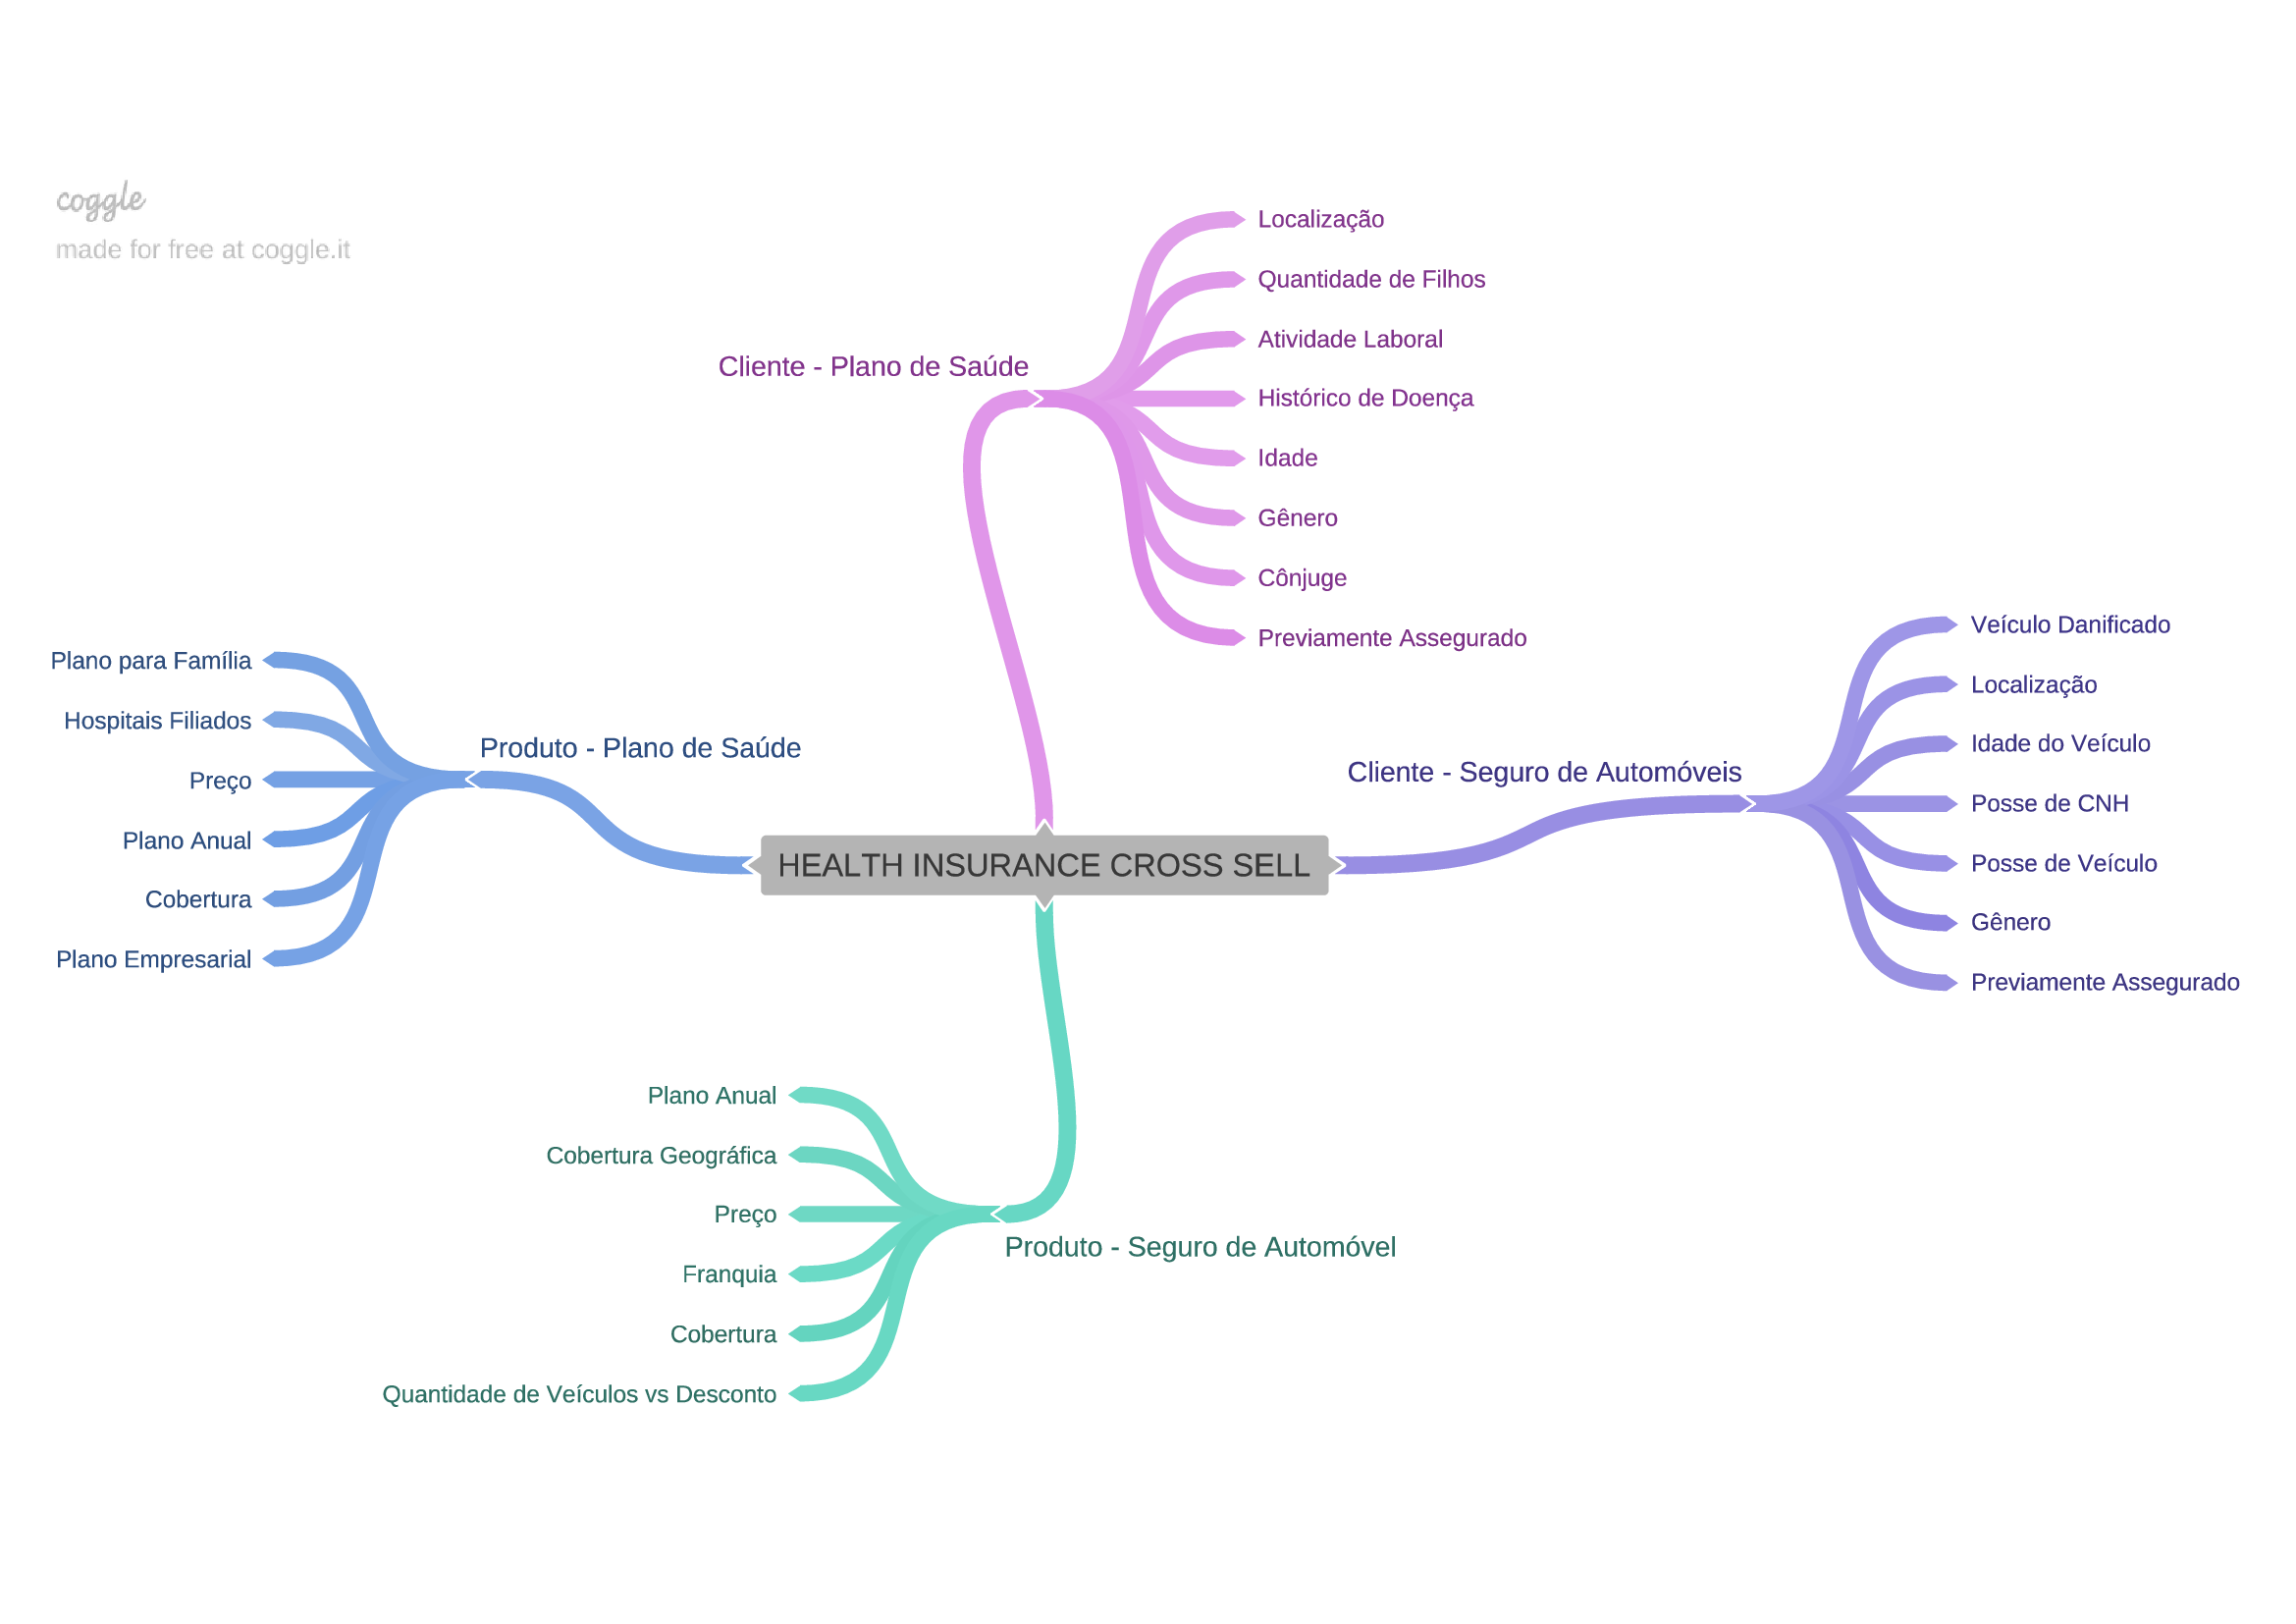

In [11]:
Image('feature_engineering.png')

### 2.2 Criação de Hipóteses

**1.** Clientes do gênero masculino aceitam mais o seguro veicular do que o gênero feminino.

**2.** Clientes do gênero feminino rejeitam mais o seguro veicular do que o gênero masculino.

**3.** Clientes que possuem Driving License aceitam mais o seguro do que os clientes que não possuem.

**4.** Clientes que possuem veículos com menos de 1 ano aceitam menos o seguro veicular.

**5.** Clientes que possuem veículos com mais de 2 anos aceitam mais o seguro veicular.

**6.** Clientes em que seus veículos já foram danificados aceitam mais o seguro veicular.

**7.** Clientes que já possuem algum seguro veicular aceitam menos o seguro veicular.

**8.** Clientes que estão a mais de 180 dias com a empresa aceitam mais o seguro veicular.

**9.** Clientes com idade acima de 40 anos aceitam mais o seguro veicular.

## 2.3 Ajuste de Variáveis 

In [12]:
# gender
df2['gender'] = df2['gender'].apply(lambda x: x.lower())

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' 
                                              if x == '> 2 Years' else 'between_1_2_years' 
                                              if x == '1-2 Year' else 'below_1_year')

# 3.0 - Filtragem de Variáveis

In [13]:
df3 = df2.copy()

# 4.0 - Análise Exploratória de Dados

In [14]:
df4 = df3.copy()

## 4.1 Análise Univariada

### Variável: 'age'

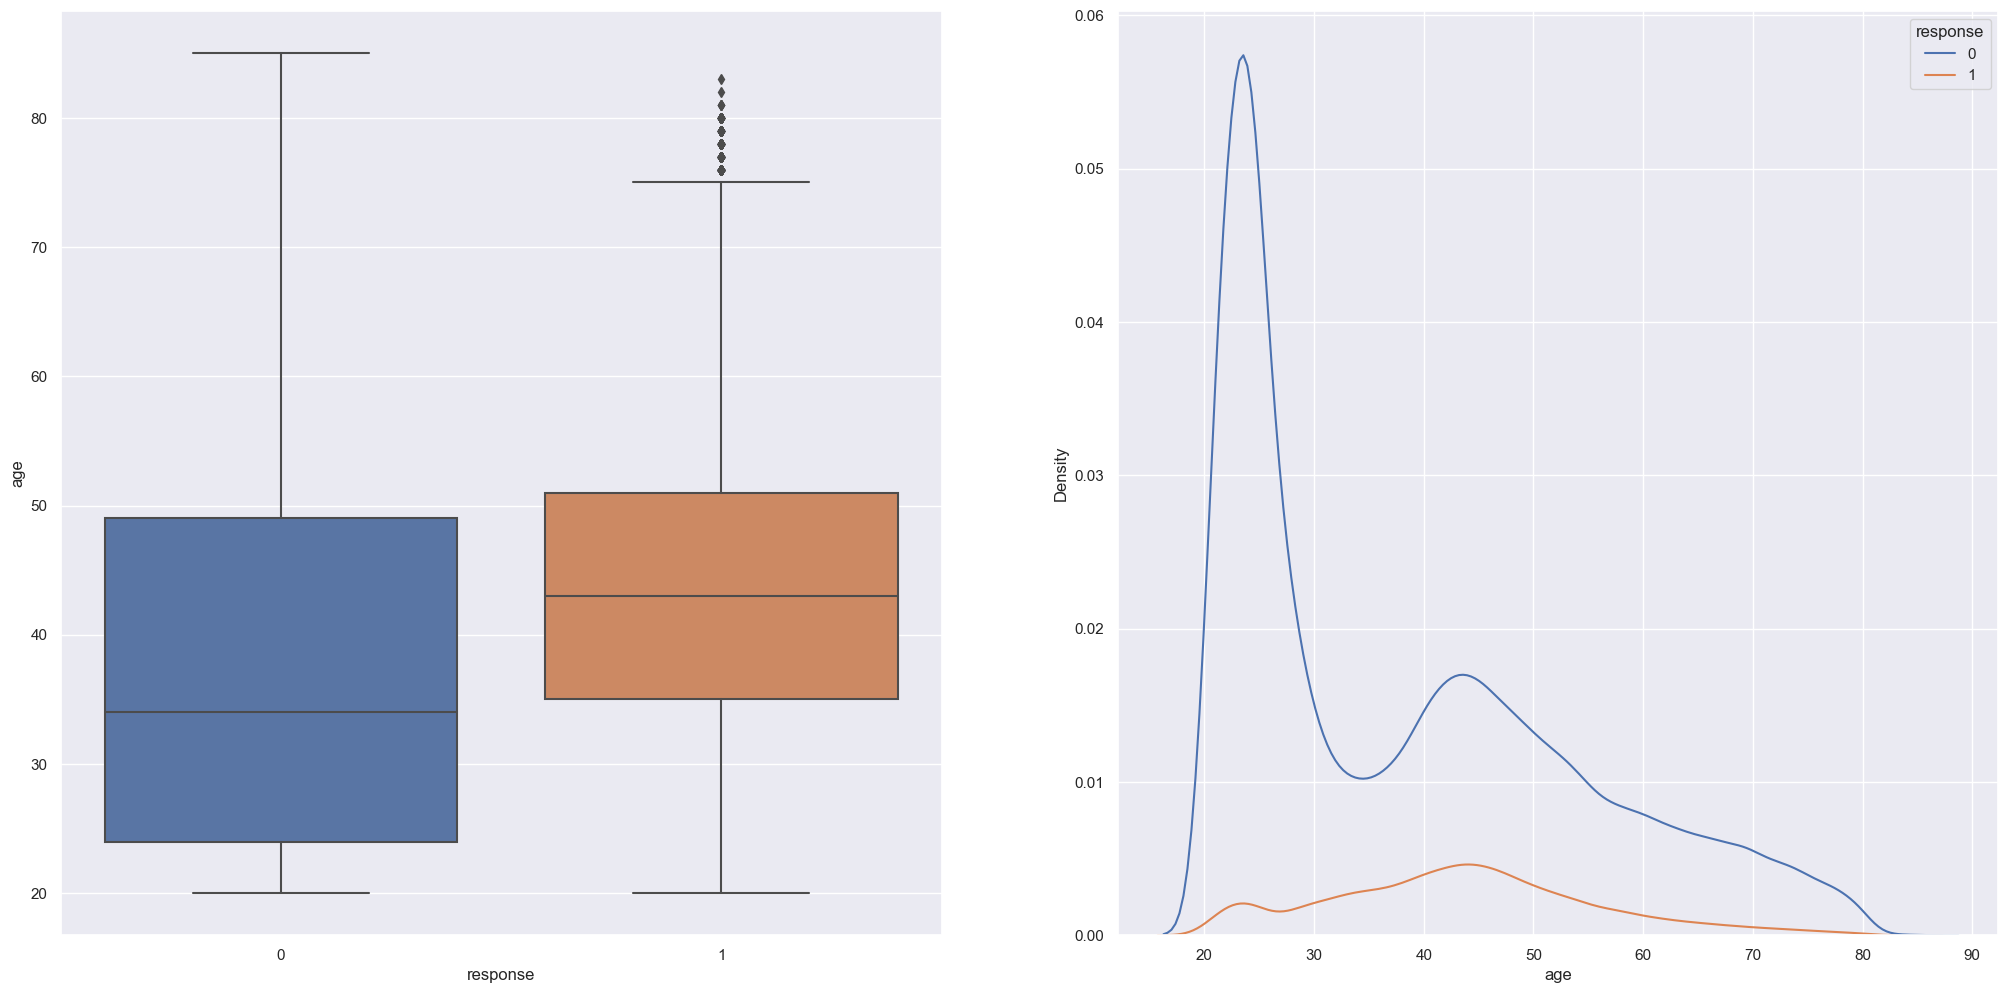

In [15]:
# Primeiro Grid - Boxplot da Variável age
plt.subplot(1, 2, 1)
sns.boxplot(x='response', y='age', data=df4);

# Segundo Grid - Gráfico de densidade da variável age
plt.subplot(1, 2, 2)
sns.kdeplot(data=df4, x='age', hue='response');

#### Distribuição da Variável age

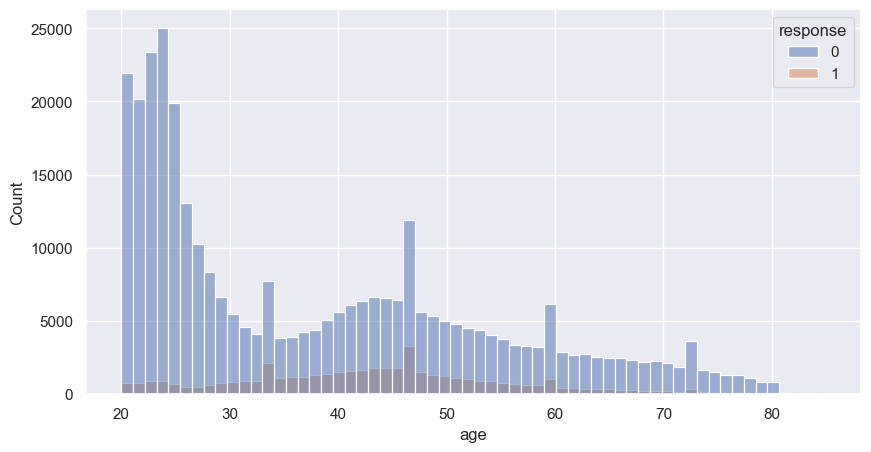

In [16]:
plt.figure(figsize=(10,5))
sns.histplot(data=df4, x=df4['age'], hue='response', bins=60);

### Variável: 'annual_premium'

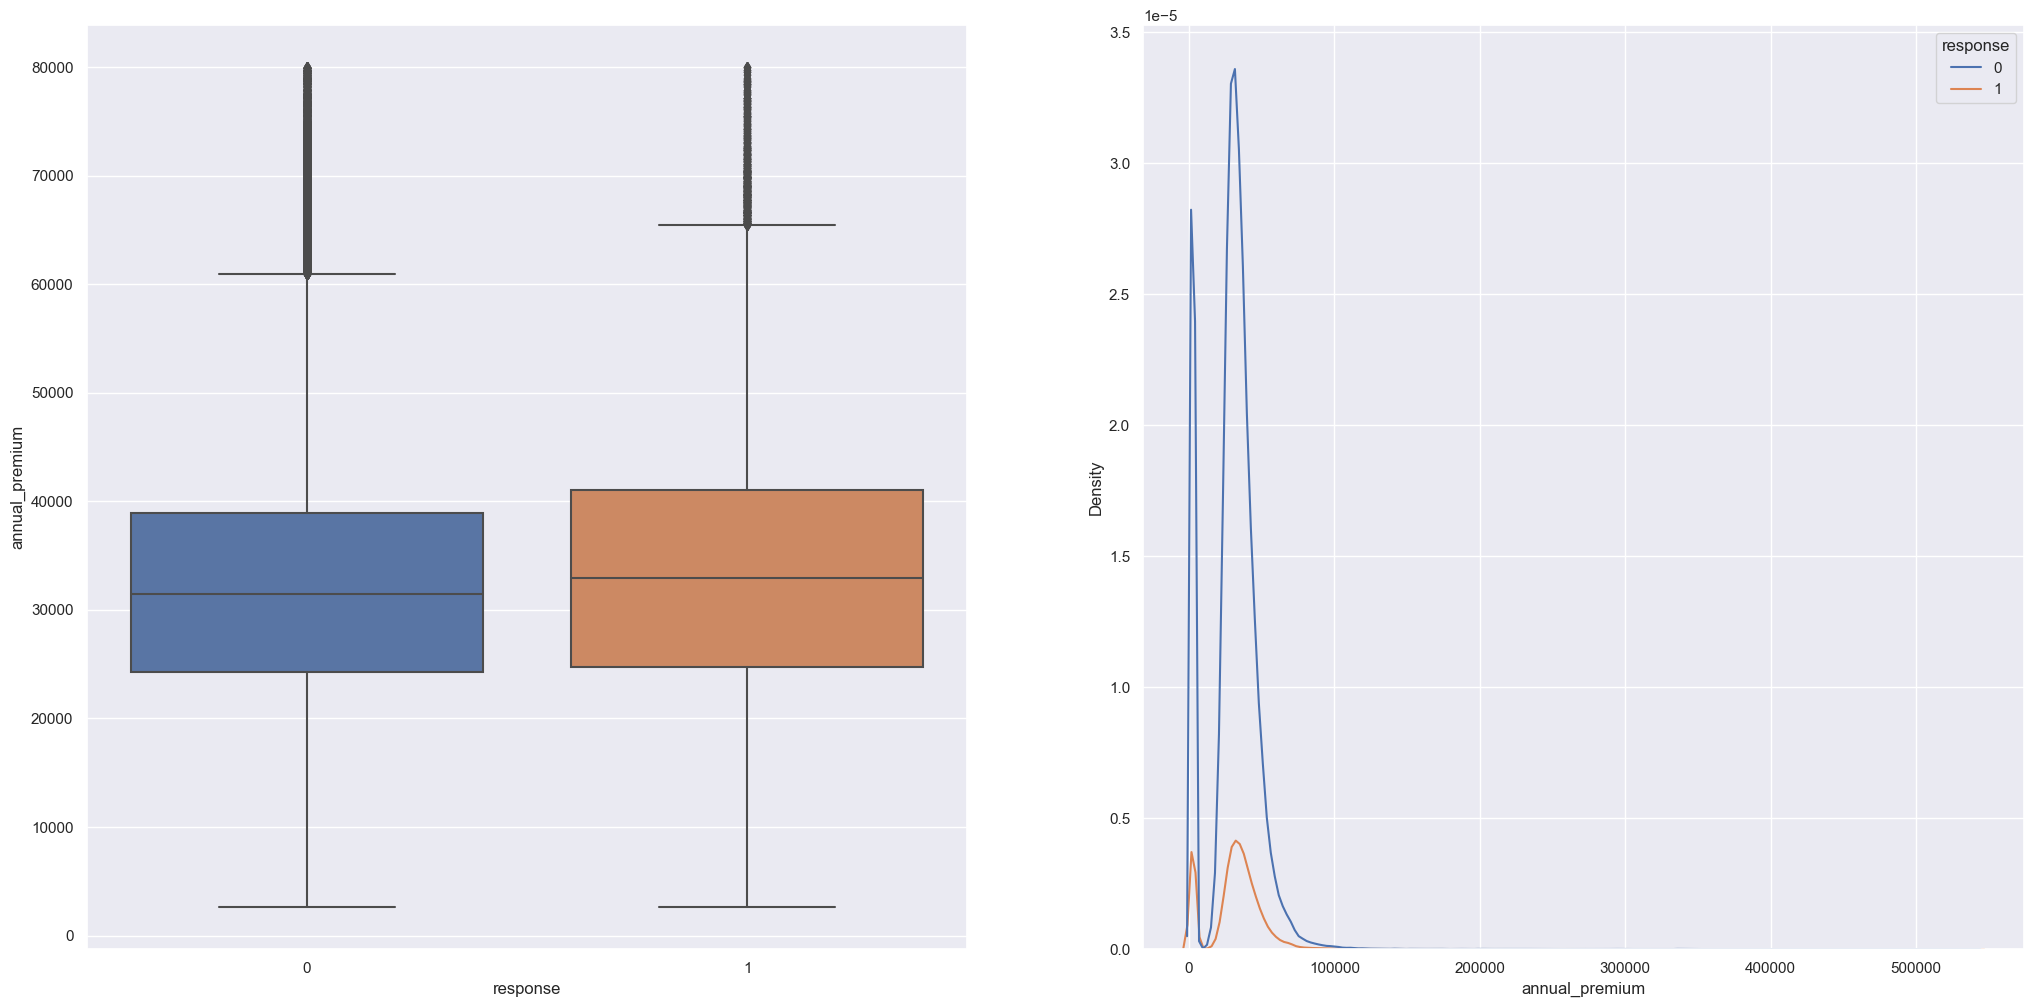

In [17]:
# annual_premium
aux = df4[df4['annual_premium'] < 80000]

# BOXPLOT
plt.subplot(1, 2, 1)
sns.boxplot(x='response', y='annual_premium', data=aux);

# DSITRIBUIÇÃO
plt.subplot(1, 2, 2)
sns.kdeplot(df4, x='annual_premium', hue='response');

#### Distribuição da variável annual_premium

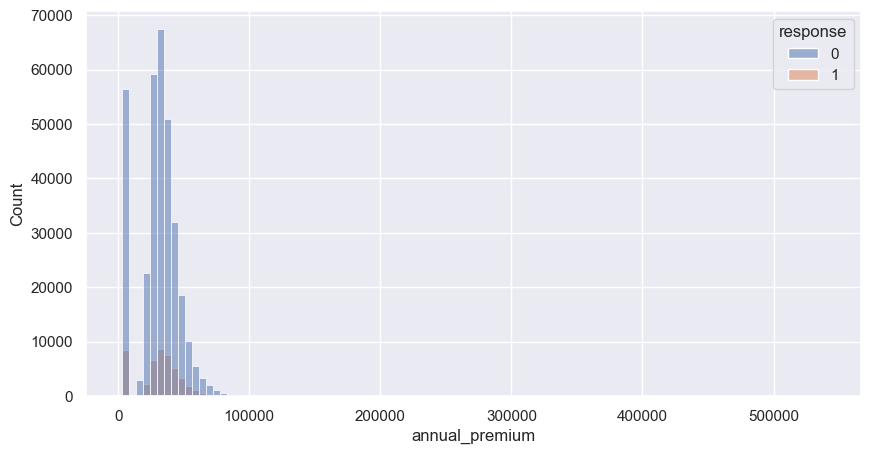

In [18]:
plt.figure(figsize=(10,5))
sns.histplot(data=df4, x=df4['annual_premium'], hue='response', bins=100);

### Variável: 'driving_license'

In [19]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('driving_license').count().reset_index()
aux['driving_license_percentual'] = aux['driving_license'] / np.sum(aux['driving_license'])

df_driving_license = pd.crosstab(df4['driving_license'], df4['response']).apply(lambda x: x/x.sum(), axis=1)


print(f"Clients without DL: {aux.loc[0, 'response']}")
print(f"Clients with DL: {aux.loc[1, 'response']}")
df_driving_license

Clients without DL: 812
Clients with DL: 380297


response,0,1
driving_license,,
0,0.949507,0.050493
1,0.877283,0.122717


### Variável: 'region_code'

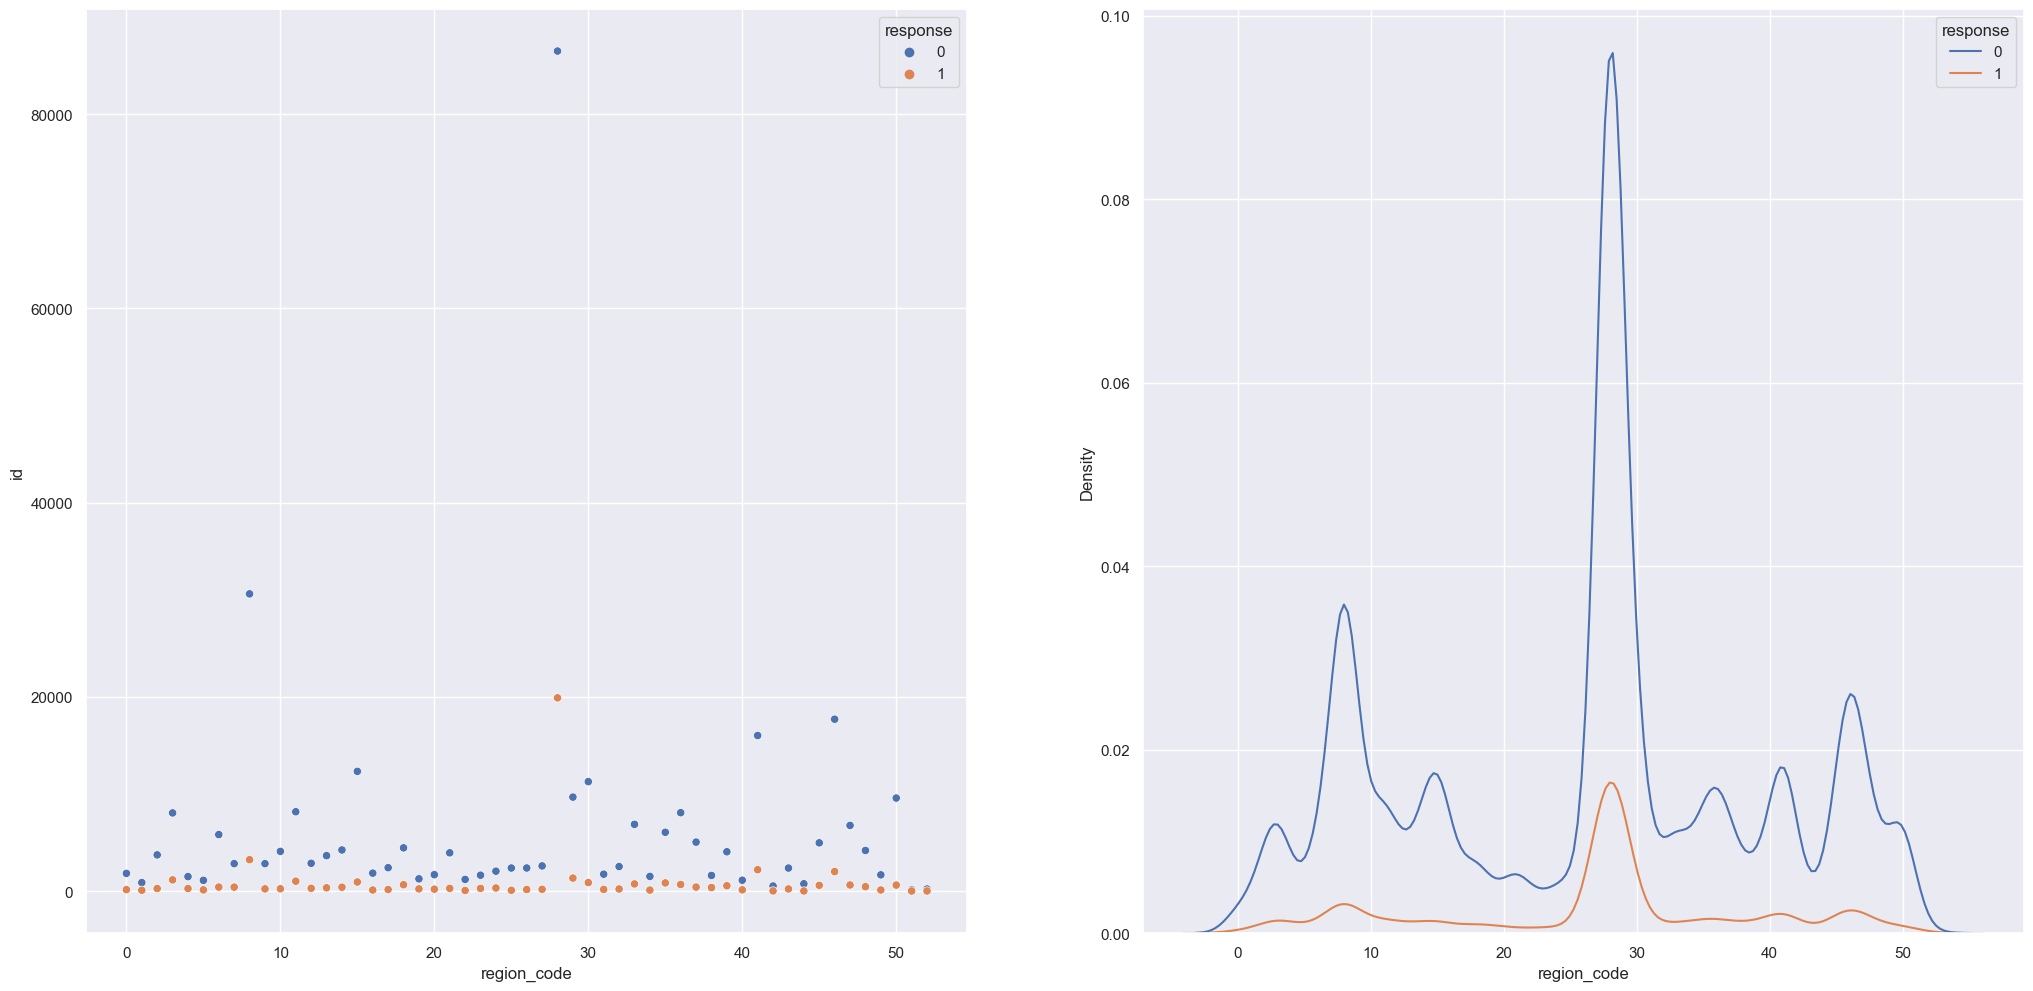

In [20]:
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

# SCATTER PLOT
plt.subplot(1, 2, 1)
sns.scatterplot(x='region_code', y='id', hue='response', data=aux);

# DISTRIBUIÇÃO
plt.subplot(1, 2, 2)
sns.kdeplot(df4, x='region_code', hue='response');

### Variável: 'previously_insured'

In [21]:
# previously_insured
aux = df4[['previously_insured', 'response']].groupby('previously_insured').count().reset_index()

print(f"Clients dont´t previously_insured: {aux.loc[1, 'response']}")
print(f"Clients previously_insured: {aux.loc[0, 'response']}")

pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

Clients dont´t previously_insured: 174628
Clients previously_insured: 206481


response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


### Variável: 'policy_sales_channel'

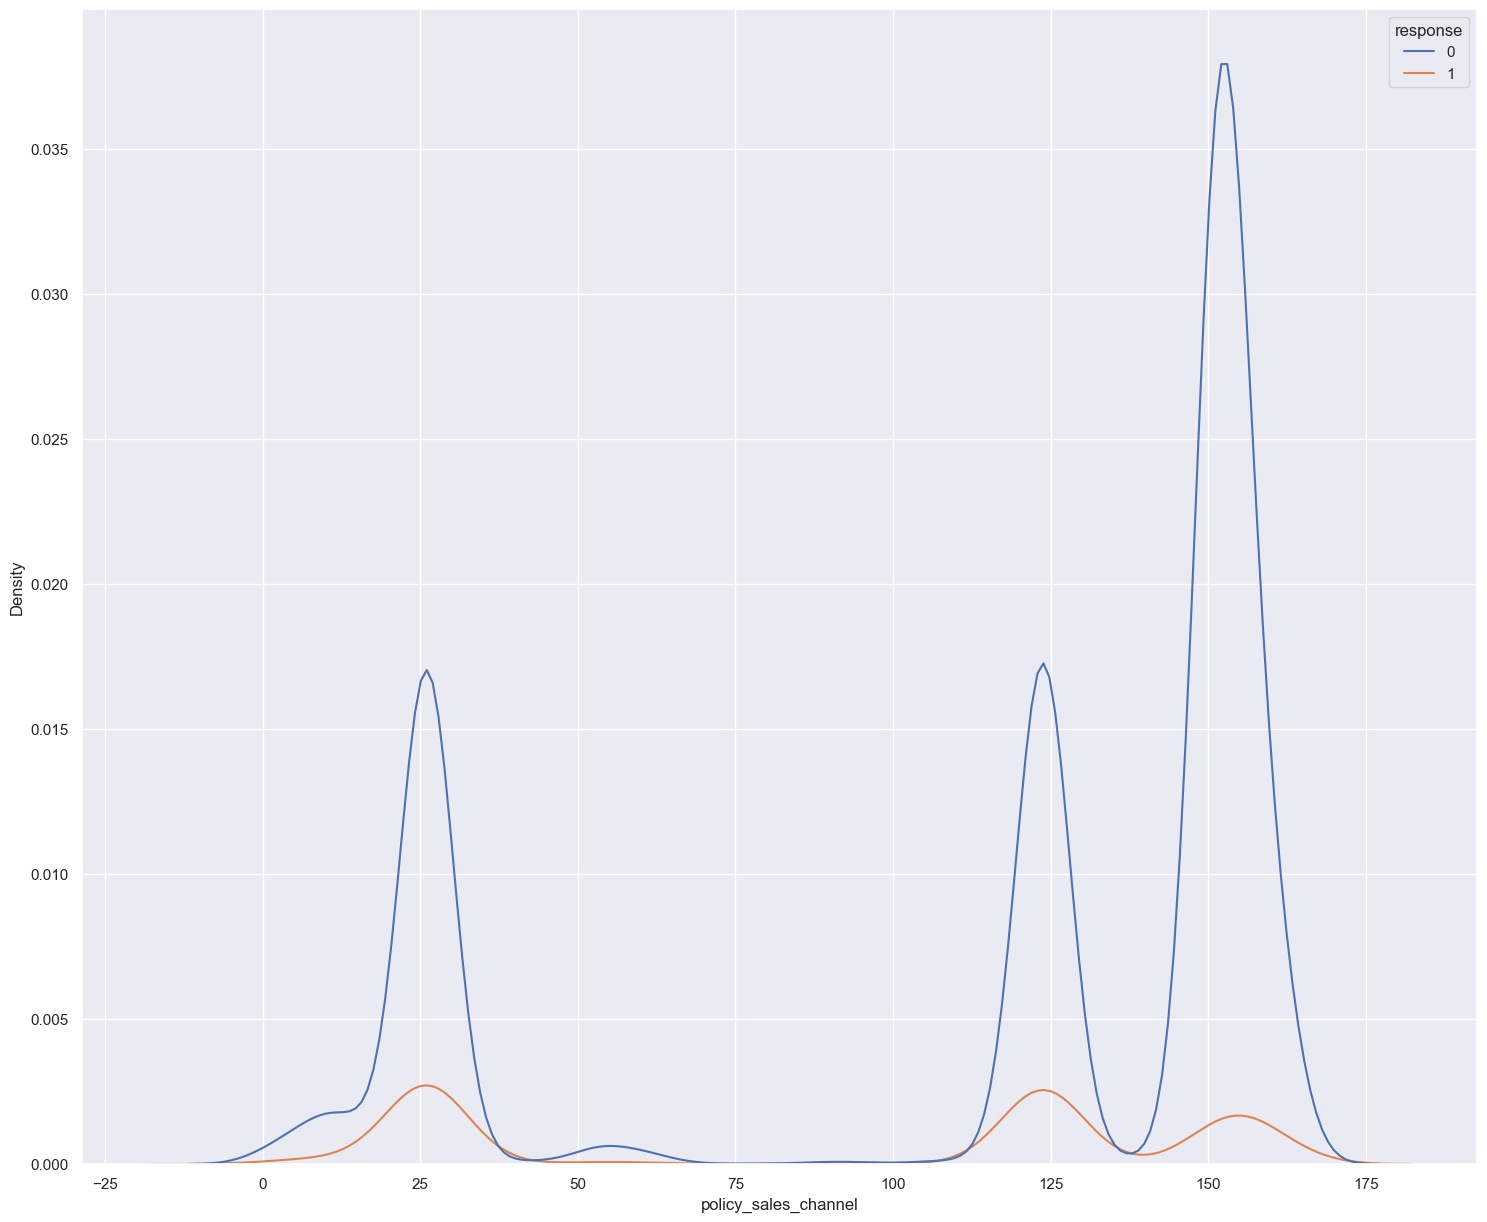

In [22]:
# agrupamento da resposta de interesse por canal de atendimento
aux = df4[['id', 'policy_sales_channel', 'response']].groupby(['policy_sales_channel', 'response']).count().reset_index()

# configuração do tamanho dos gráficos
plt.figure(figsize=(18,15))
sns.kdeplot(data=df4, x='policy_sales_channel', hue='response');

### Variável: 'vintage'

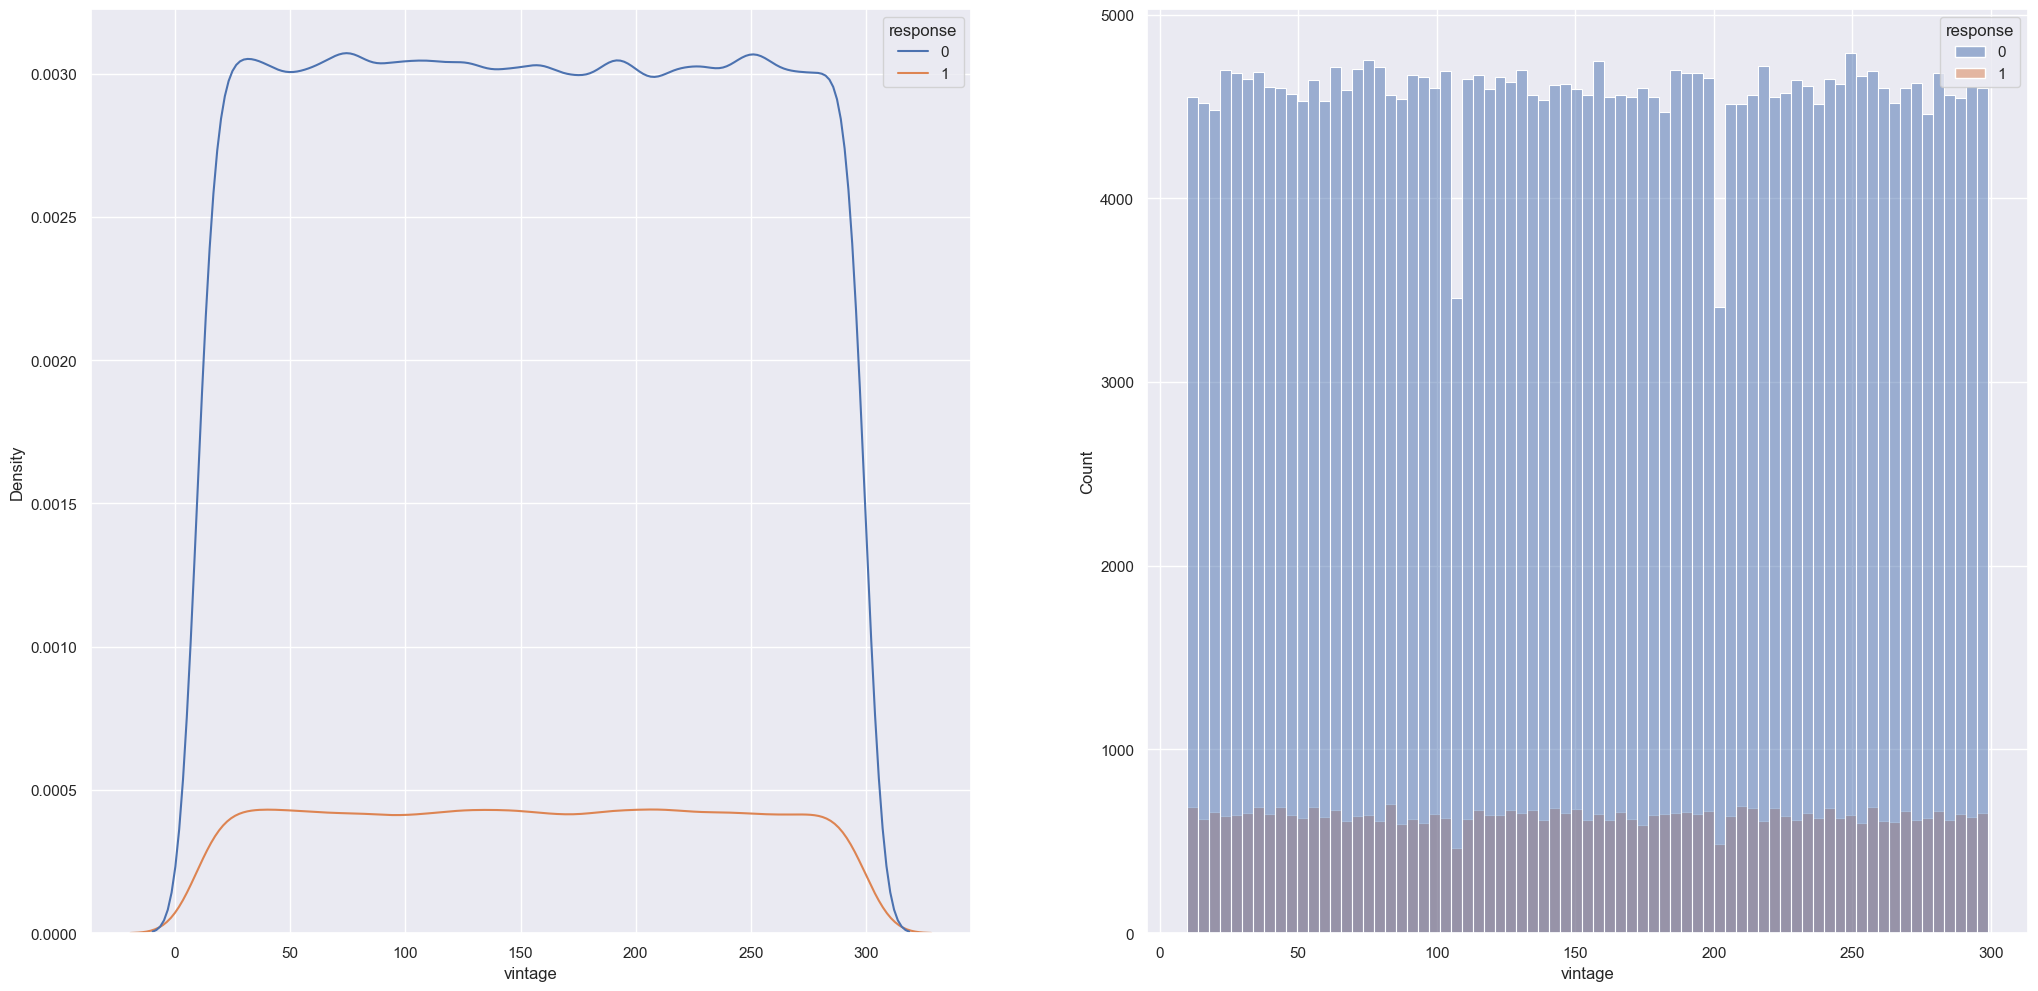

In [23]:
# distribuição de densidade por resposta
plt.subplot(1, 2, 1)
sns.kdeplot(data=df4, x='vintage', hue='response');

# histograma da variável 'vintage'
plt.subplot(1, 2, 2)
sns.histplot(data=df4, x='vintage', hue='response');

### Variável: vehicle_age

In [24]:
# vehicle_age
aux = df4[['vehicle_age', 'response']].groupby('vehicle_age').count().reset_index()

print(f"Clients with car below 1 year: {aux.loc[0, 'response']}")
print(f"Clients with car between 1-2 years: {aux.loc[1, 'response']}")
print(f"Clients with car over 2 years: {aux.loc[2, 'response']}")

pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

Clients with car below 1 year: 164786
Clients with car between 1-2 years: 200316
Clients with car over 2 years: 16007


response,0,1
vehicle_age,,
below_1_year,0.956295,0.043705
between_1_2_years,0.826245,0.173755
over_2_years,0.706254,0.293746


### Variável: vehicle_damage

In [25]:
# 'vehicle_damage'
aux = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').count().reset_index()

print(f"Clients hasn't car damage: {aux.loc[1, 'response']}")
print(f"Clients has car damage: {aux.loc[0, 'response']}")
    
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

Clients hasn't car damage: 192413
Clients has car damage: 188696


response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


### Variável: gender

In [26]:
#'gender'
aux = df4[['gender', 'response']].groupby('gender').count().reset_index()

print(f"Clients female: {aux.loc[0, 'response']}")
print(f"Clients male: {aux.loc[1, 'response']}")


pd.crosstab(df4['gender'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

Clients female: 175020
Clients male: 206089


response,0,1
gender,,
female,0.896098,0.103902
male,0.861589,0.138411


## 4.2 Análise Multivariada

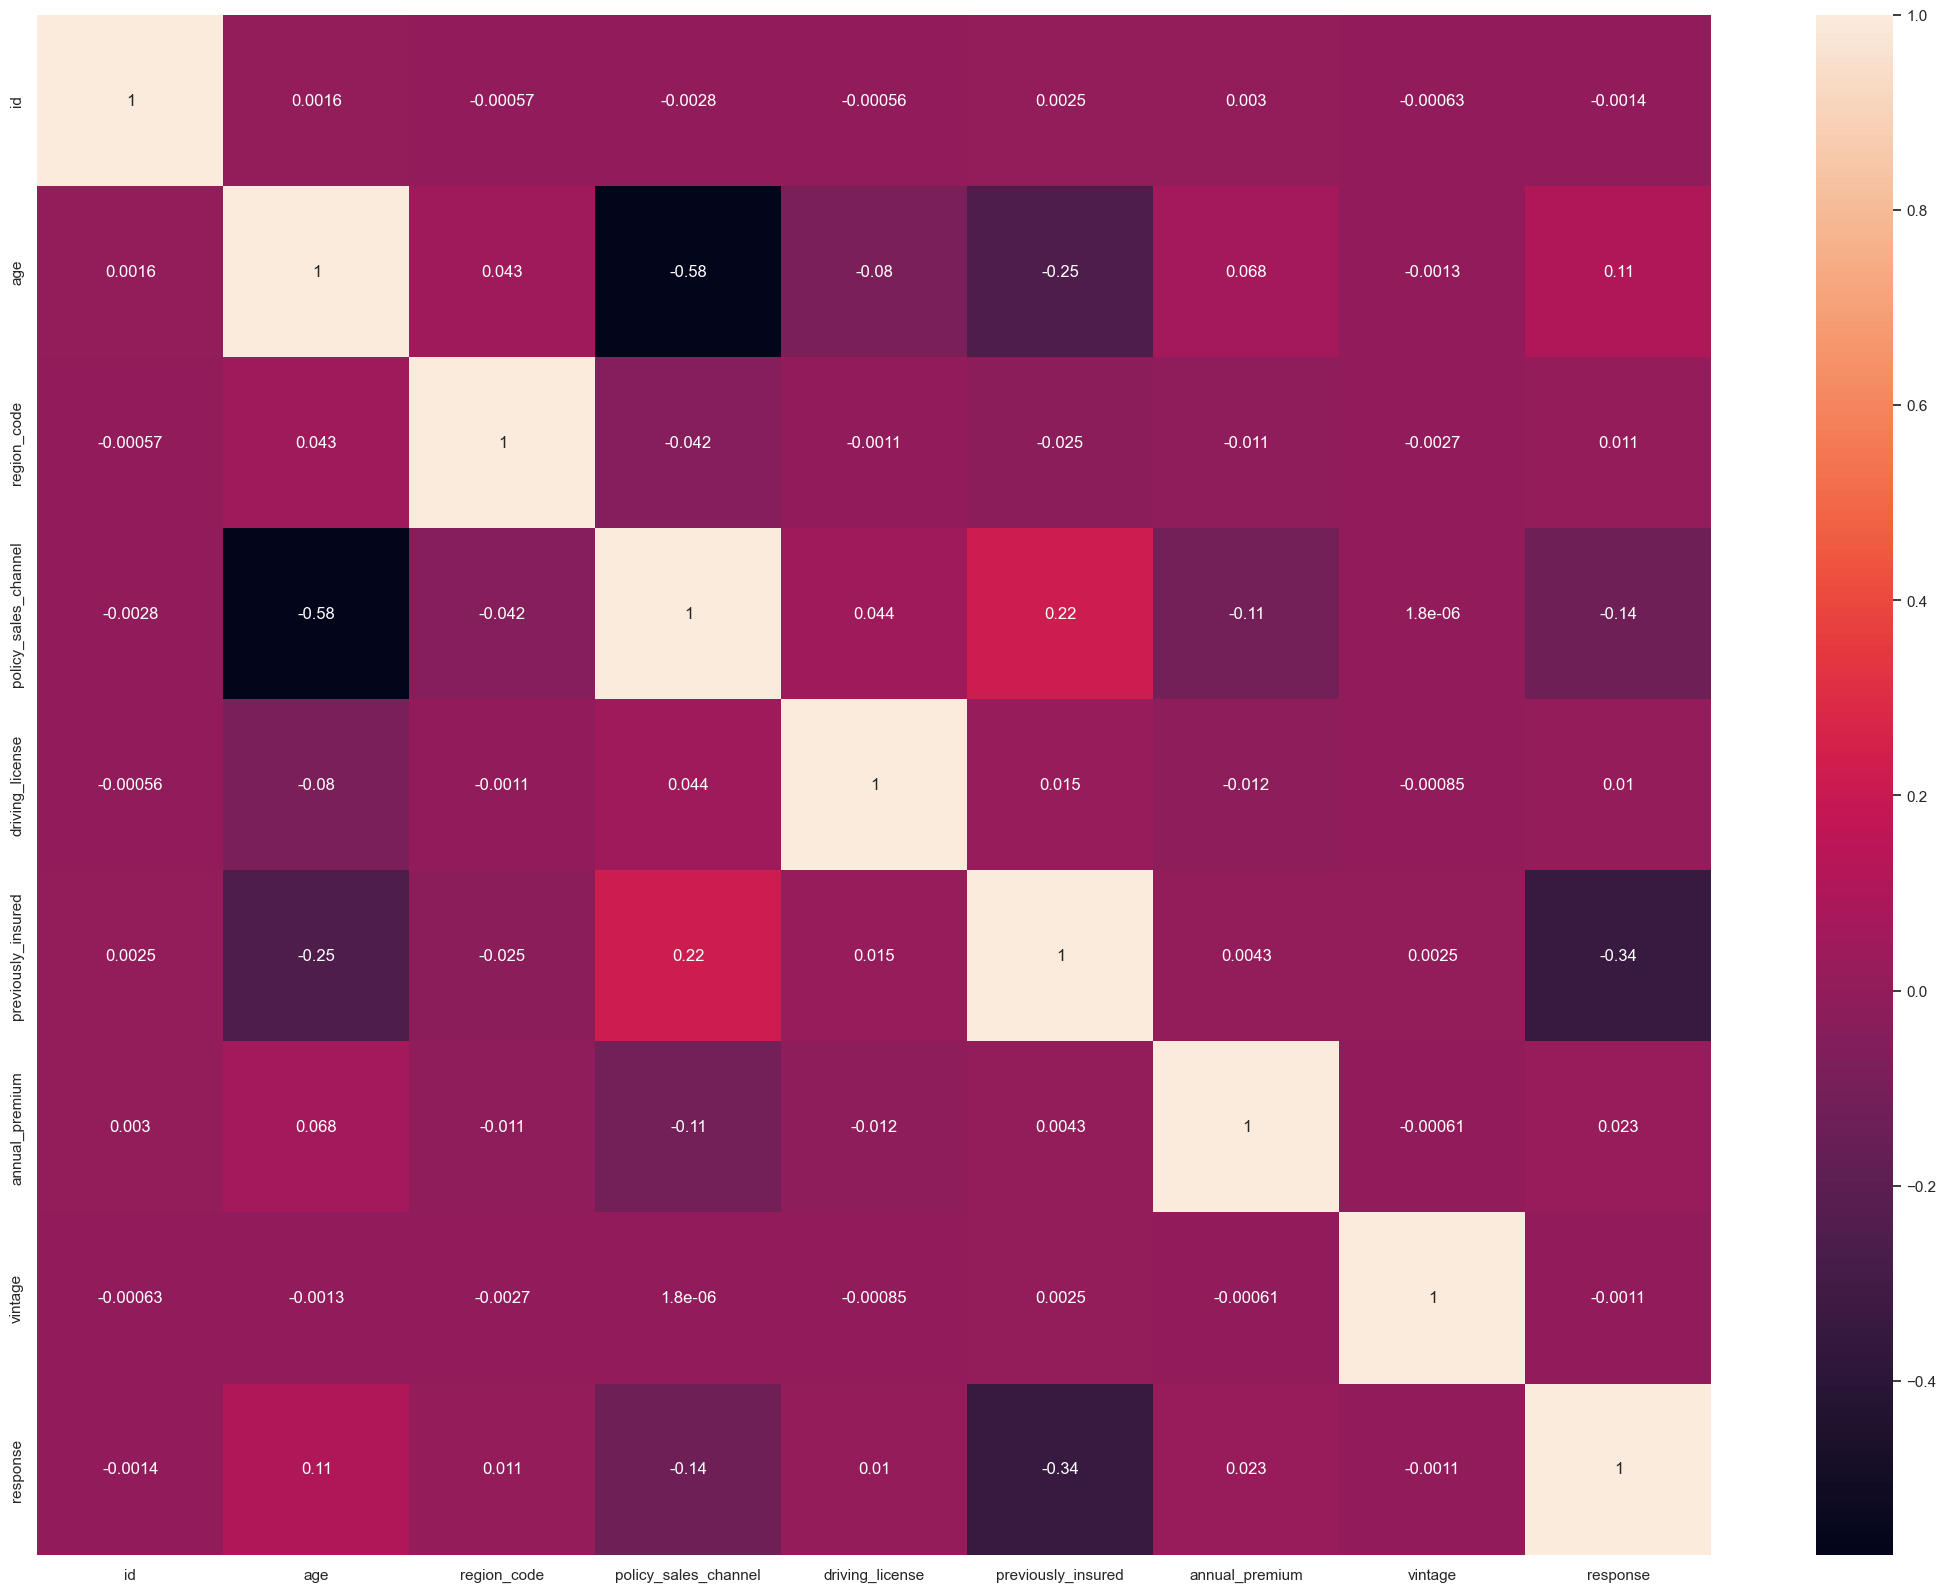

In [27]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(27,20))
sns.heatmap(correlation, annot=True);

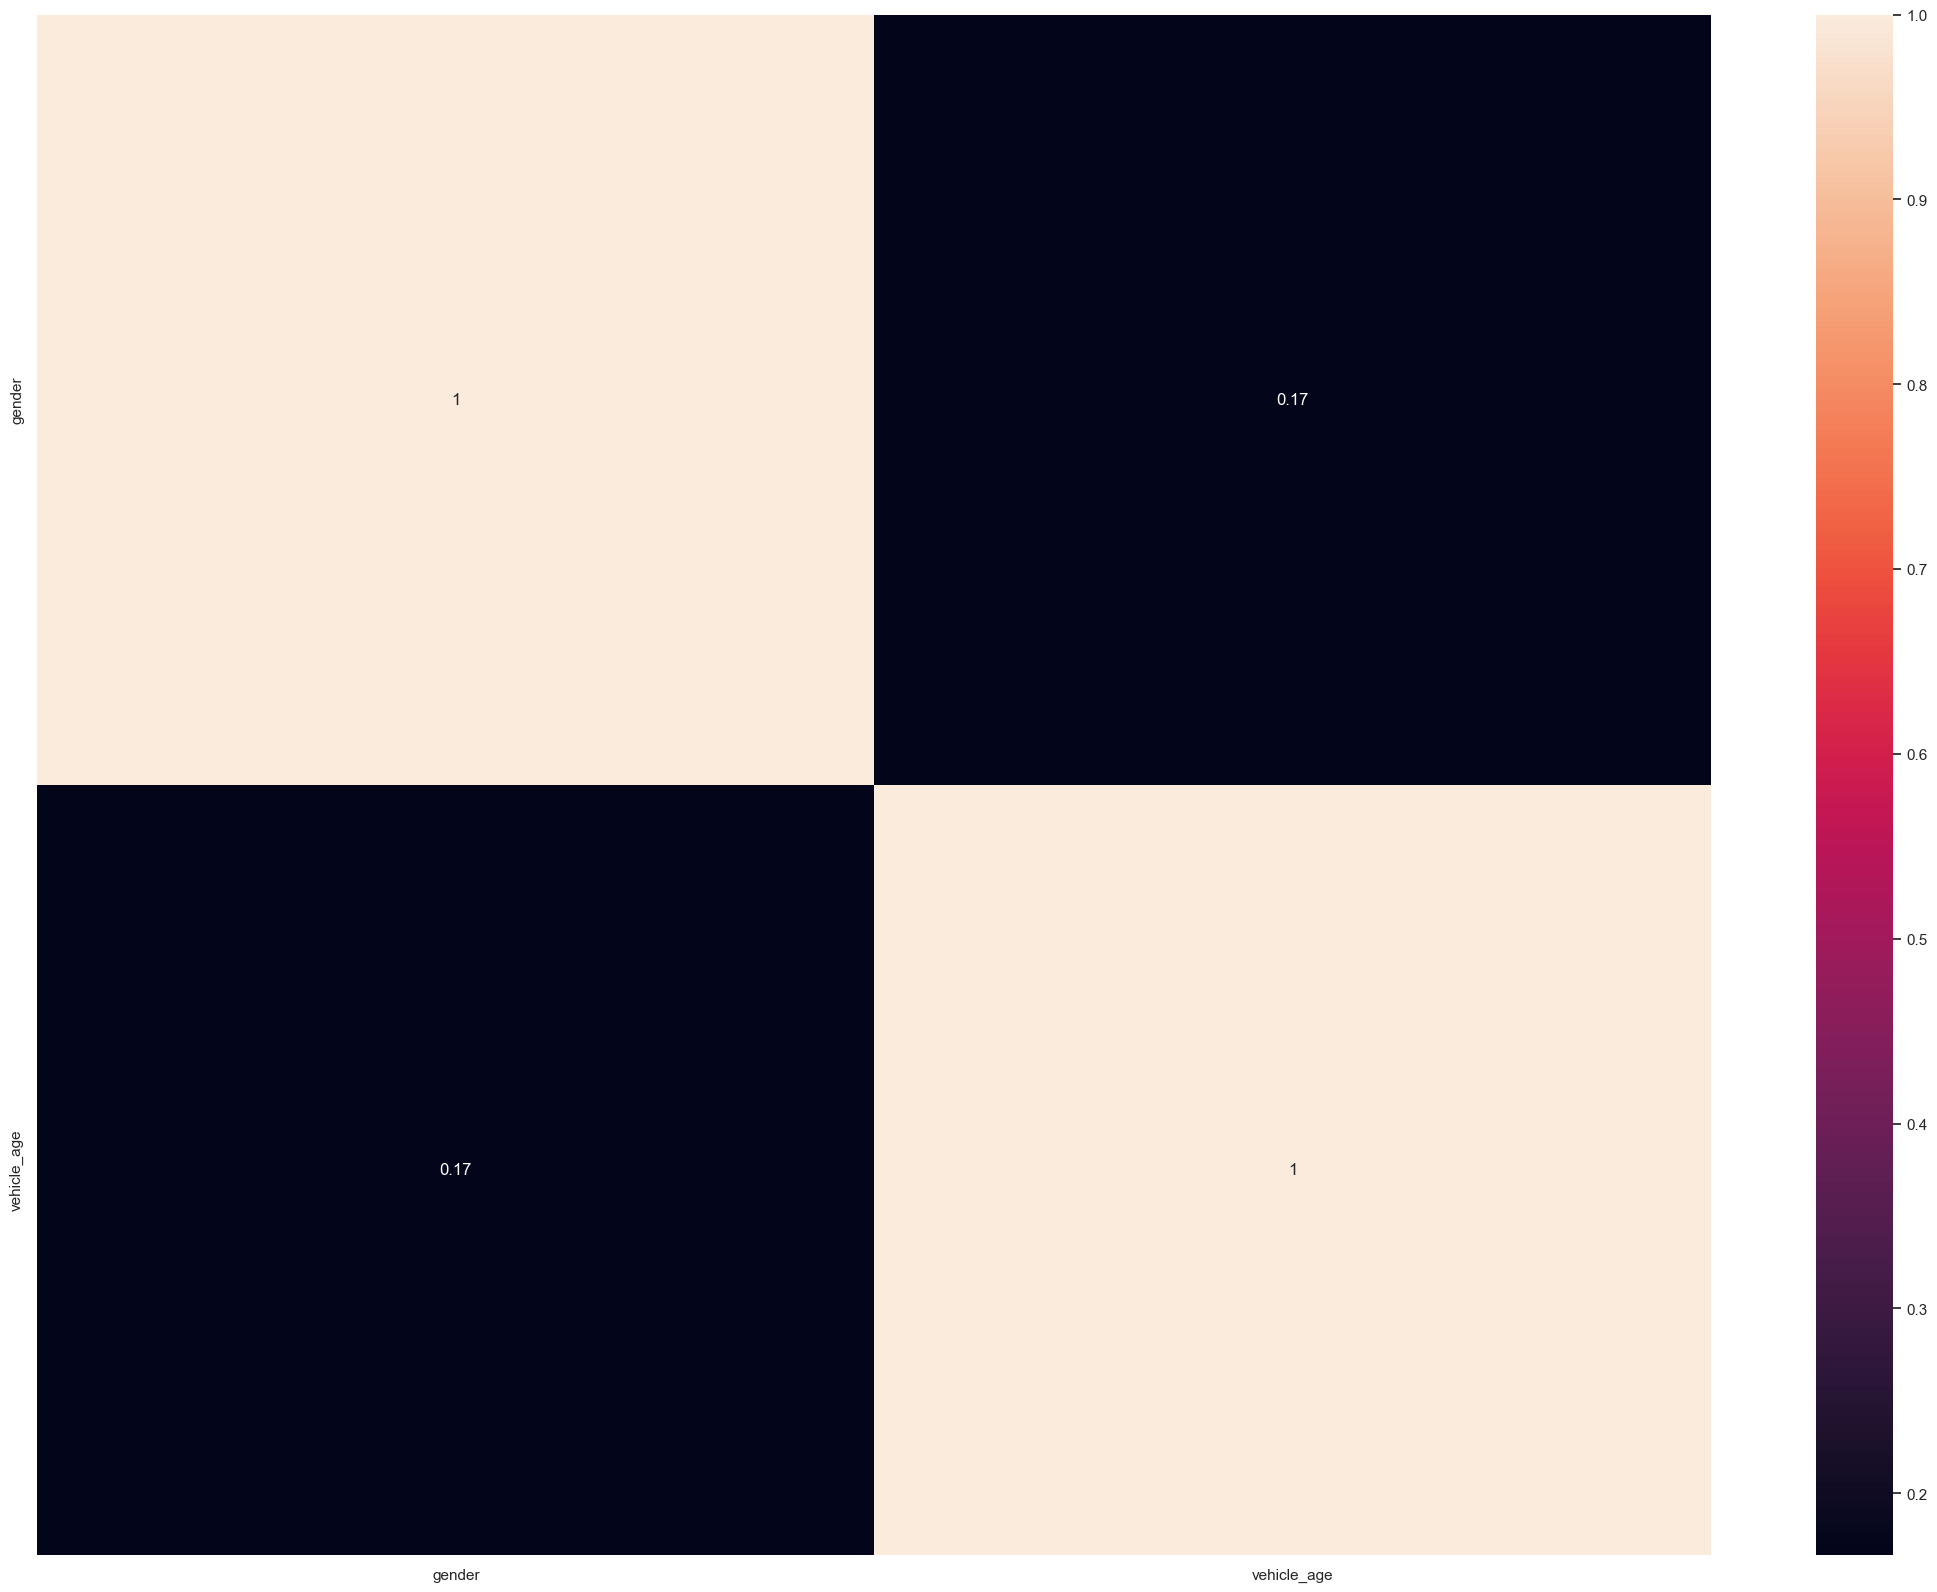

In [28]:
cat = df4.select_dtypes(include='object')
a1 = cramer_v(cat['gender'], cat['gender'])
a2 = cramer_v(cat['gender'], cat['vehicle_age'])

b1 = cramer_v(cat['vehicle_age'], cat['vehicle_age'])
b2 = cramer_v(cat['vehicle_age'], cat['gender'])

d = pd.DataFrame({'gender':[a1, a2], 
              'vehicle_age': [b2, b1]})

d = d.set_index(d.columns)

plt.figure(figsize = (27,20))
sns.heatmap(d, annot=True);

### age

#### Variável: vintage -> age

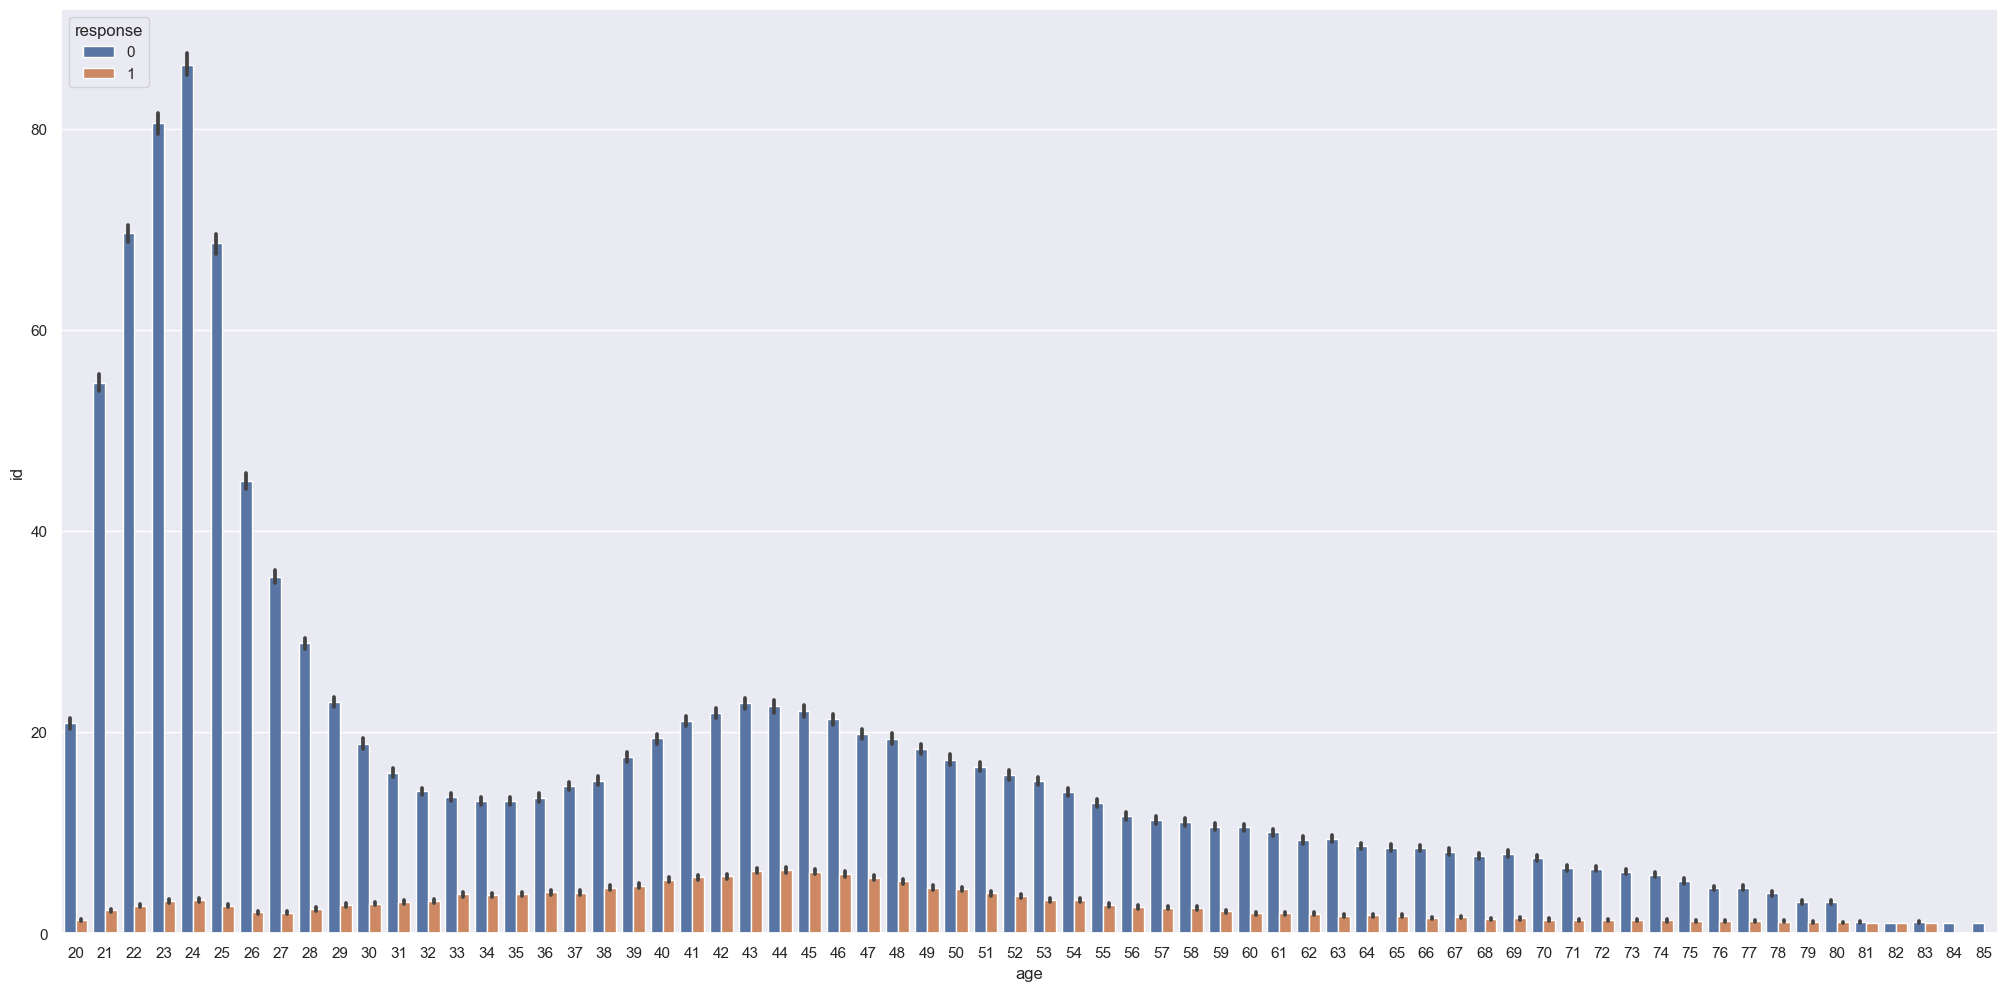

In [29]:
aux = df4[['id','age', 'vintage', 'response']].groupby(['age', 'vintage', 'response']).count().reset_index()

plt.subplot(1,1,1)
#age
sns.barplot(x='age', y='id', hue='response', data=aux);

#### Variável: annual_premium -> age

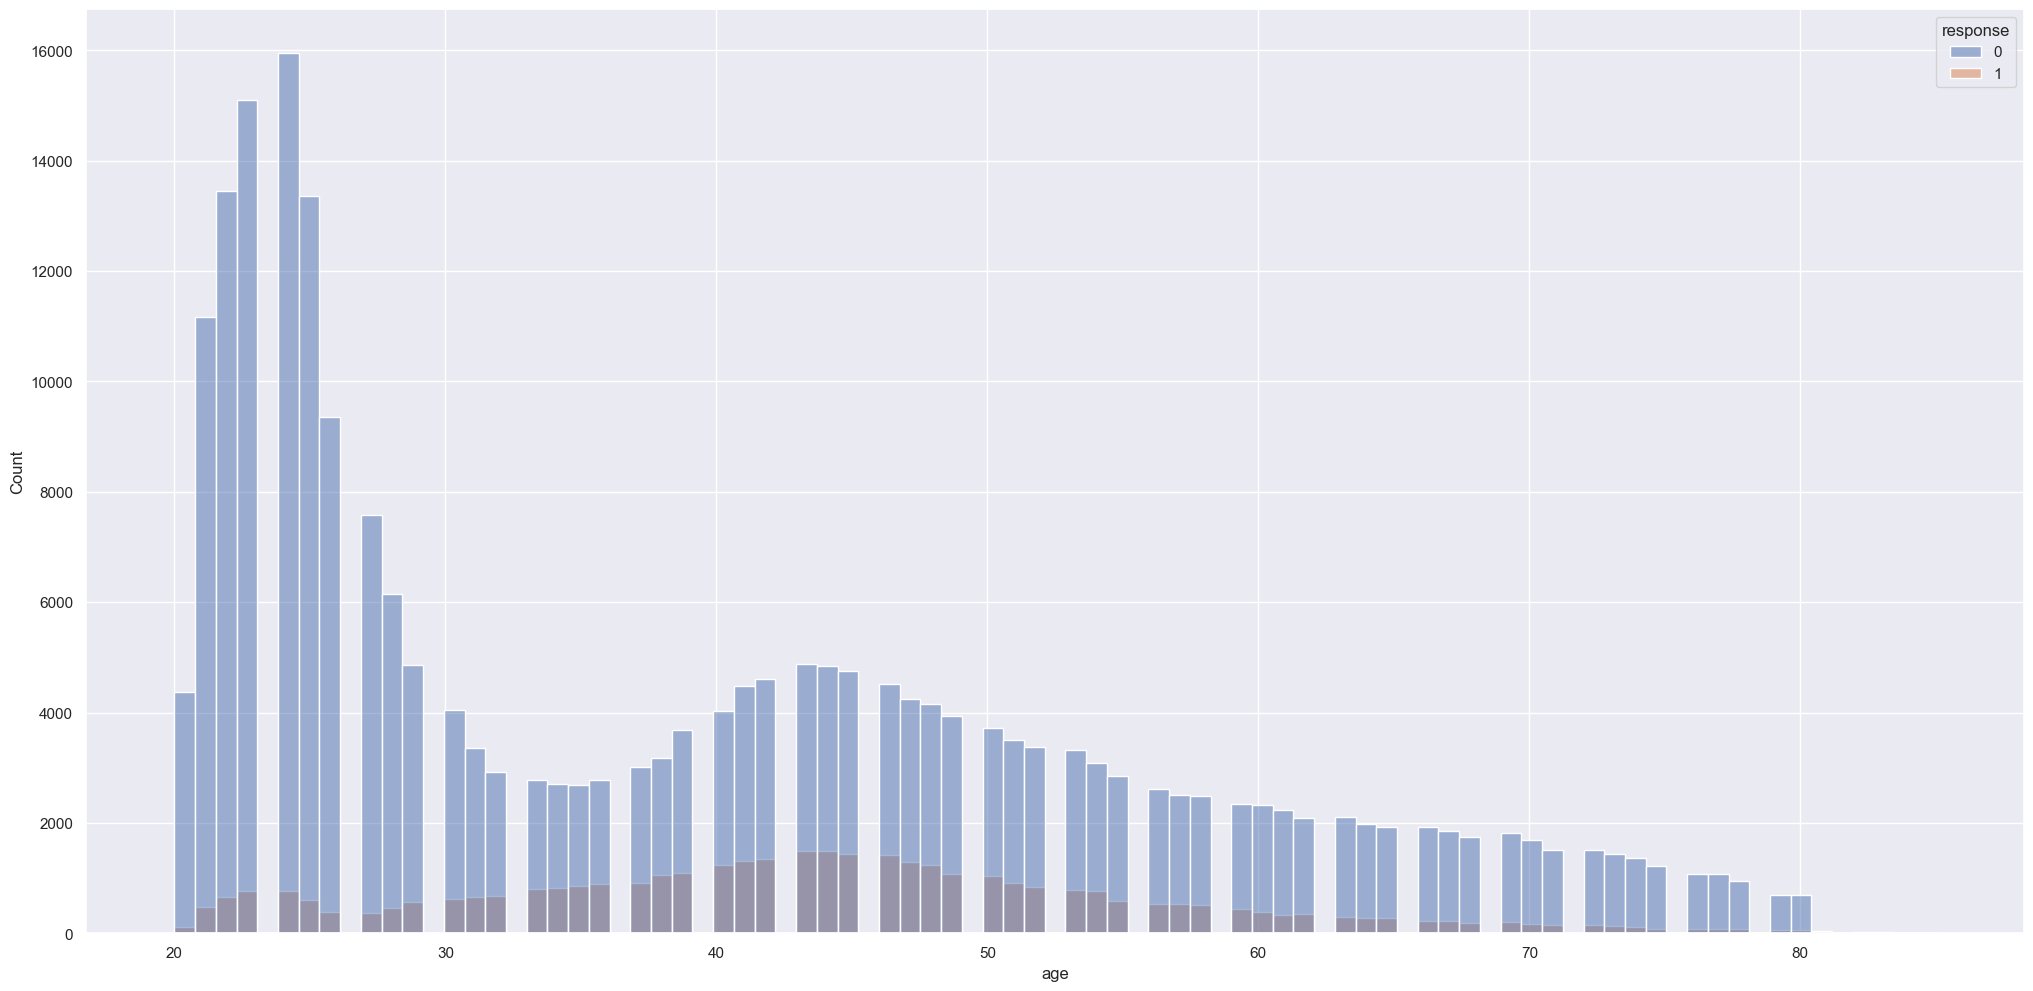

In [30]:
aux = df4[['id','age', 'annual_premium', 'response']].groupby(['age', 'annual_premium', 'response']).count().reset_index()

# Distribuição
sns.histplot(aux, x='age', hue='response');

####  Variável: region_code -> age

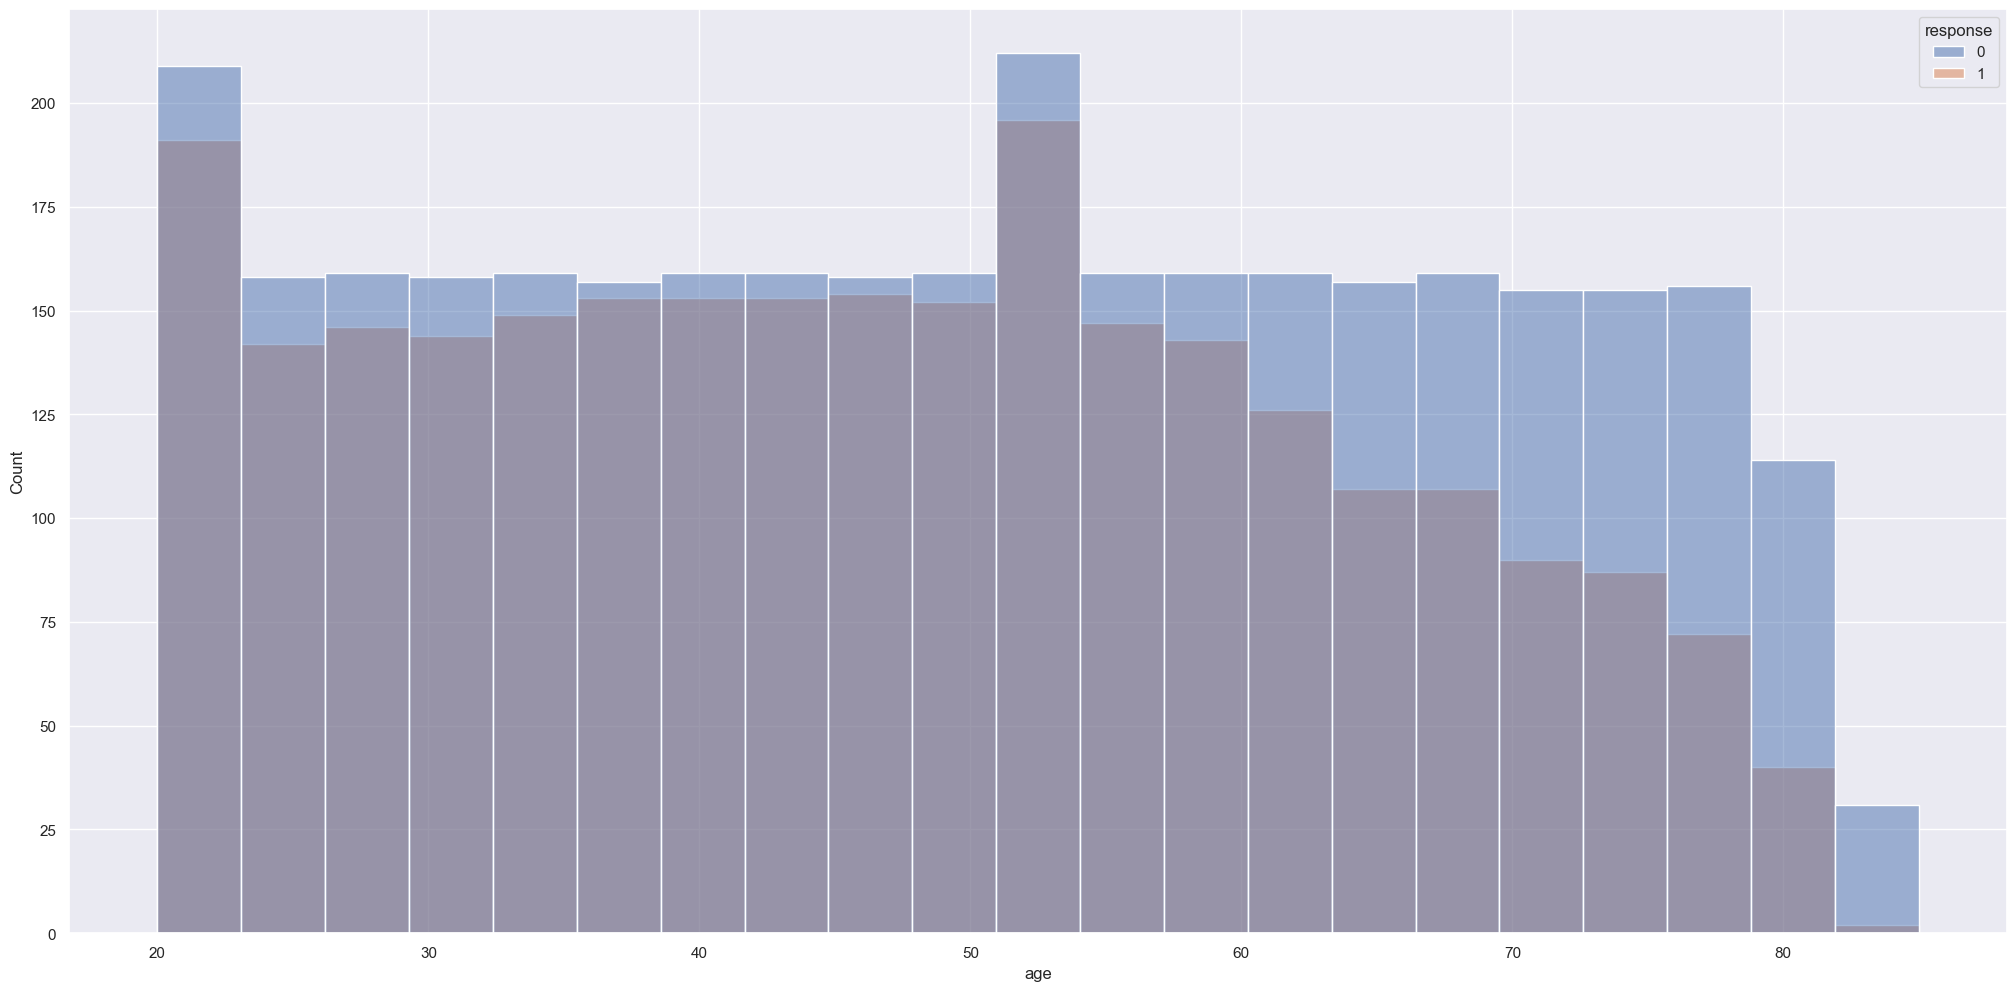

In [31]:
aux = df4[['id','age', 'region_code', 'response']].groupby(['age', 'region_code', 'response']).count().reset_index()

# Distribuição
sns.histplot(aux, x='age', hue='response');

#### Variável: driving_license -> age

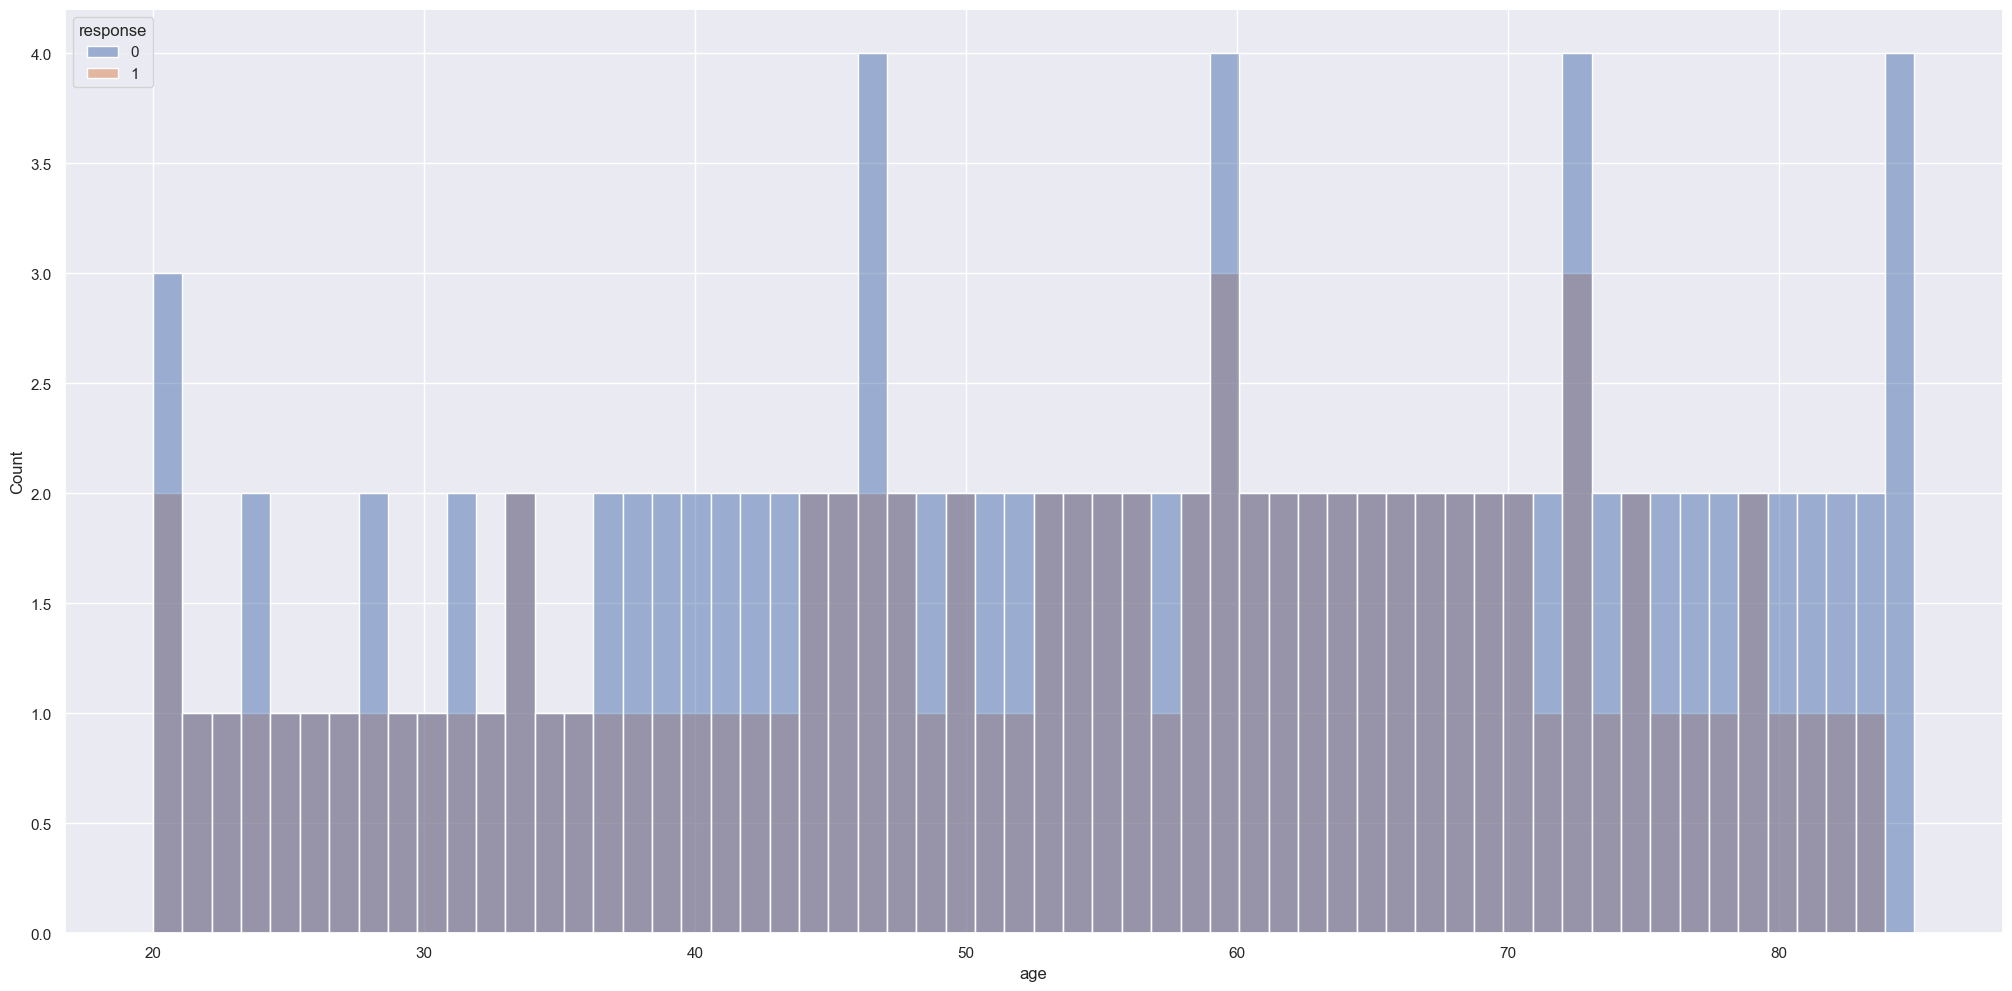

In [32]:
aux = df4[['id','age', 'driving_license', 'response']].groupby(['age', 'driving_license', 'response']).count().reset_index()

# Distribuição
sns.histplot(aux, x='age', hue='response', bins=60);

#### Variável: policy_sales_channel -> age

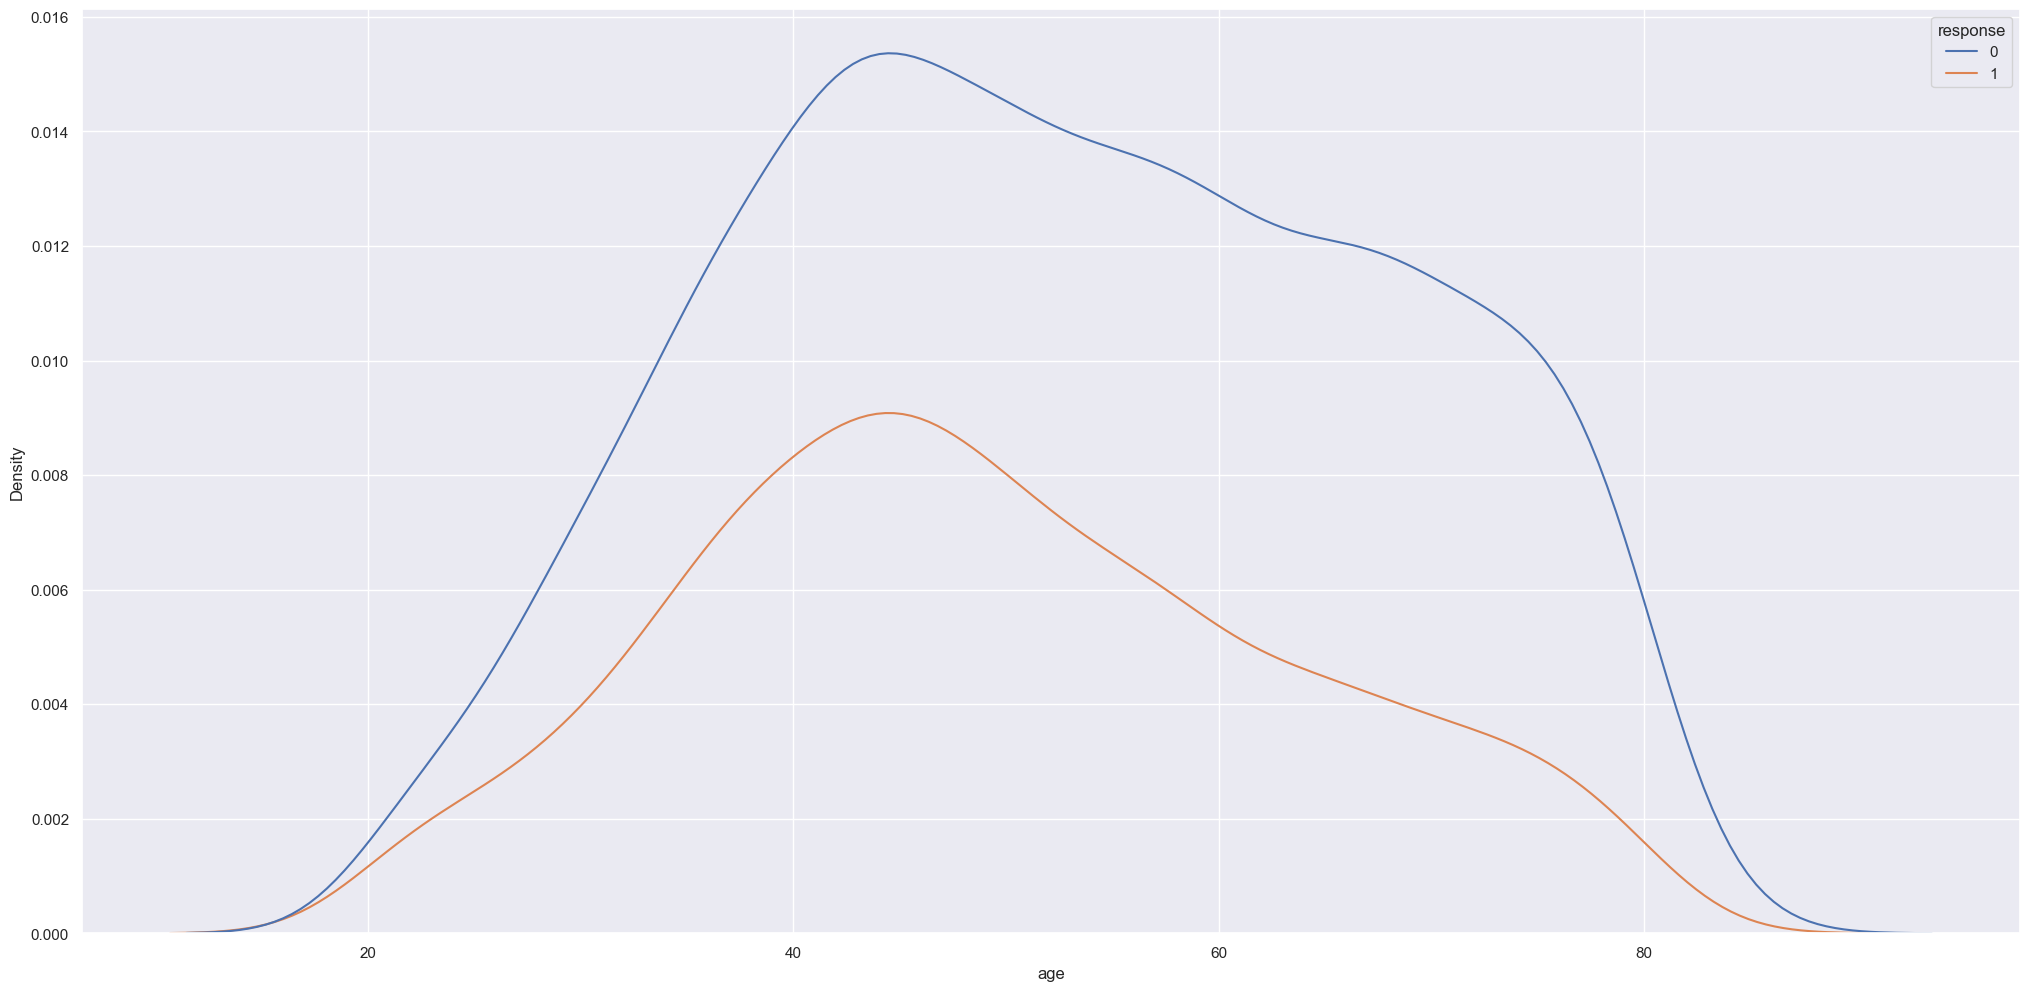

In [33]:
aux = df4[['id','age', 'policy_sales_channel', 'response']].groupby(['age', 'policy_sales_channel', 'response']).count().reset_index()

# Distribuição
sns.kdeplot(aux, x='age', hue='response');

#### Variável: previously_insured -> age

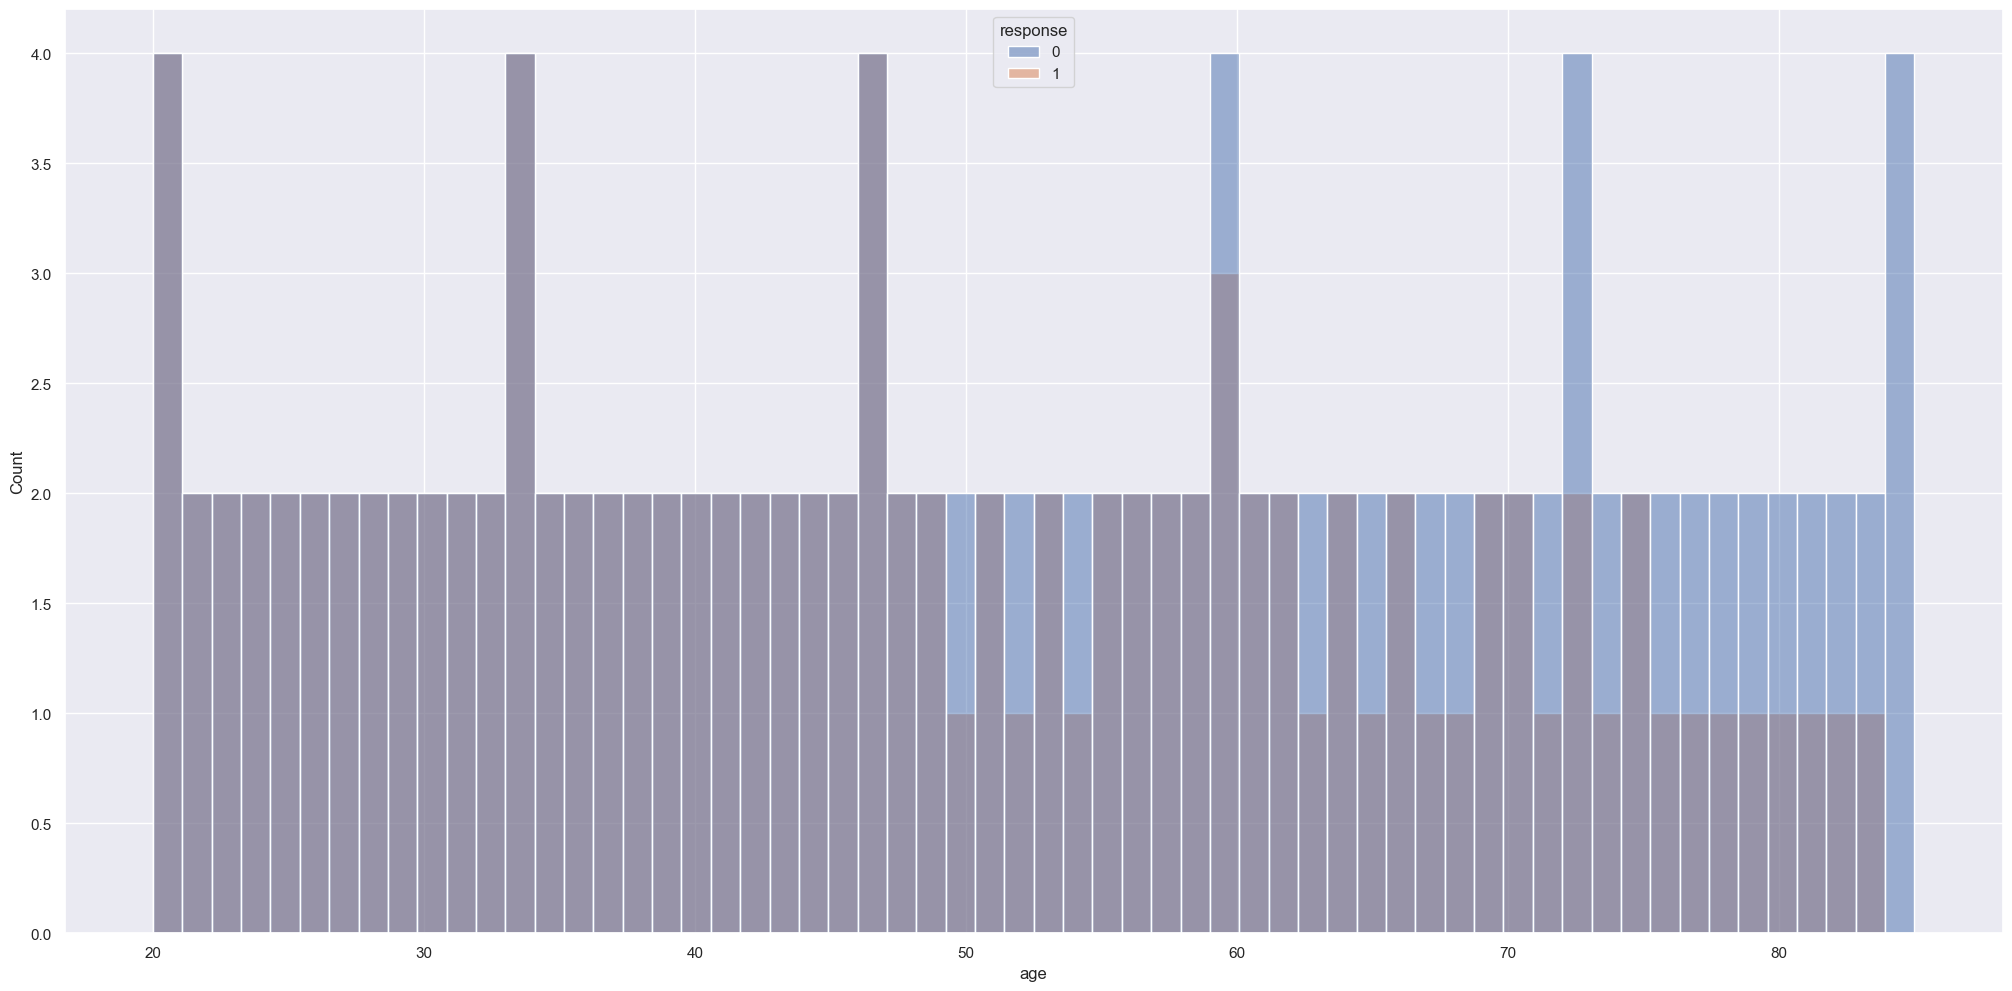

In [34]:
aux = df4[['id','age', 'previously_insured', 'response']].groupby(['age', 'previously_insured', 'response']).count().reset_index()

# Distribuição
sns.histplot(aux, x='age', hue='response', bins=60);

### annual_premium 

#### Variável: previously_insured -> annual_premium 

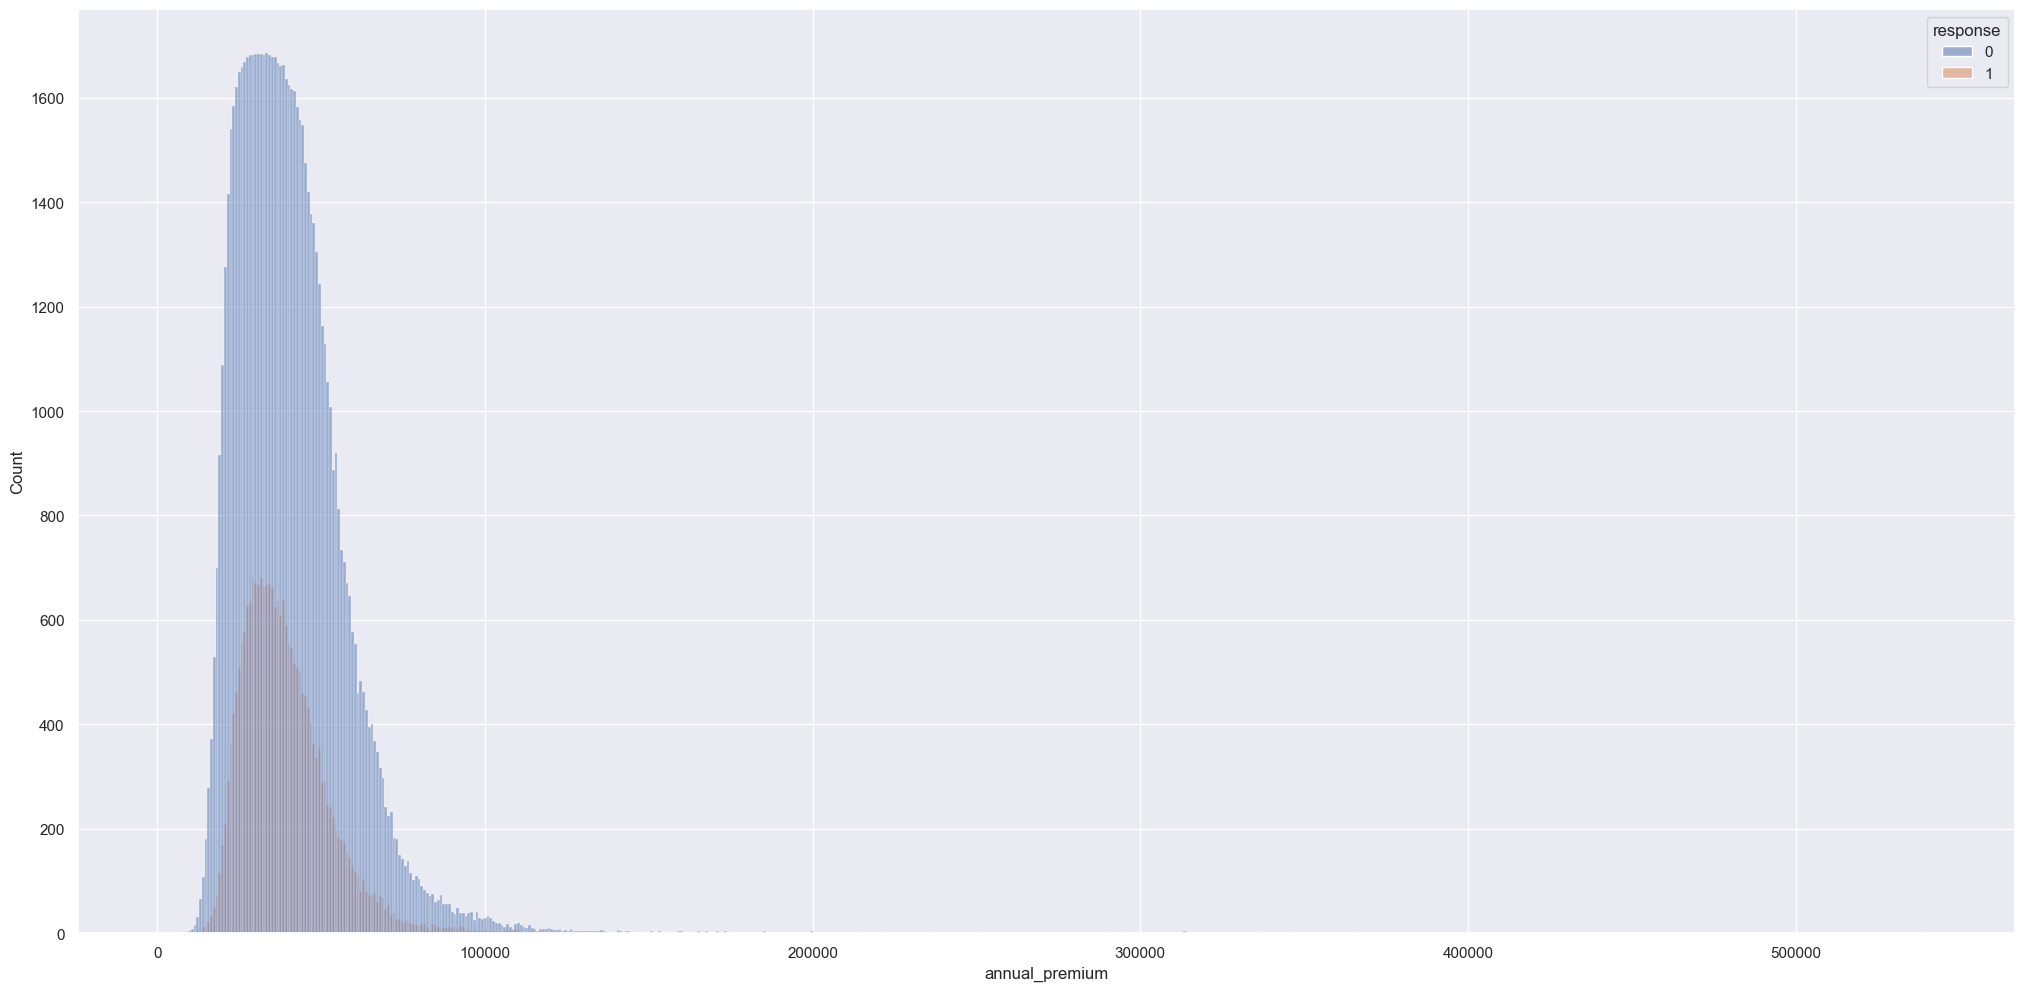

In [35]:
aux = df4[['id','previously_insured', 'annual_premium', 'response']].groupby(['annual_premium', 'previously_insured', 'response']).count().reset_index()

sns.histplot(aux, x='annual_premium', hue='response');

#### Variável: Vintage -> annual_premium

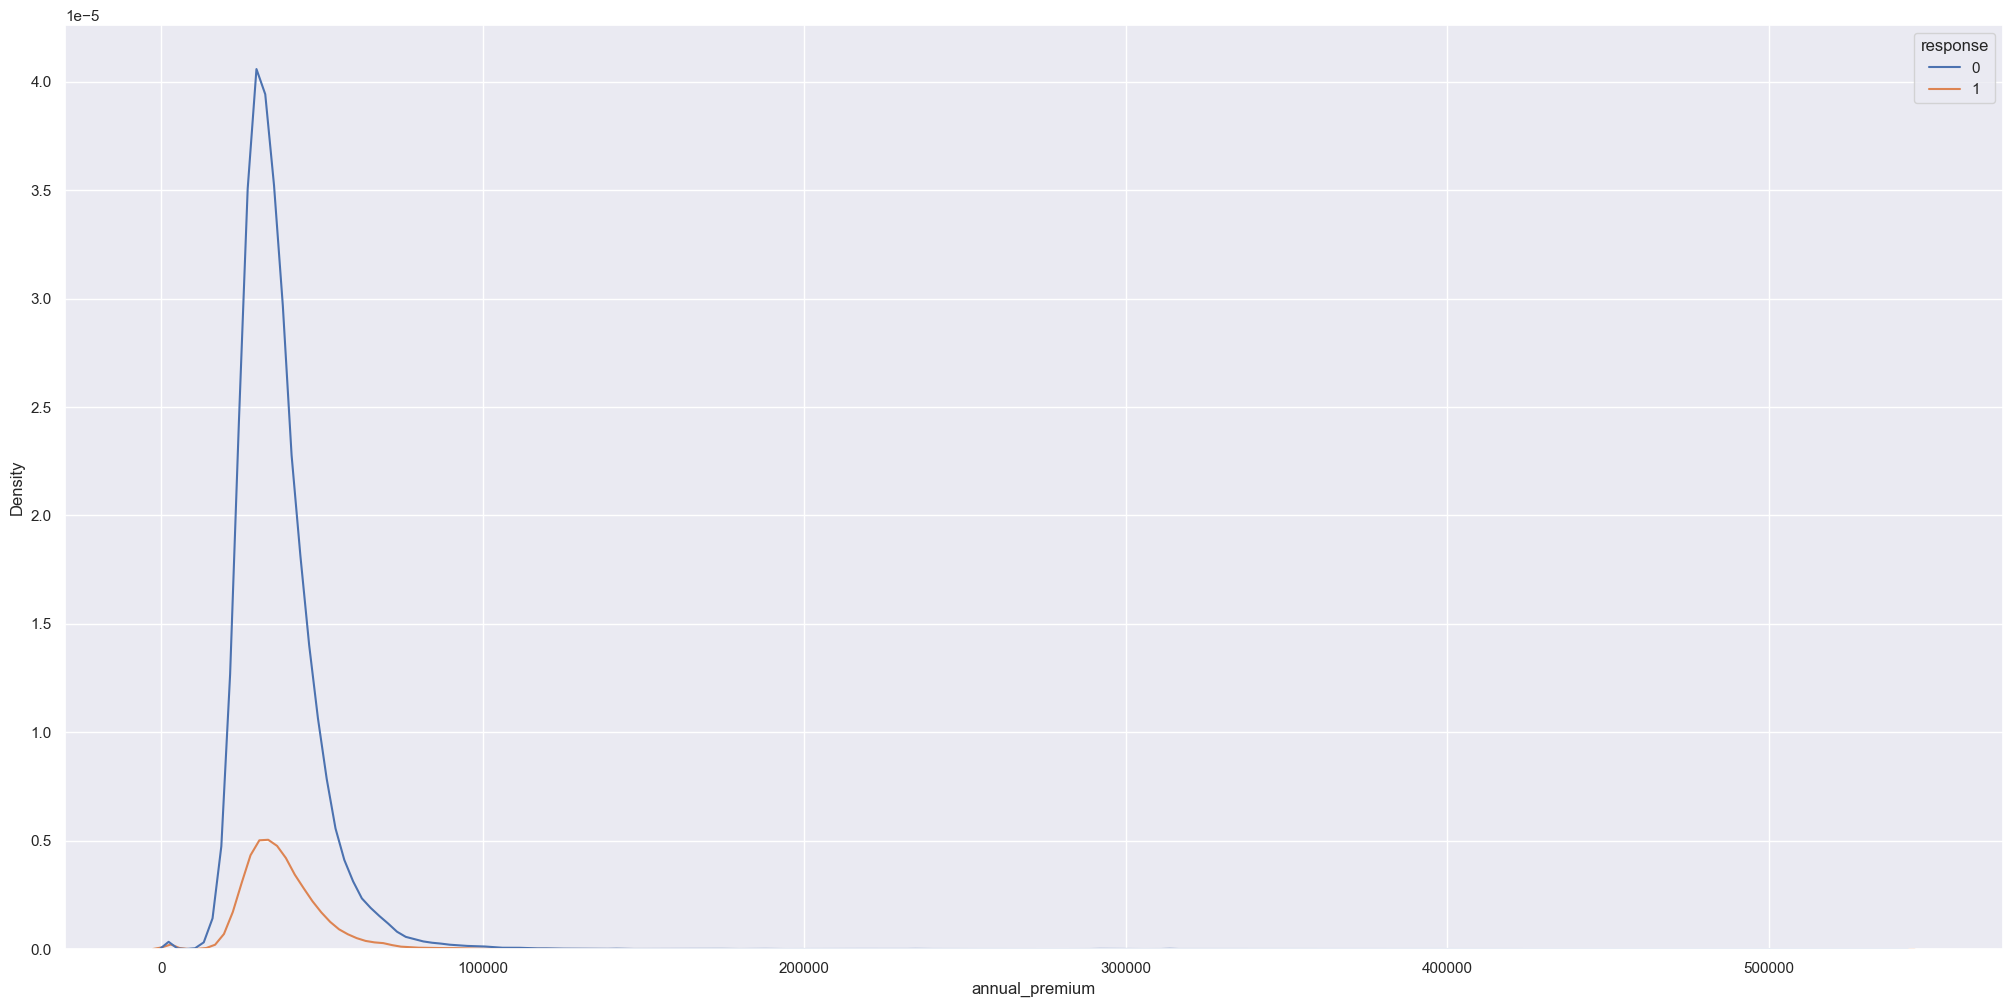

In [36]:
aux = df4[['id', 'vintage', 'annual_premium', 'response']].groupby(['annual_premium', 'vintage', 'response']).count().reset_index()

sns.kdeplot(aux, x='annual_premium', hue='response');

#### Variável: driving_license -> annual_premium

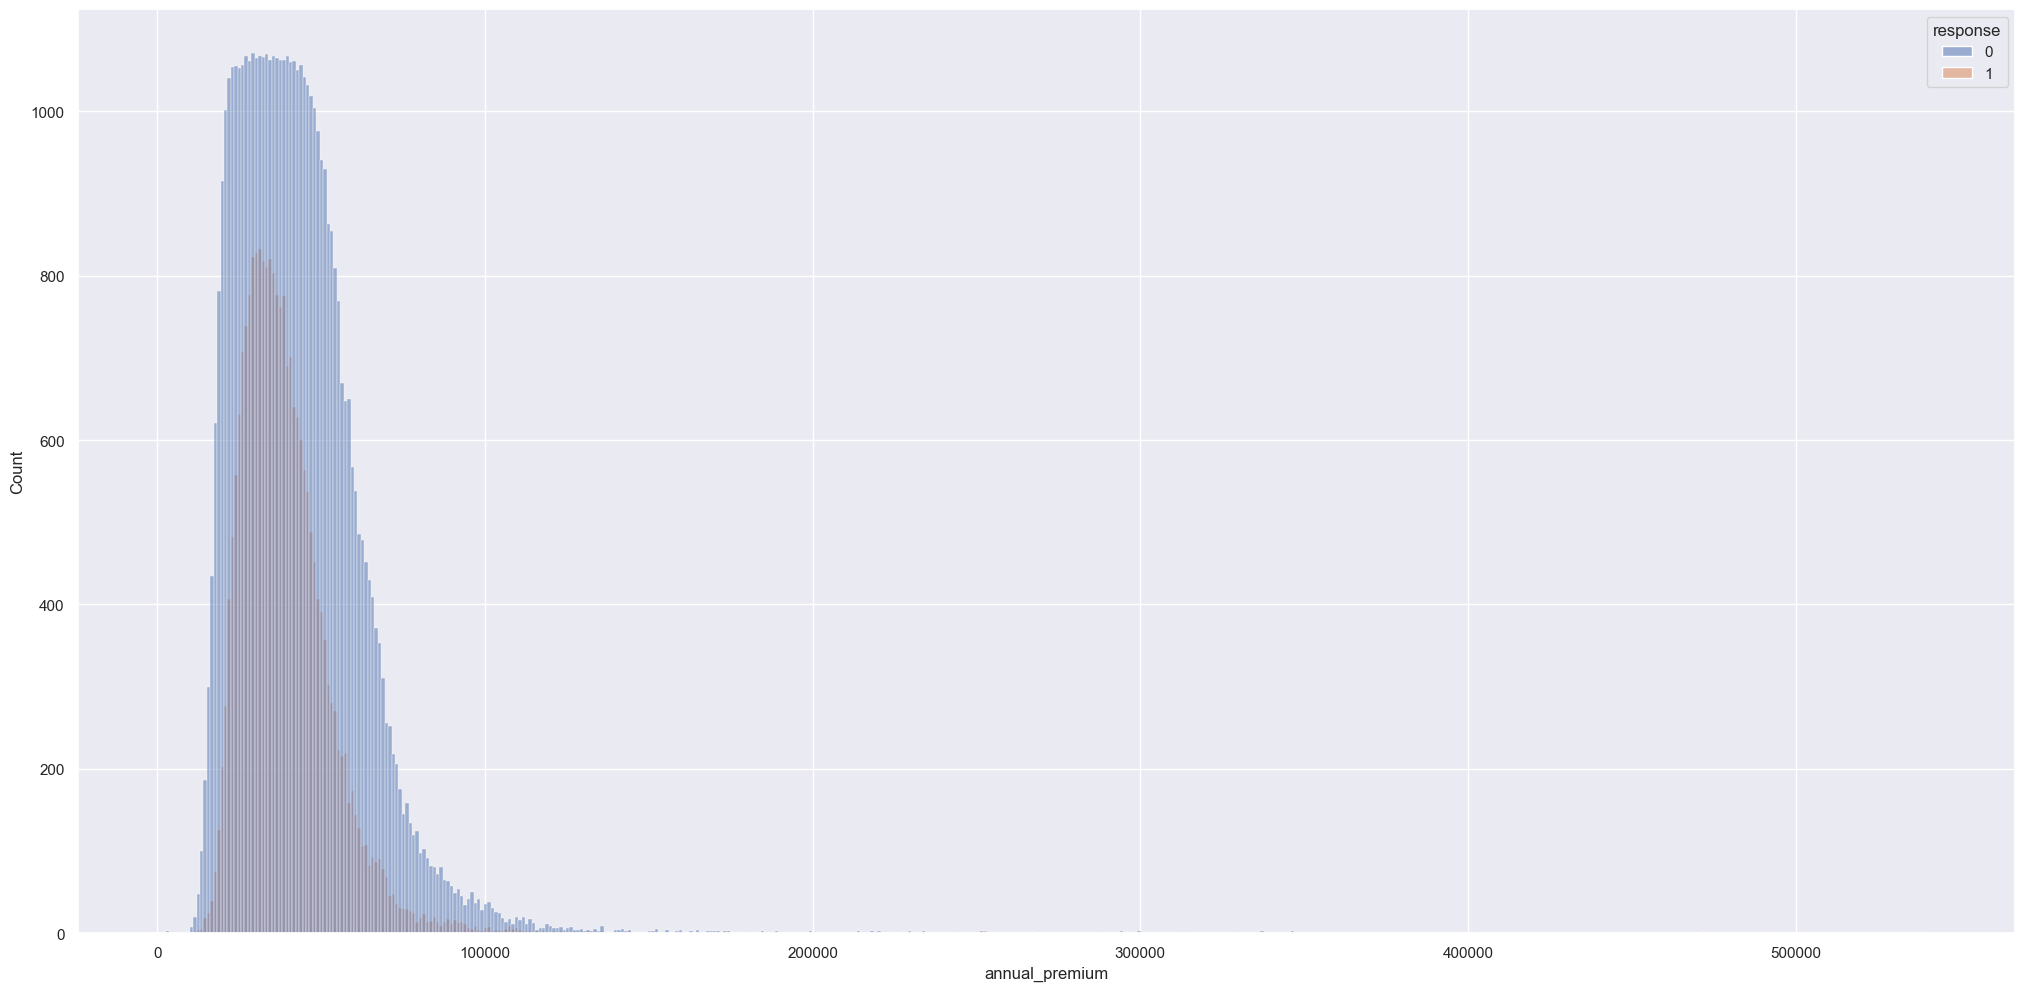

In [37]:
aux = df4[['id', 'driving_license', 'annual_premium', 'response']].groupby(['annual_premium', 'driving_license', 'response']).count().reset_index()

sns.histplot(aux, x='annual_premium', hue='response');

#### Variável: policy_sales_channel -> annual_premium

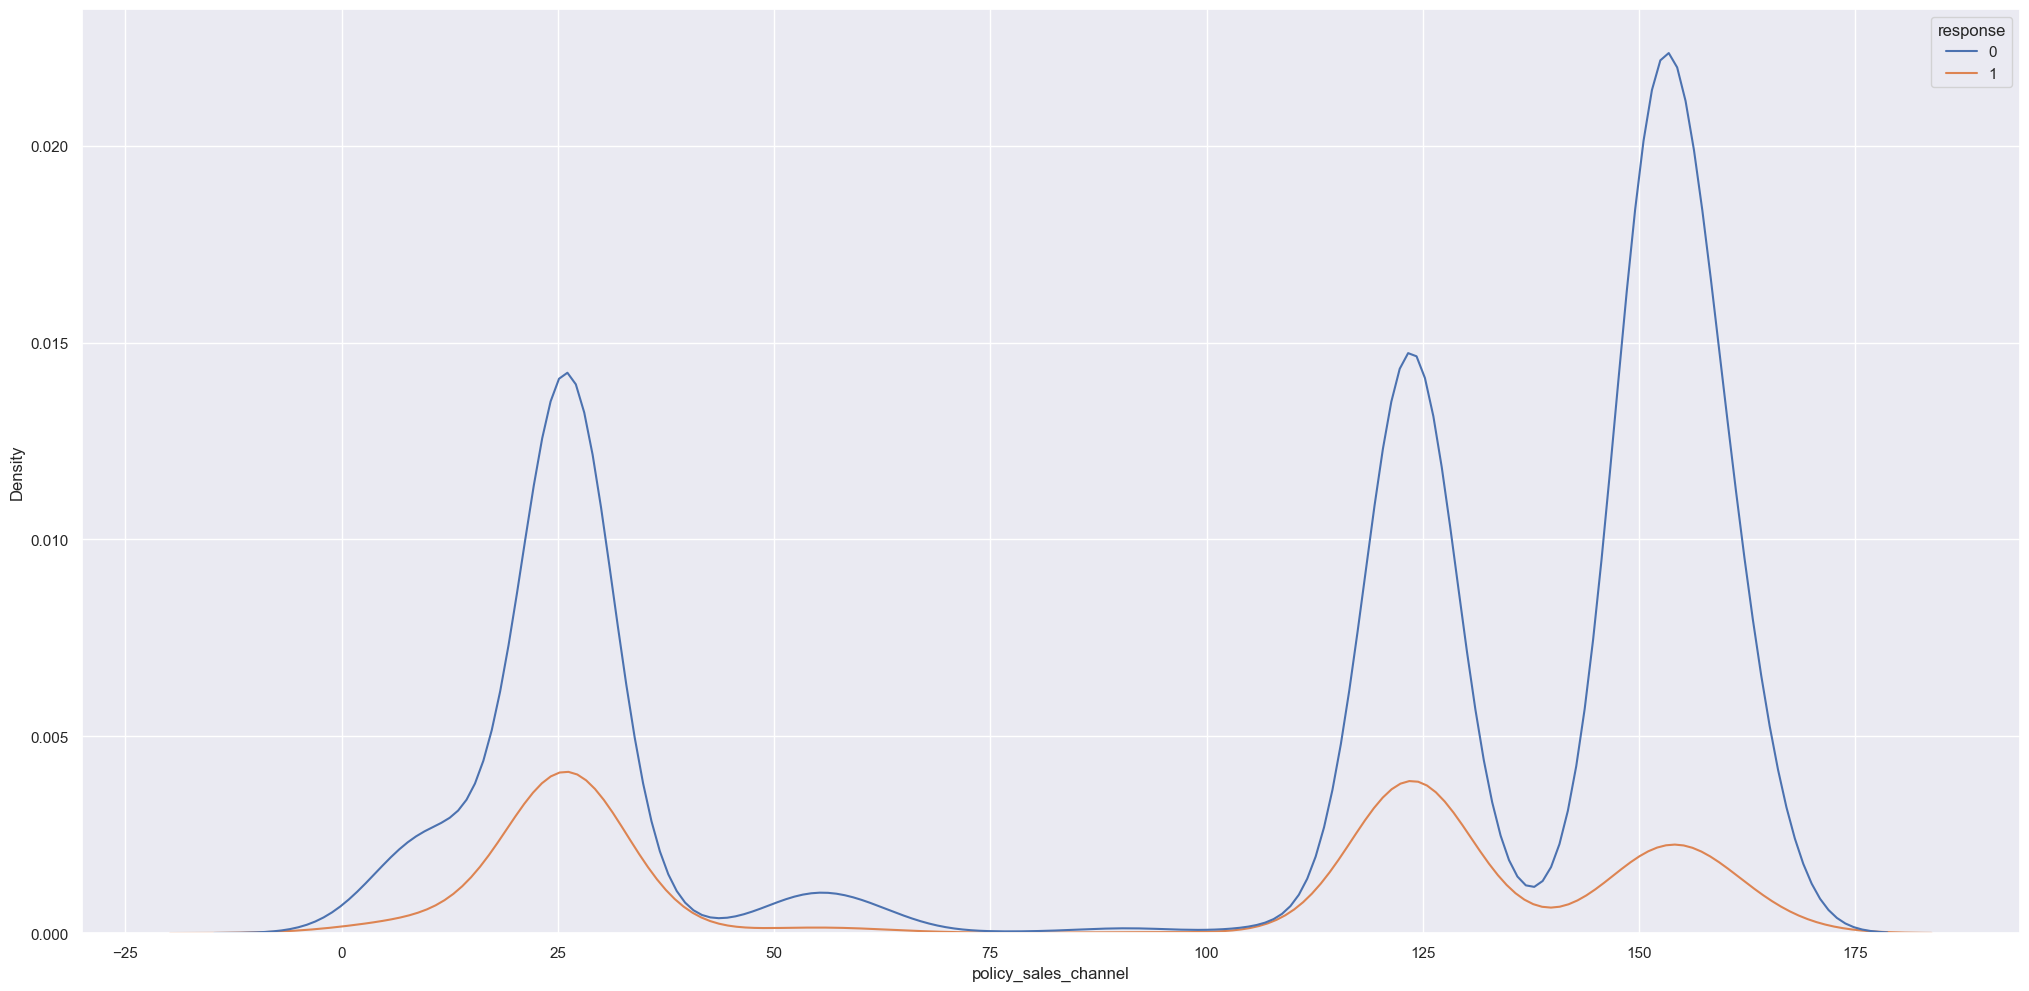

In [38]:
aux = df4[['id', 'annual_premium', 'policy_sales_channel', 'response']].groupby(['annual_premium', 'policy_sales_channel', 'response']).count().reset_index()

sns.kdeplot(aux, x='policy_sales_channel', hue='response');

#### Variável: region code -> annual_premium

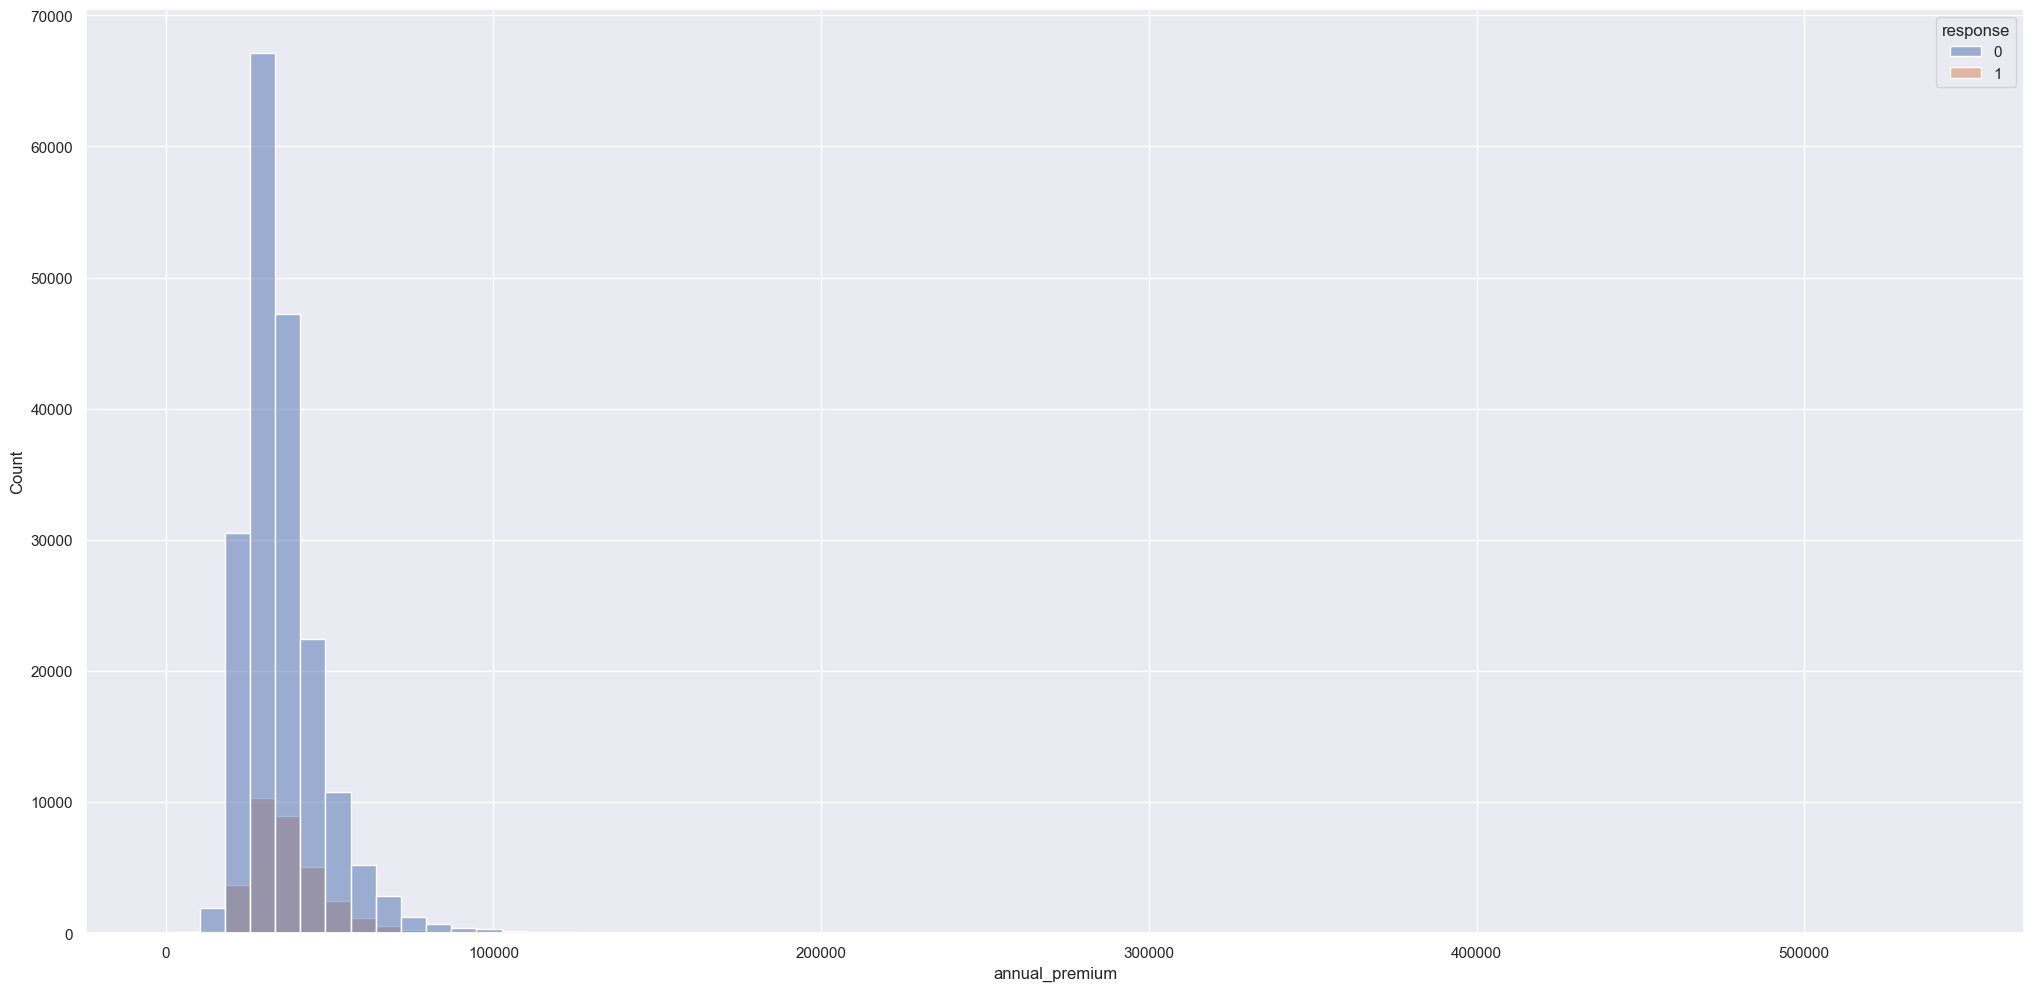

In [39]:
aux = df4[['id', 'annual_premium', 'region_code', 'response']].groupby(['annual_premium', 
                                                                        'region_code',
                                                                        'response']).count().reset_index()

sns.histplot(aux, x='annual_premium', hue='response', bins=70);

### vintage

#### Variável: previously_insured -> vintage

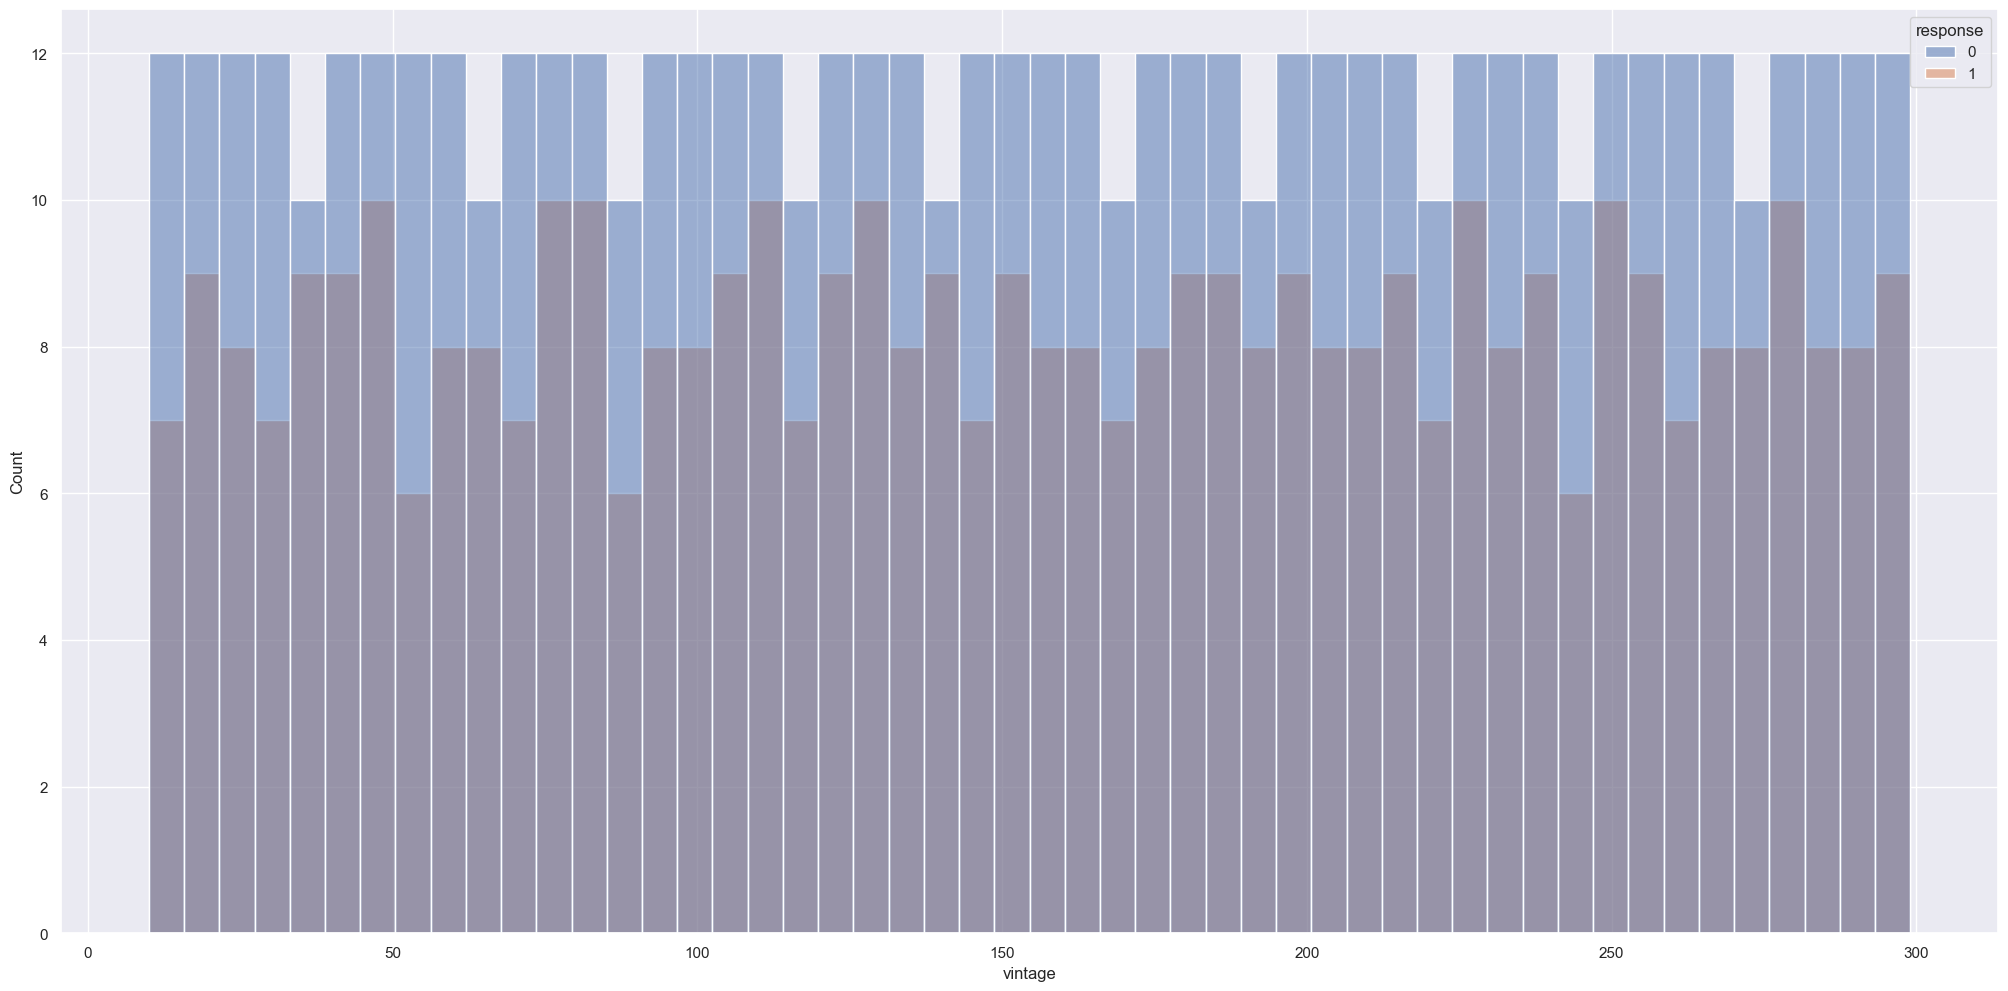

In [40]:
aux = df4[['id', 'vintage', 'previously_insured', 'response']].groupby(['vintage', 'previously_insured', 'response']).count().reset_index()

sns.histplot(aux, x='vintage', hue='response', bins=50);

#### Variável: driving_license -> vintage

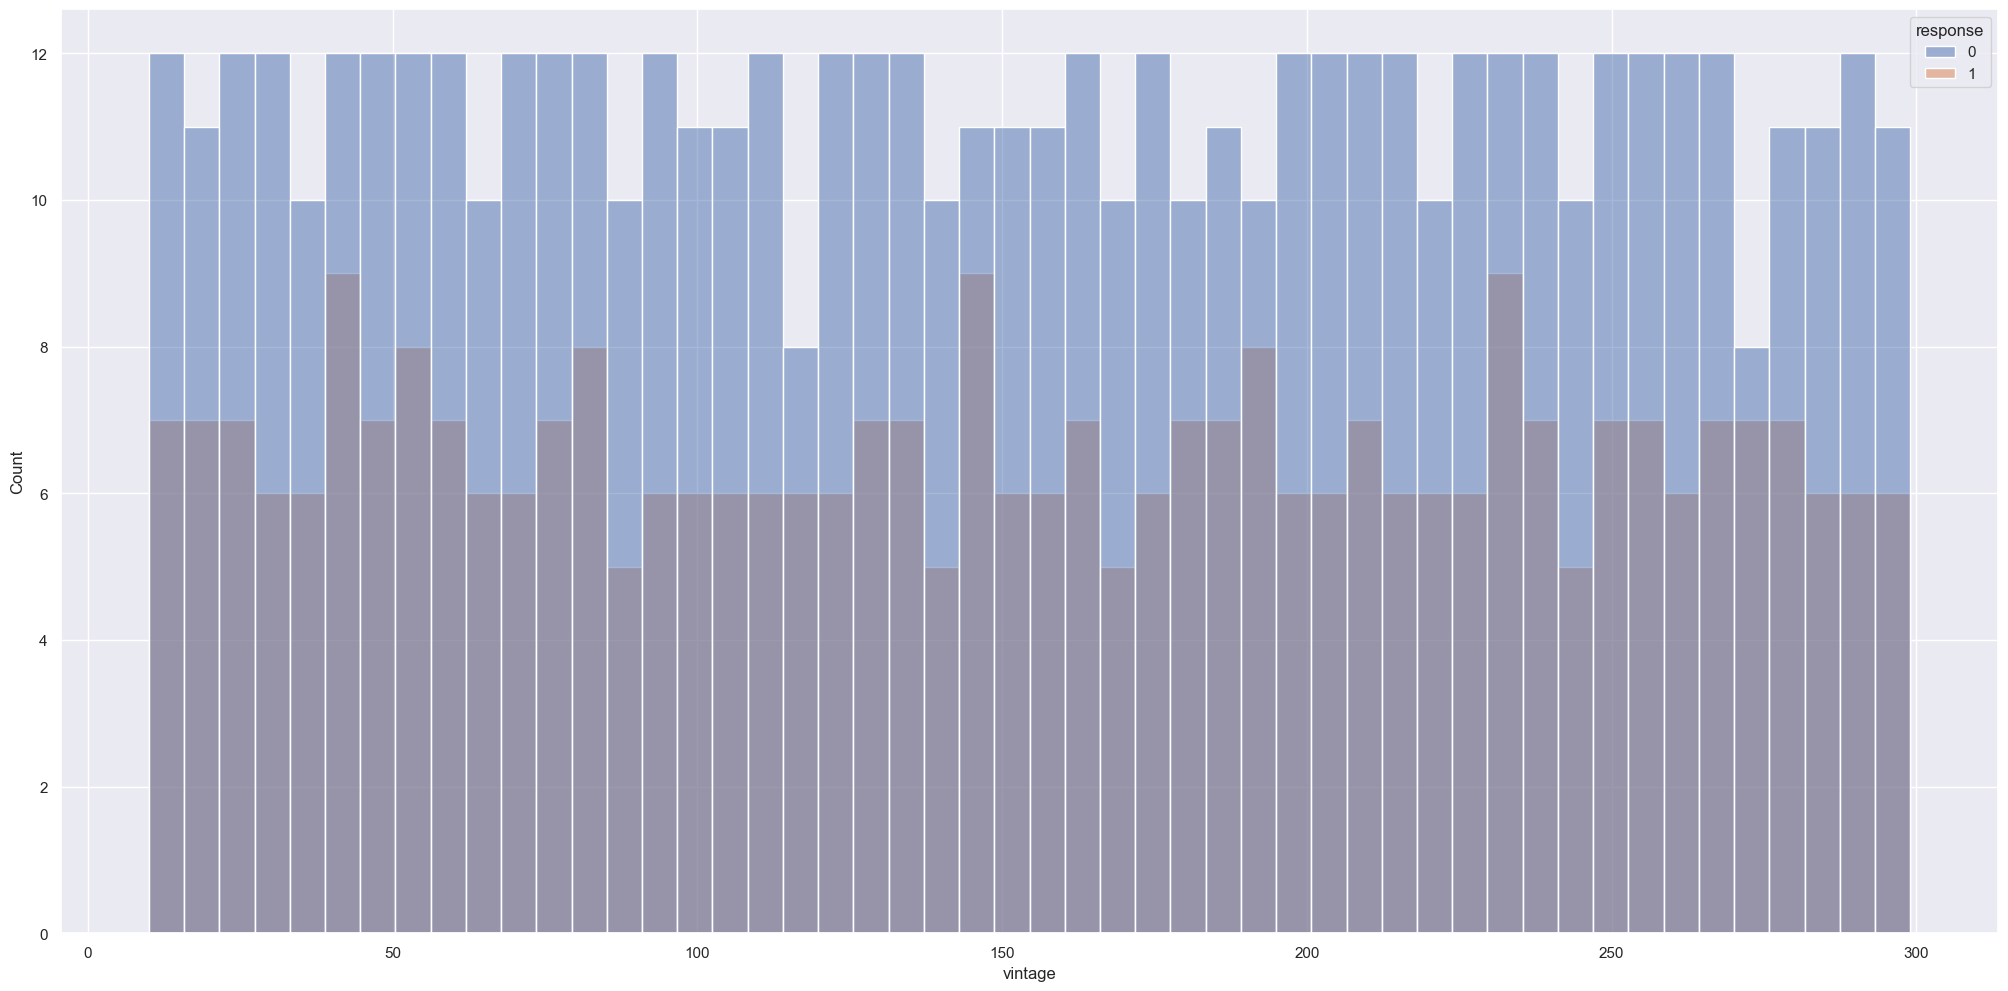

In [41]:
aux = df4[['id', 'vintage', 'driving_license', 'response']].groupby(['vintage', 'driving_license', 'response']).count().reset_index()

sns.histplot(aux, x='vintage', hue='response', bins=50);

#### Variável: policy_sales_channel -> vintage

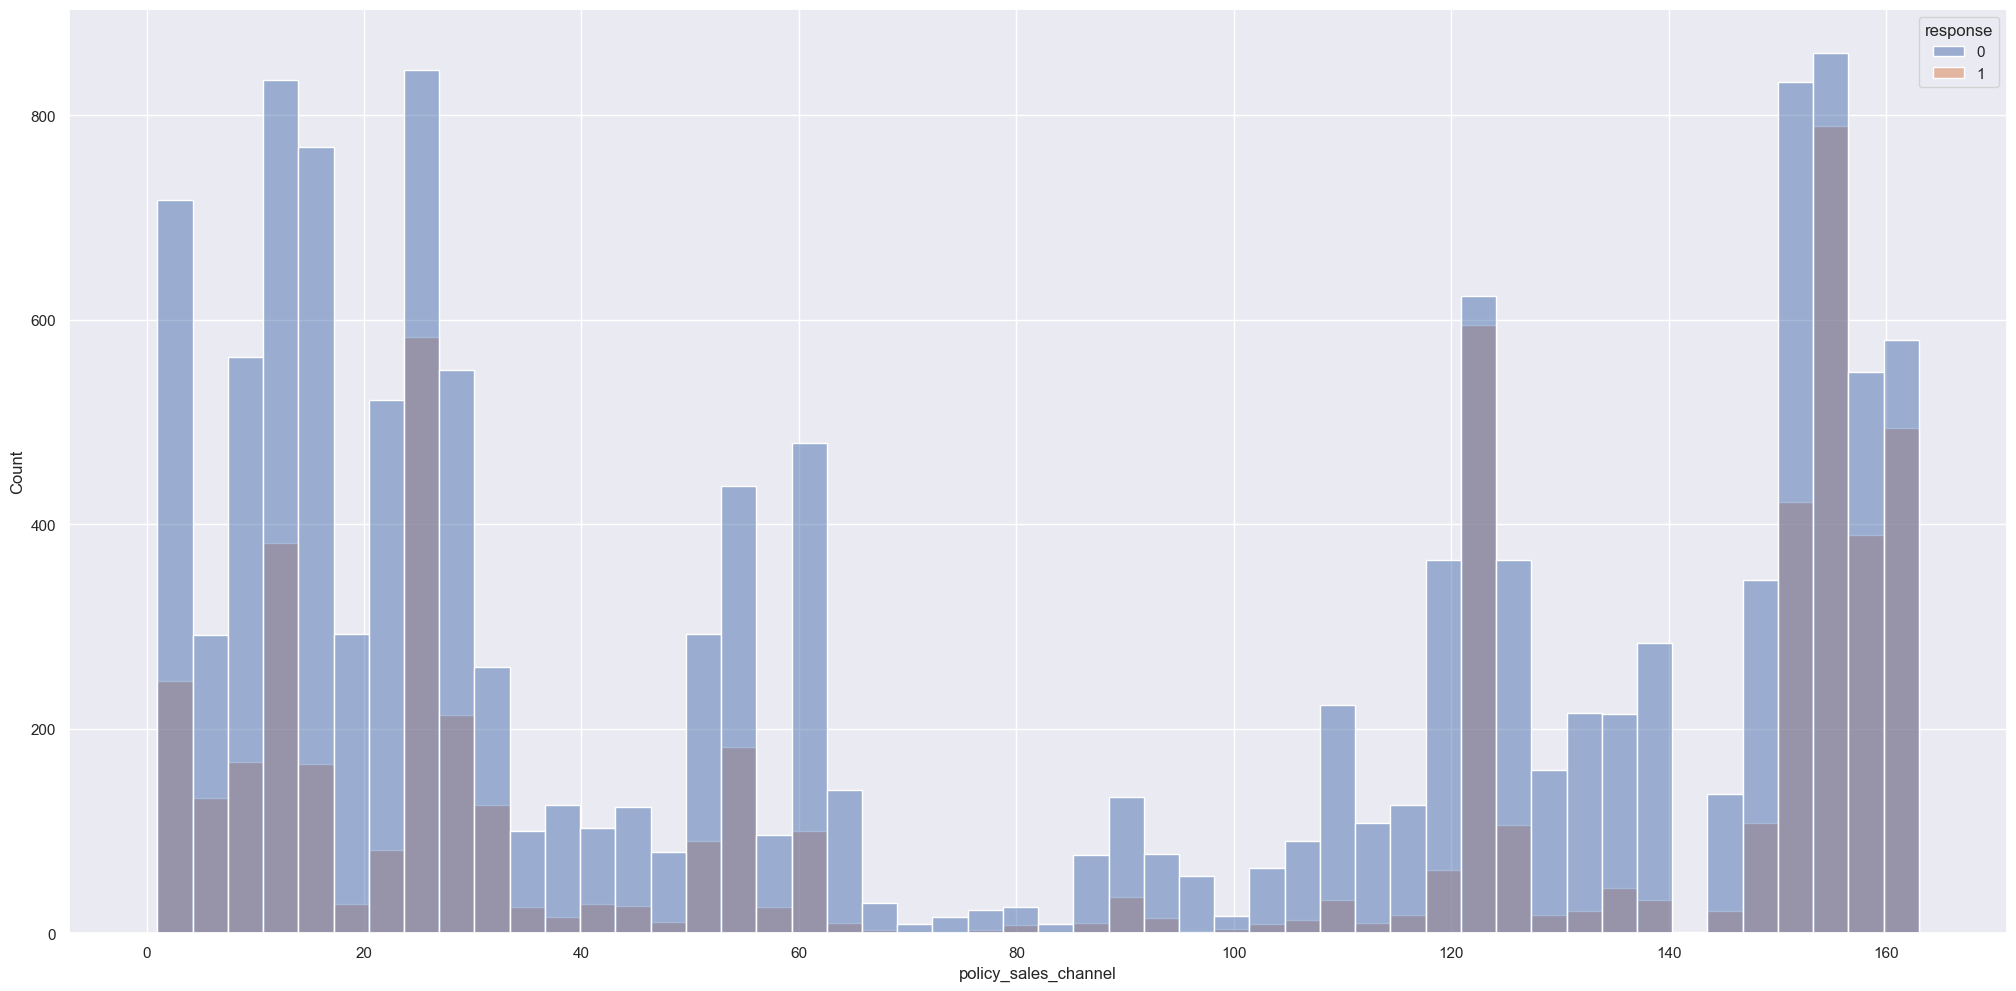

In [42]:
aux = df4[['id', 'vintage', 'policy_sales_channel', 'response']].groupby(['vintage', 'policy_sales_channel', 'response']).count().reset_index()

sns.histplot(aux, x='policy_sales_channel', hue='response', bins=50);

#### Variável: region_code -> vintage

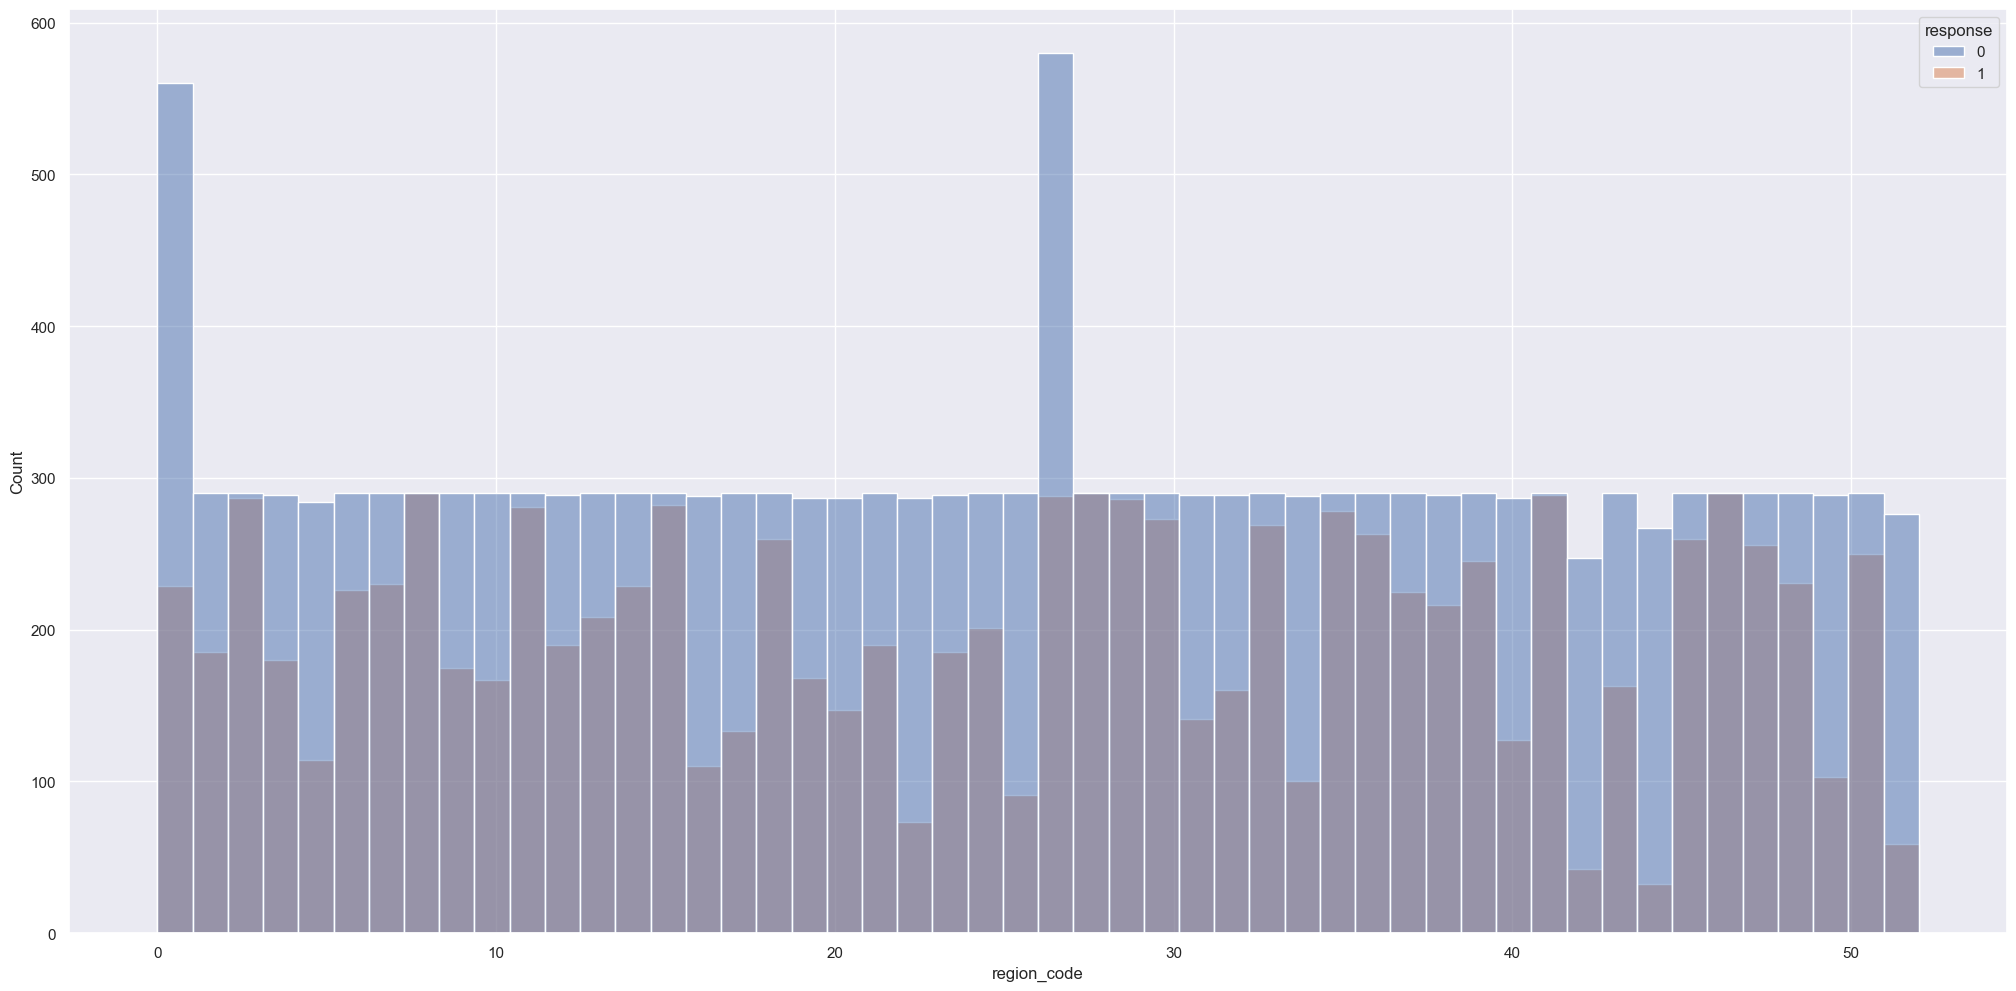

In [43]:
aux = df4[['id', 'vintage', 'region_code', 'response']].groupby(['vintage', 'region_code', 'response']).count().reset_index()

sns.histplot(aux, x='region_code', hue='response', bins=50);

## 4.3 Validação de Hipóteses

**H1.** Clientes do gênero masculino aceitam mais o seguro veicular do que o gênero feminino.

**RESPOSTA:** Essa afirmação é verdadeira.

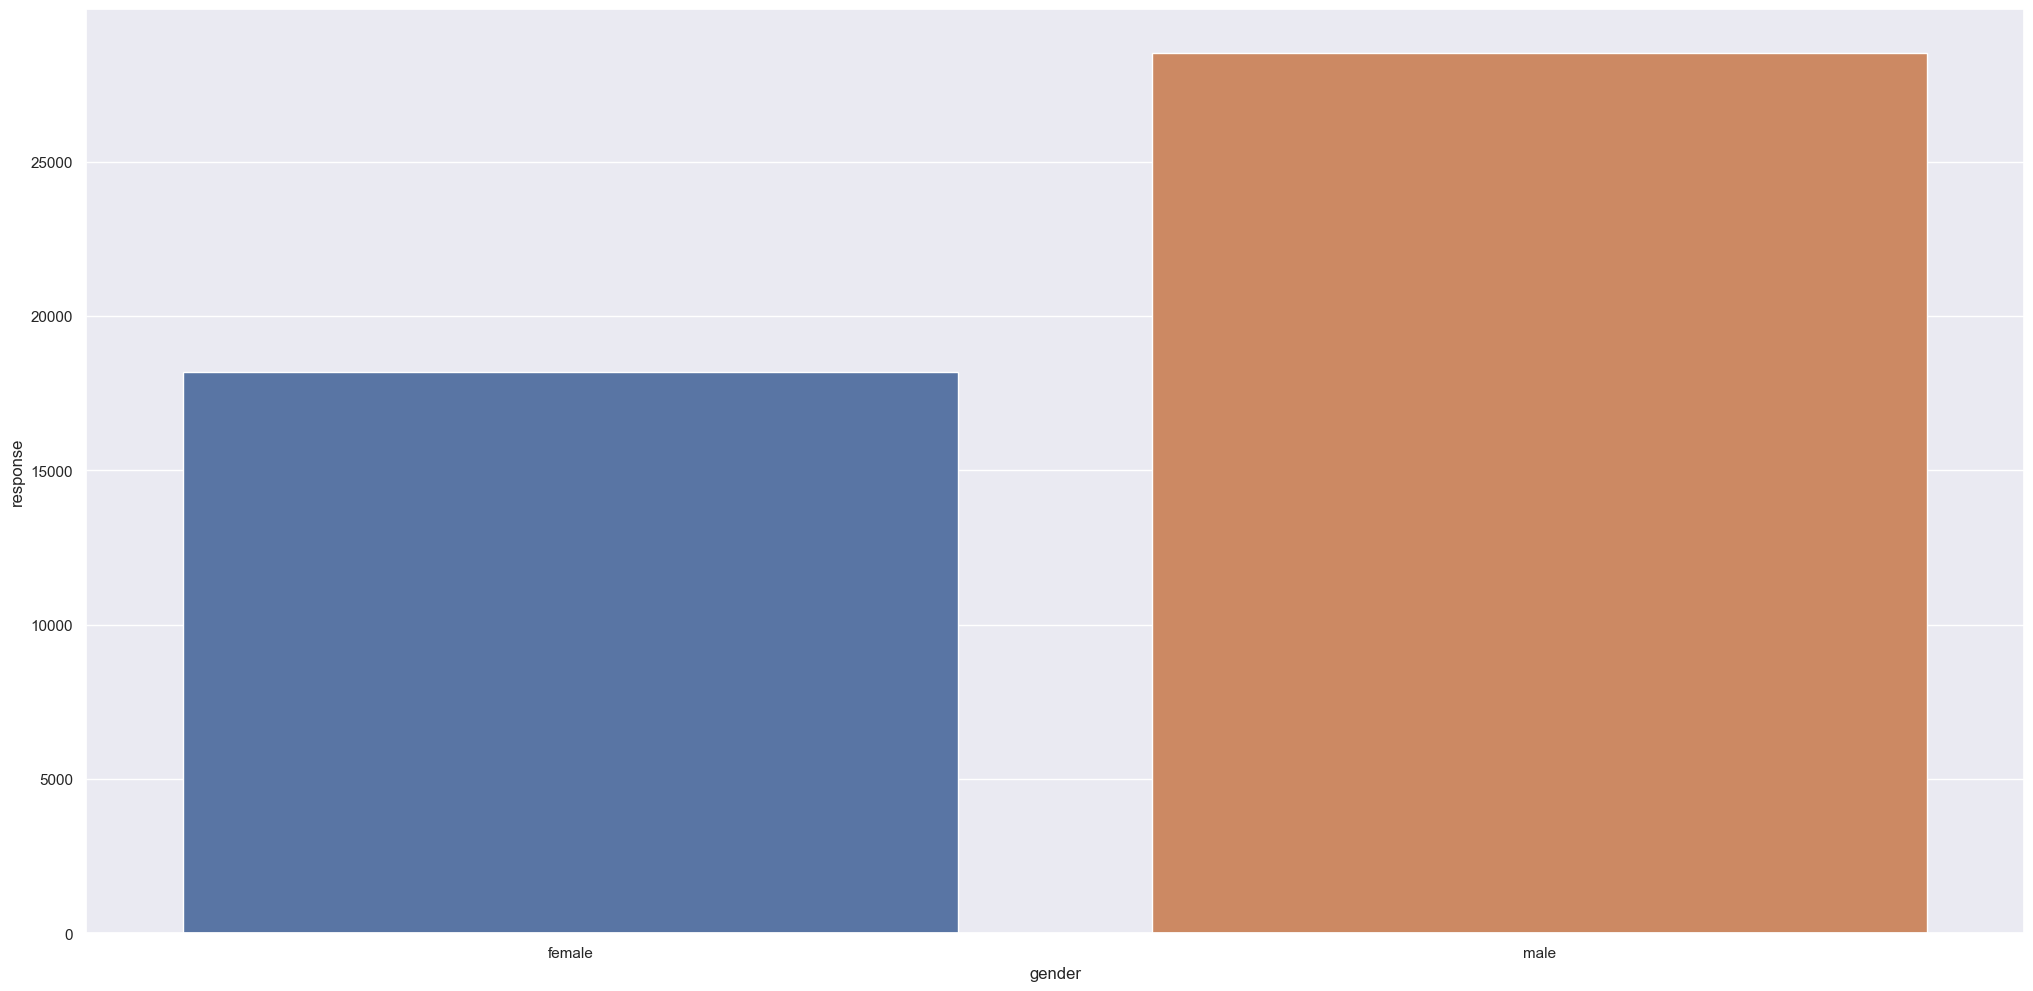

In [49]:
# Organização dos dados
df_h1 = df4[['gender', 'response']][df4['response'] == 1].groupby('gender').count().reset_index()

# Construção do gráfico para visualização
sns.barplot(x='gender', y='response', data=df_h1);

**H2.** Clientes do gênero feminino rejeitam mais o seguro veicular do que o gênero masculino.

**RESPOSTA:** Essa afirmação é falsa. Os clientes do gênero masculino rejeitam mais o seguro veicular do que as mulheres, por uma pequena diferença de 20000 clientes.

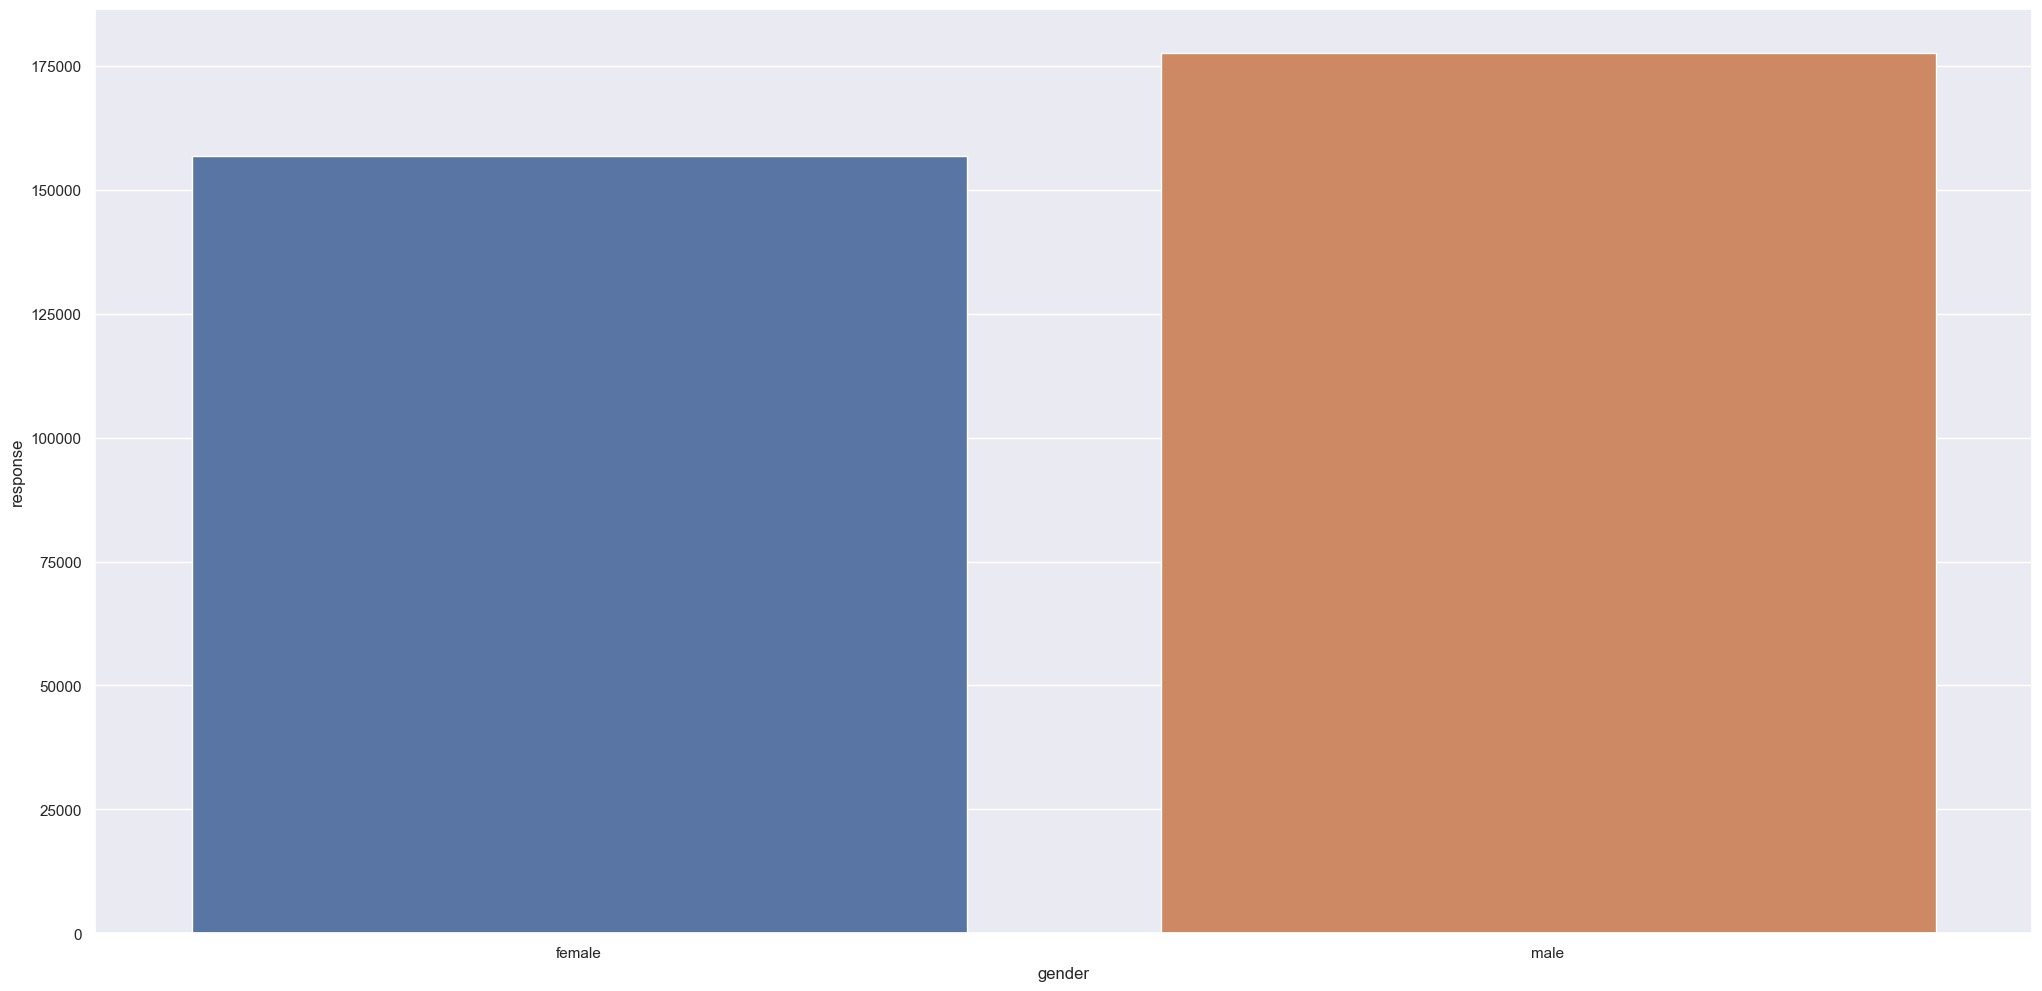

In [50]:
# Organização dos dados
df_h2 = df4[['gender', 'response']][df4['response'] == 0].groupby('gender').count().reset_index()

# Construção do gráfico para visualização
sns.barplot(x='gender', y='response', data=df_h2);

**H3.** Clientes que possuem Driving License aceitam mais o seguro do que os clientes que não possuem.

**RESPOSTA:** Essa afirmação é verdadeira! As pessoas que possuem o Driving License e que aceitam o seguro de automóvel é tão grande que as pessoas qua aceitam e não possuem a Driving License e aceitam o seguro se tornam desprezíveis.

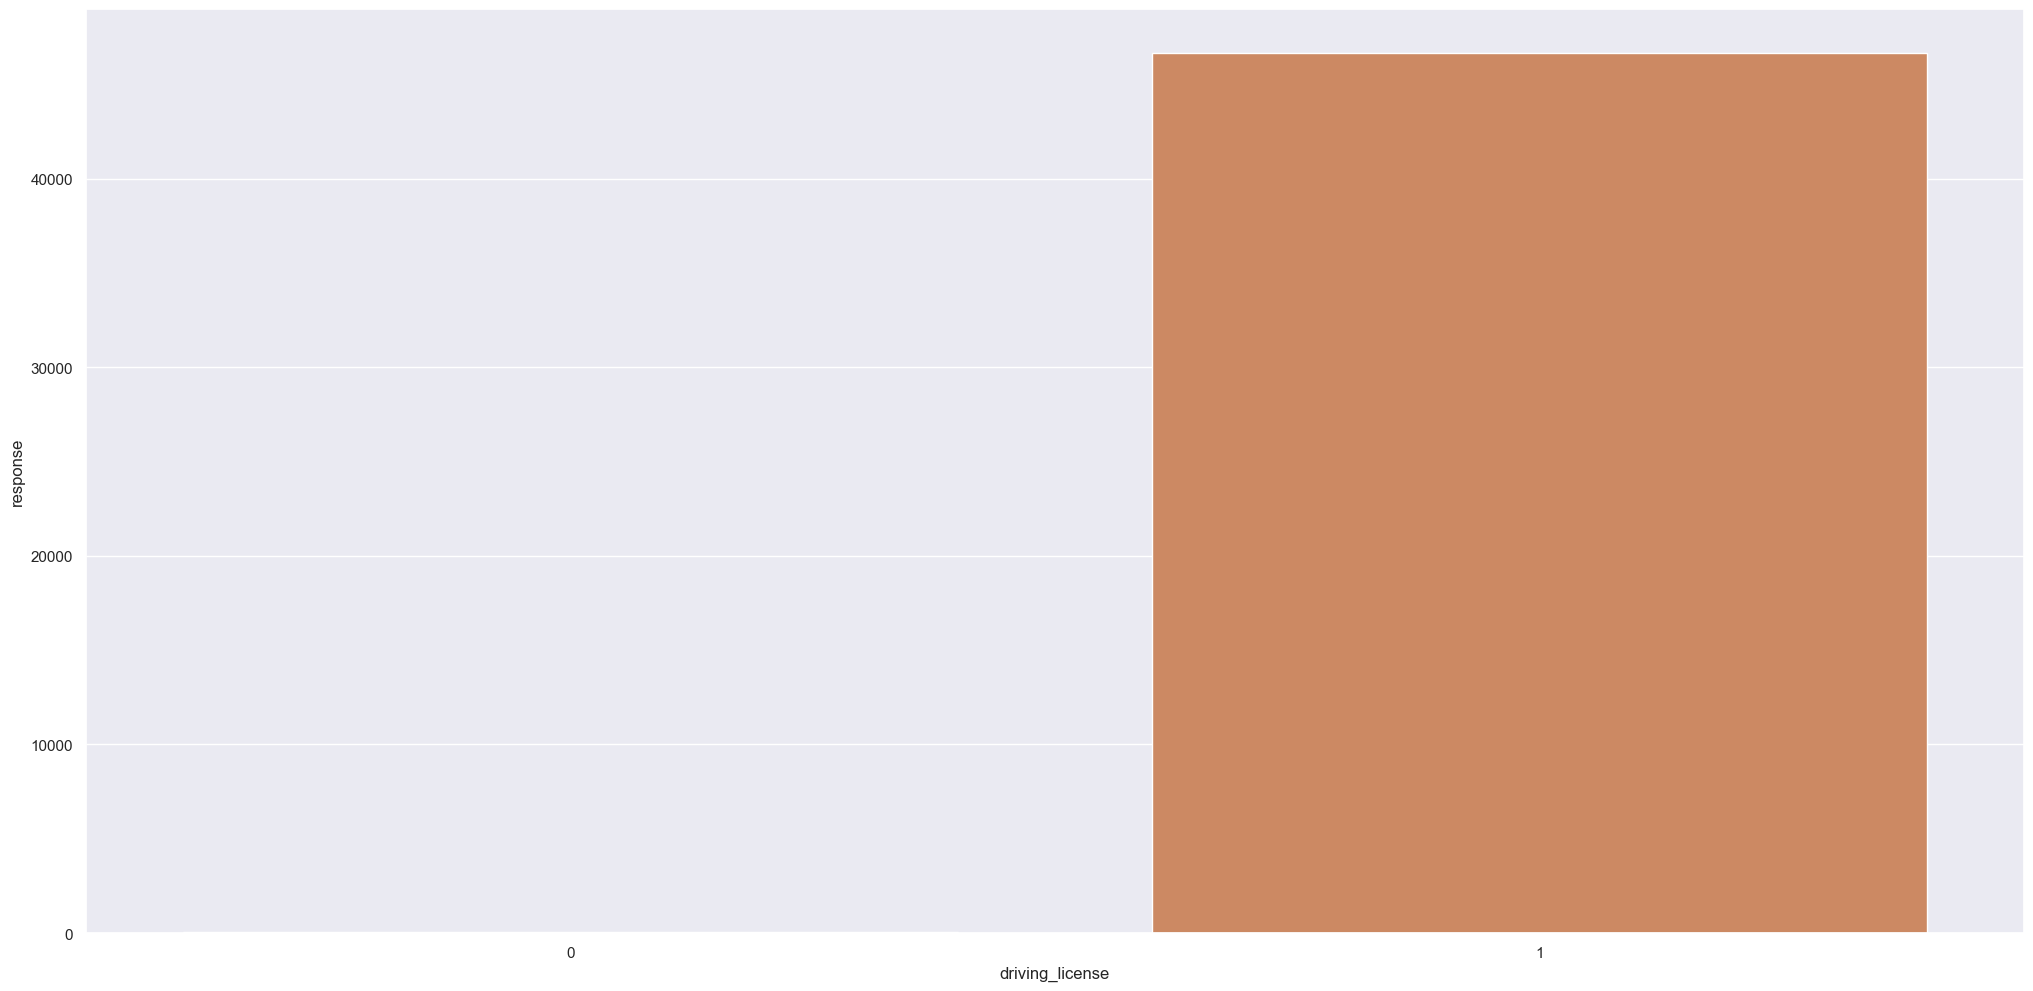

In [51]:
df_h3 = df4[['driving_license', 'response']][df4['response'] == 1].groupby('driving_license').count().reset_index()


sns.barplot(x='driving_license', y='response', data=df_h3);

**H4.** Clientes que possuem veículos com menos de 1 ano aceitam menos o seguro veicular.

**RESPOSTA**: Essa afirmação é falsa. Clientes veículos com de mais de 2 anos aceitam menos o seguro veicular.

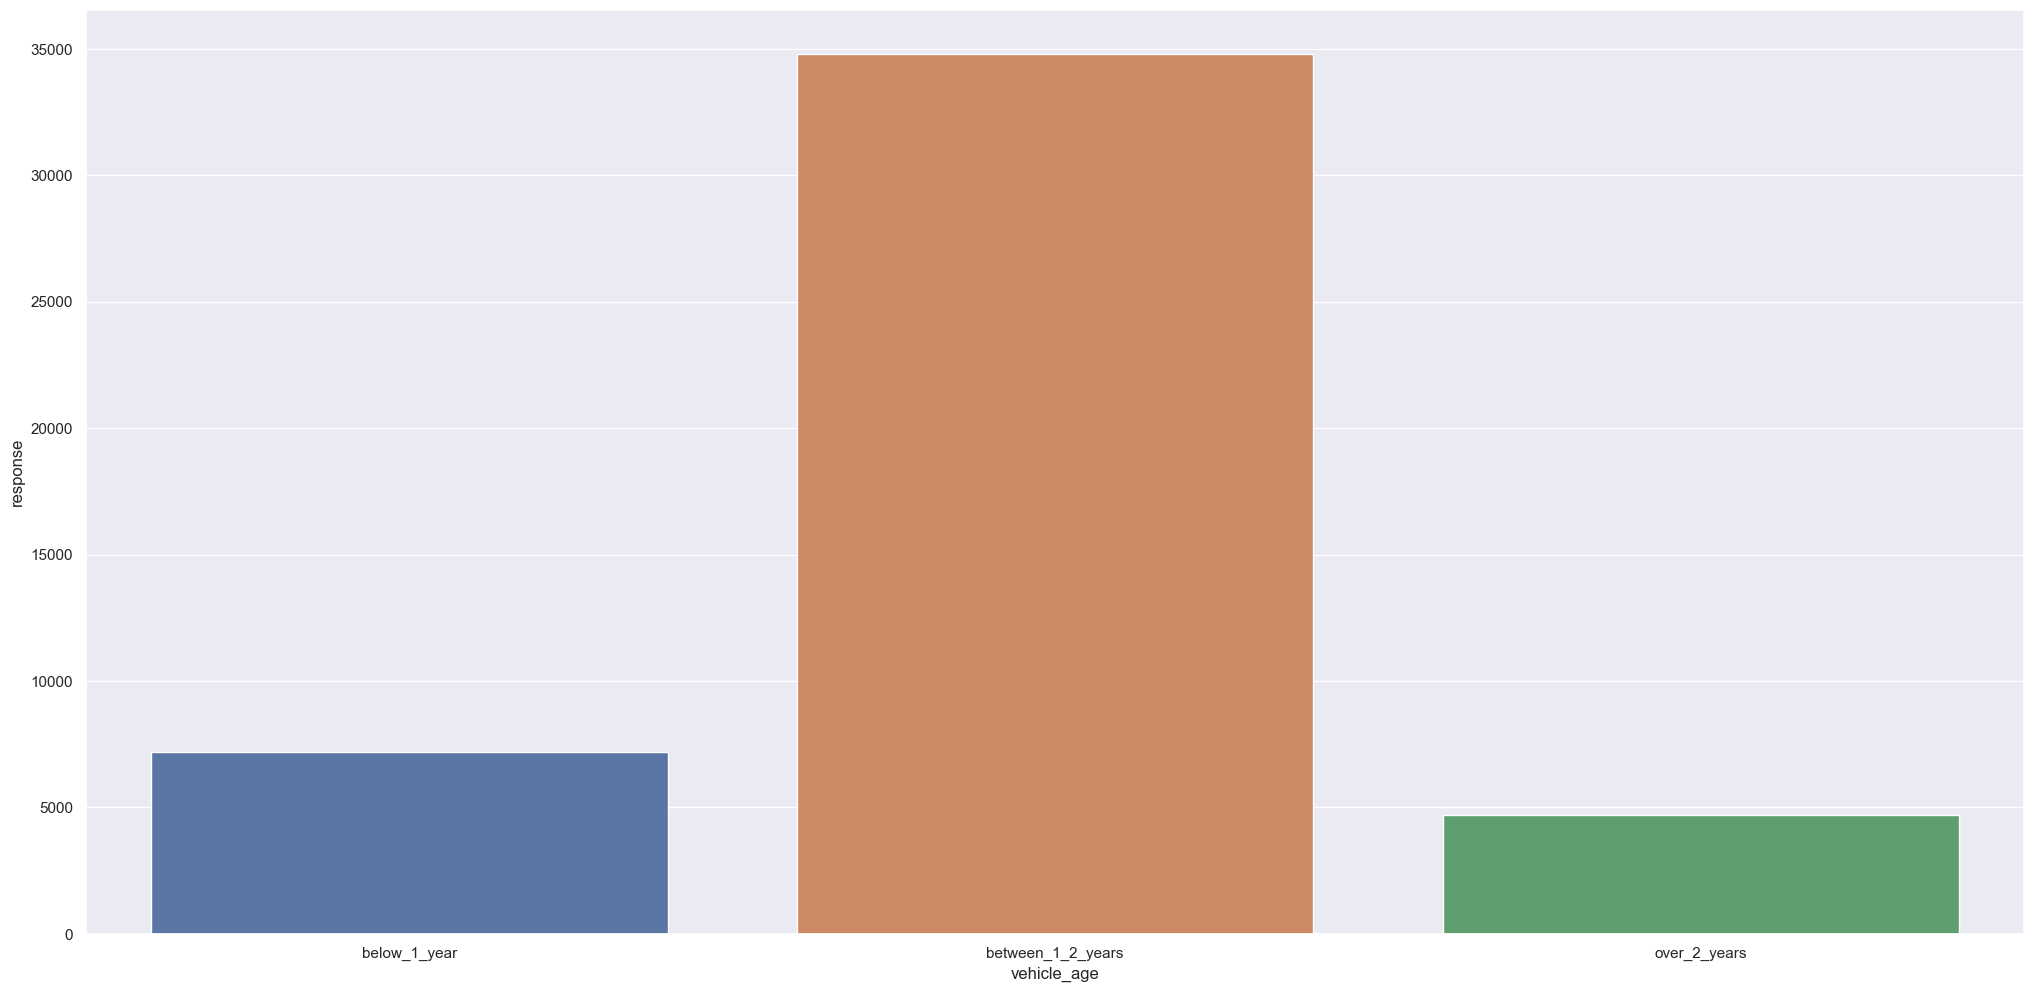

In [52]:
df_h4 = df4[['vehicle_age', 'response']][df4['response'] == 1].groupby('vehicle_age').count().reset_index()

sns.barplot(x='vehicle_age', y='response', data=df_h4);

**H5.** Clientes que possuem veículos com mais de 2 anos aceitam mais o seguro veicular.

**RESPOSTA:** Essa afirmação é Falsa! Cliente com o veículo que possui idade entre 1 e 2 anos aceitam mais o seguro veicular.

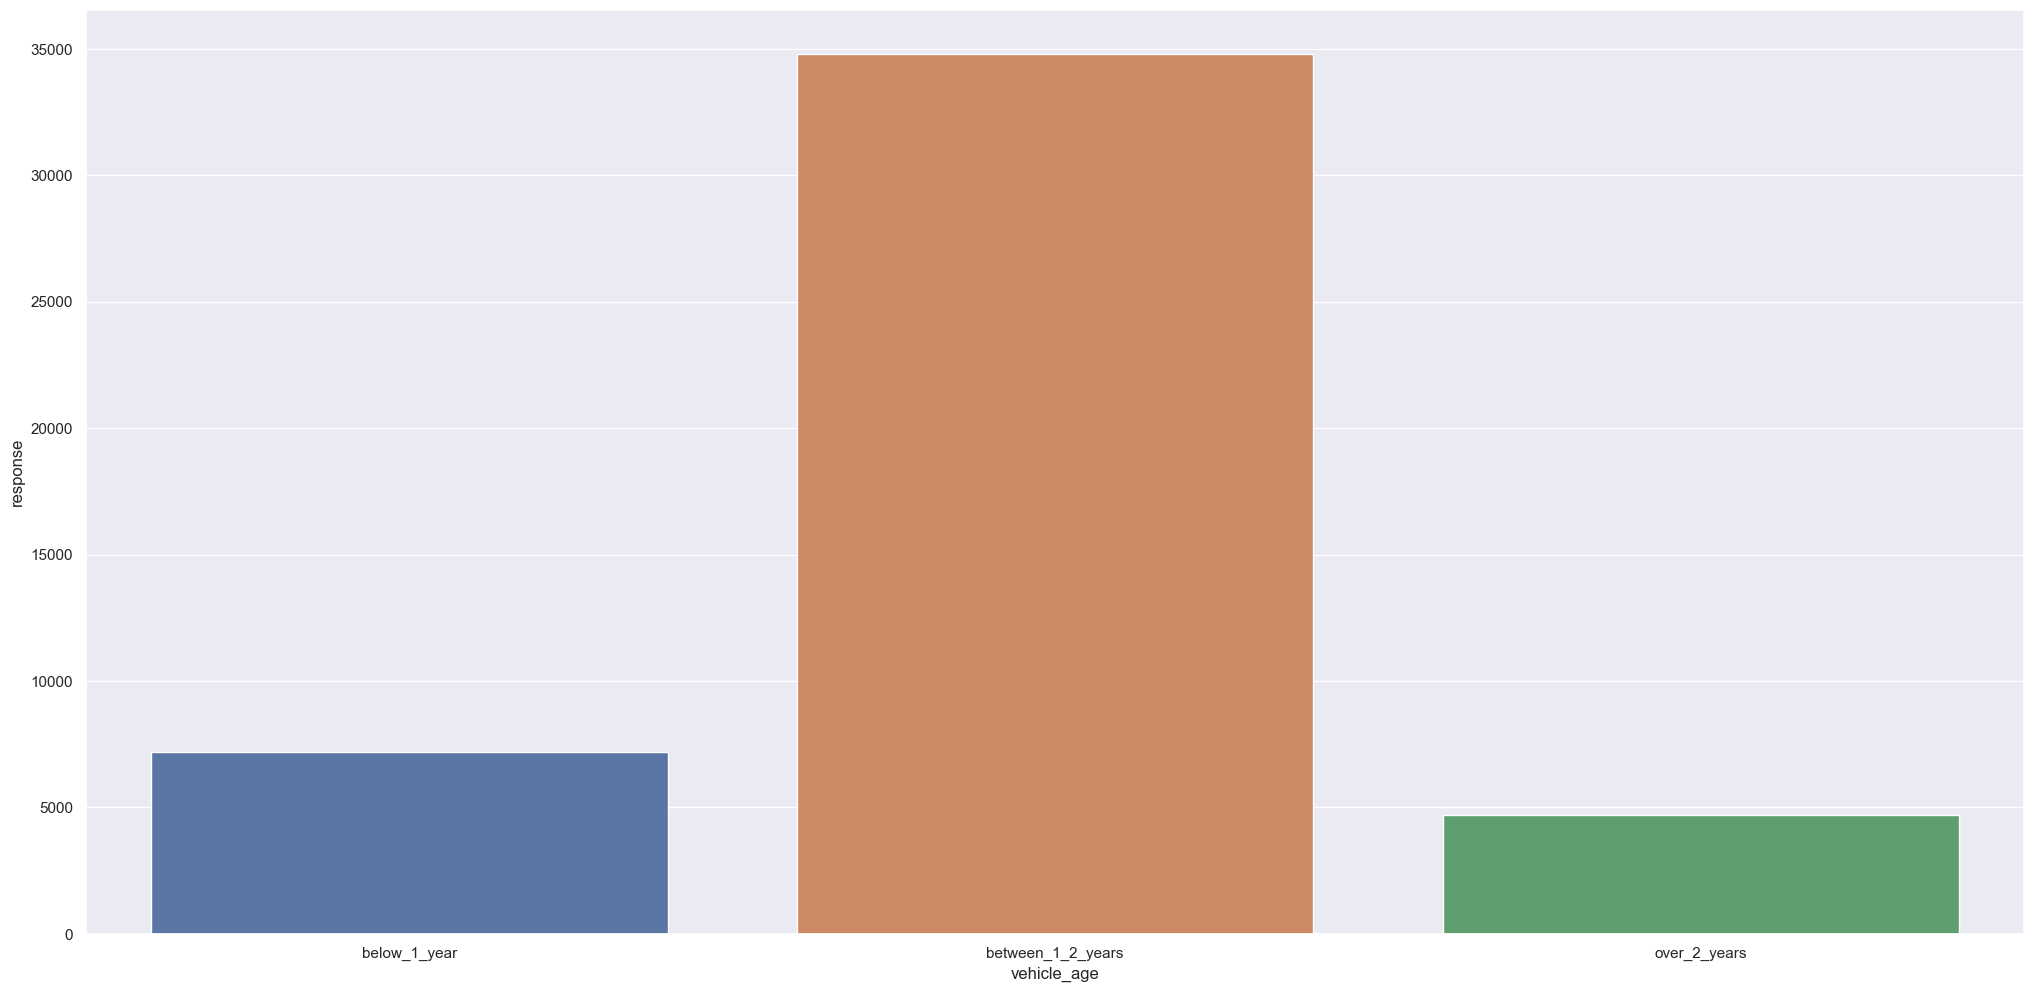

In [53]:
df_h5 = df4[['vehicle_age', 'response']][df4['response'] == 1].groupby('vehicle_age').count().reset_index()

sns.barplot(x='vehicle_age', y='response', data=df_h5);

**H6.** Clientes em que seus veículos já foram danificados aceitam mais o seguro veicular.

**RESPOSTA:** Essa afirmação é verdadeira.

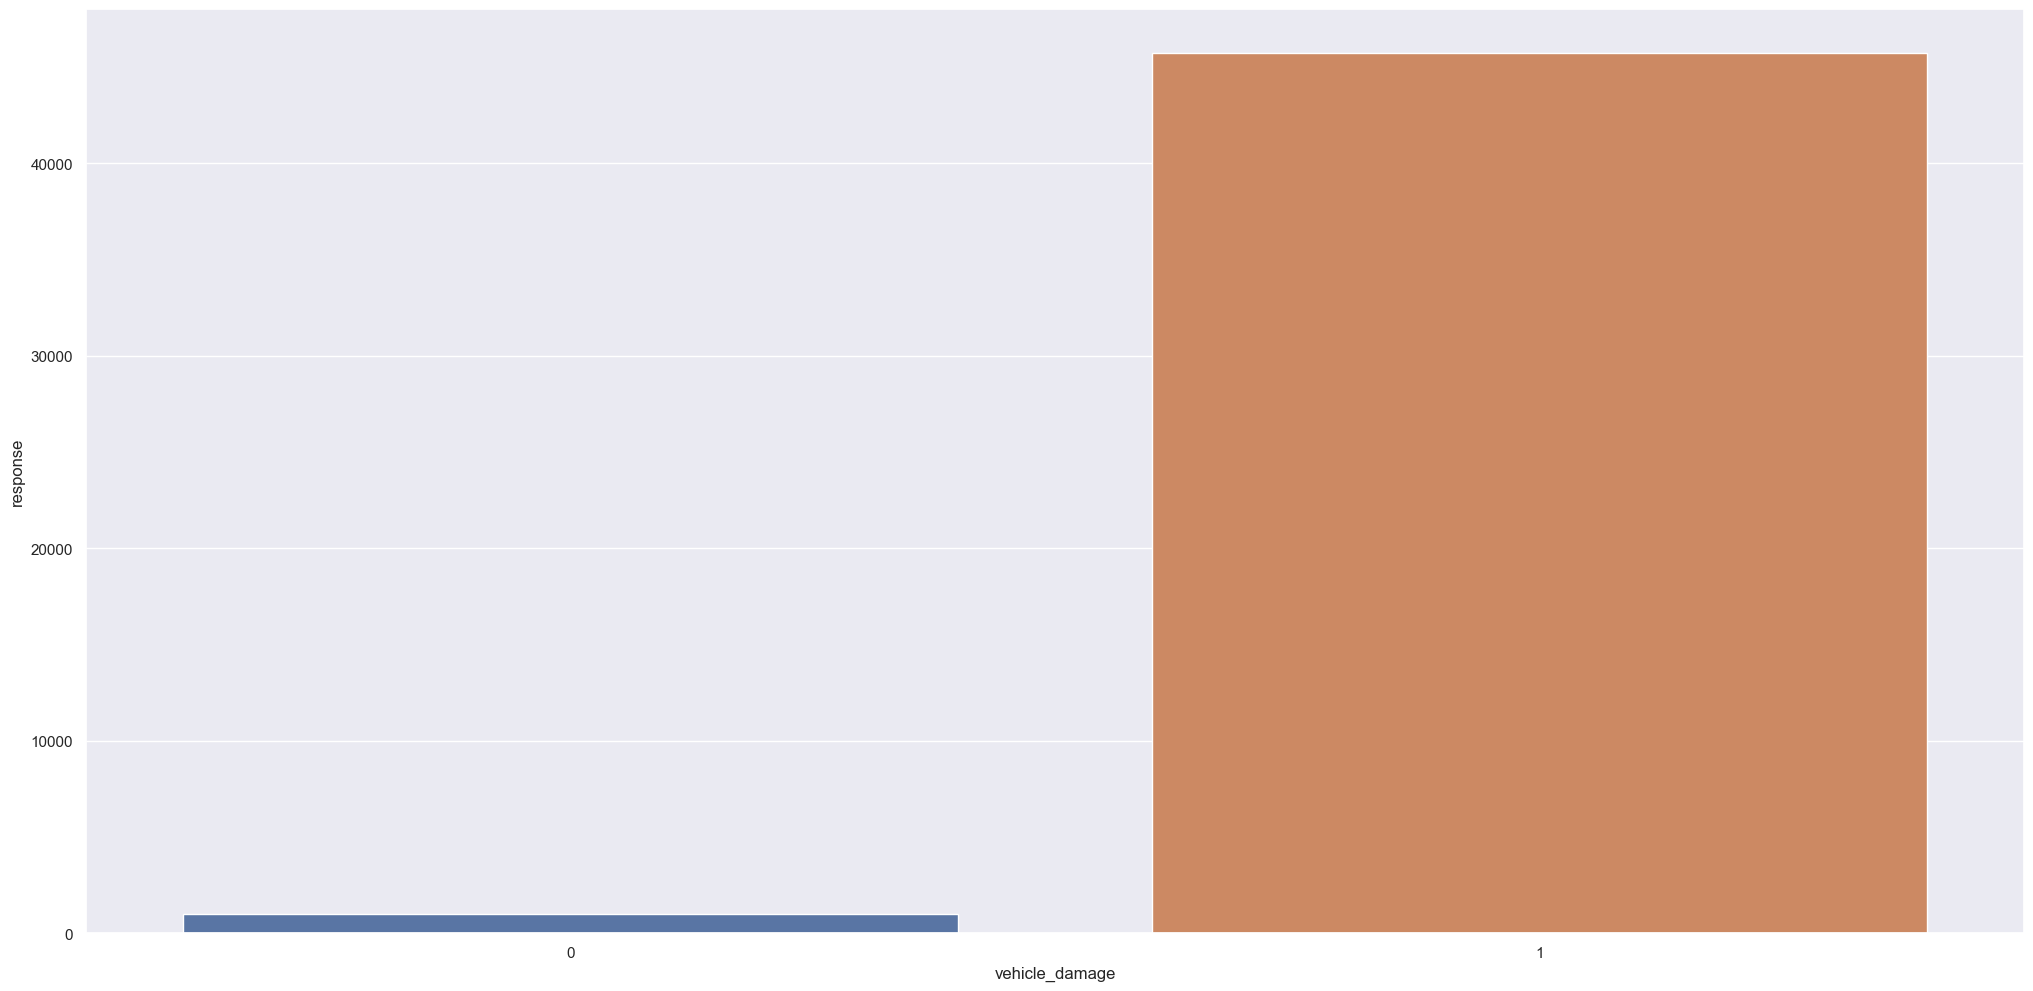

In [54]:
df_h6 = df4[['vehicle_damage', 'response']][df4['response'] == 1].groupby('vehicle_damage').count().reset_index()

sns.barplot(x='vehicle_damage', y='response', data=df_h6);

**H7.** Clientes que já possuem algum seguro veicular aceitam menos o seguro de automóvel ofertado.

**RESPOSTA**: Essa afirmação é verdadeira!

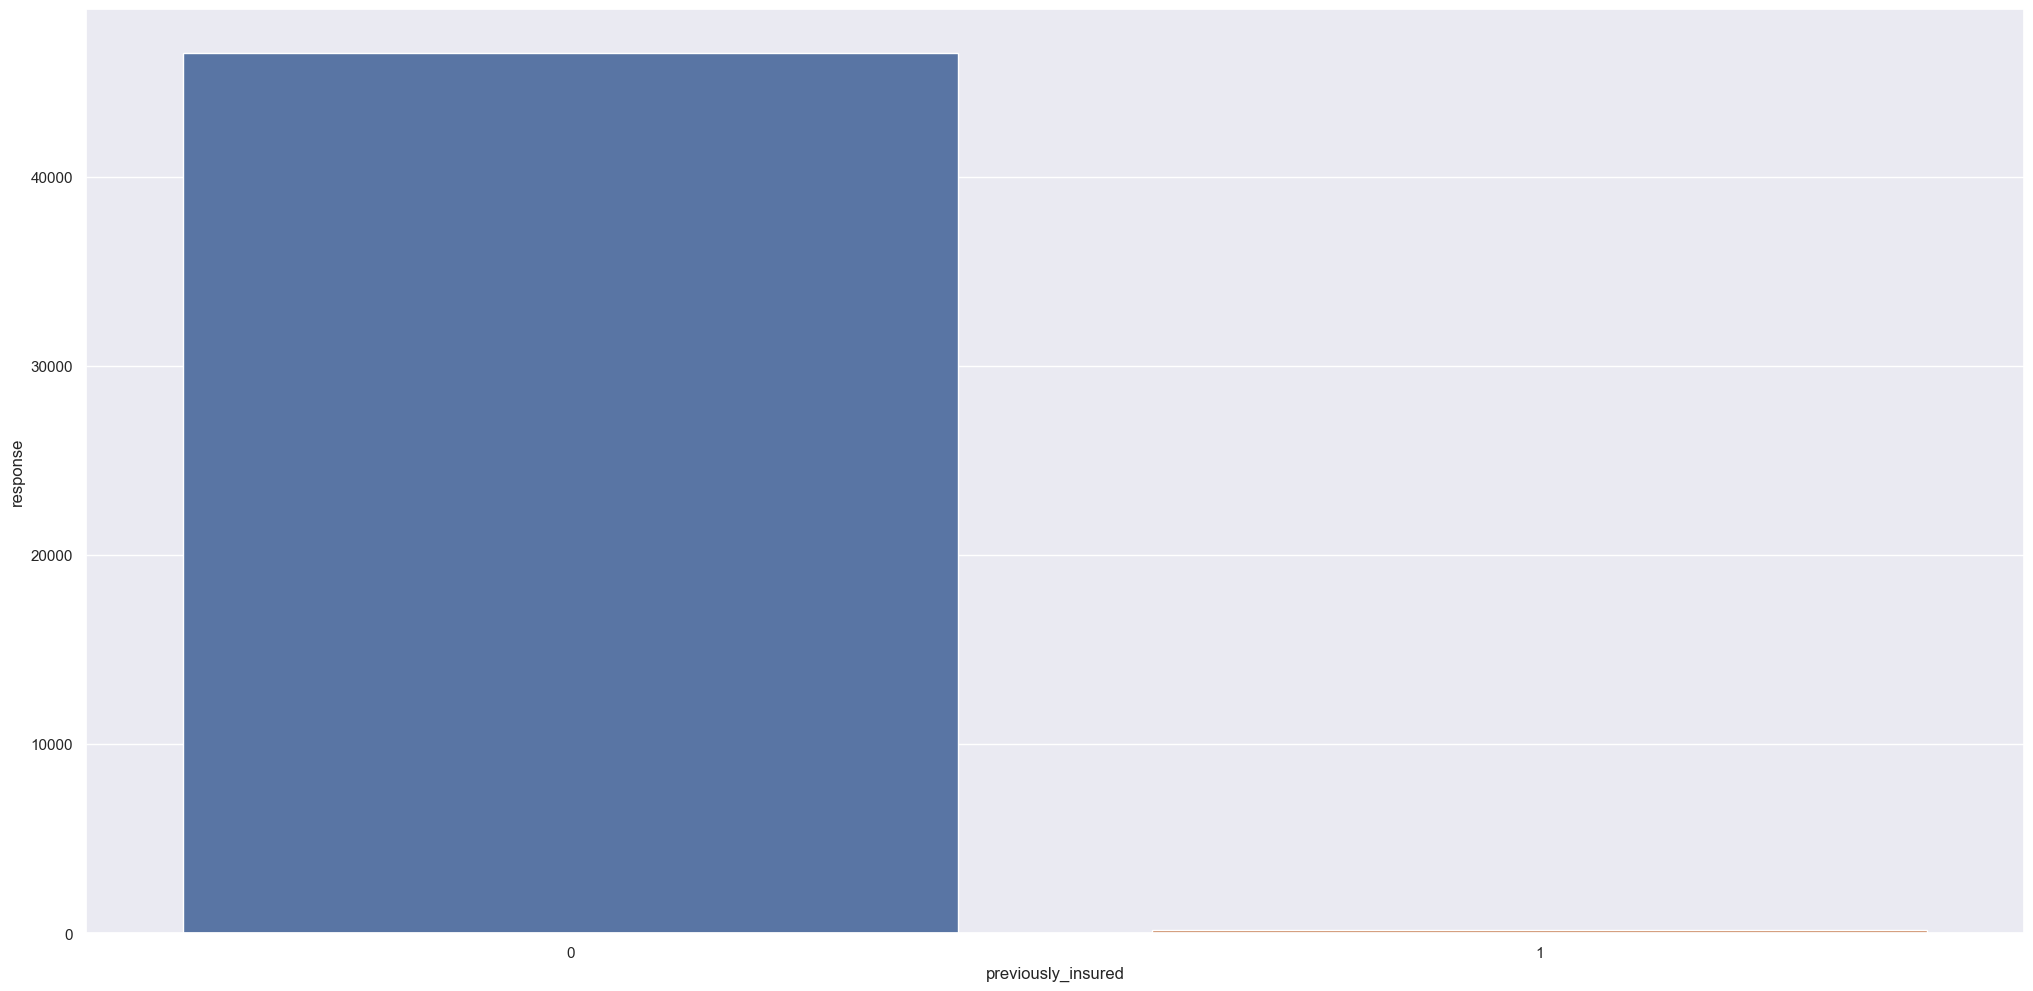

In [55]:
df_h7 = df4[['previously_insured', 'response']][df4['response'] == 1].groupby('previously_insured').count().reset_index()

sns.barplot(x='previously_insured', y='response', data=df_h7);

**H8.** Clientes que estão a mais de 180 dias com a empresa aceitam mais o seguro veicular.

**RESPOSTA:** Essa afirmação é falsa. Temos uma homogeneidade nos dados, dessa forma, gerando uma inconclusão.

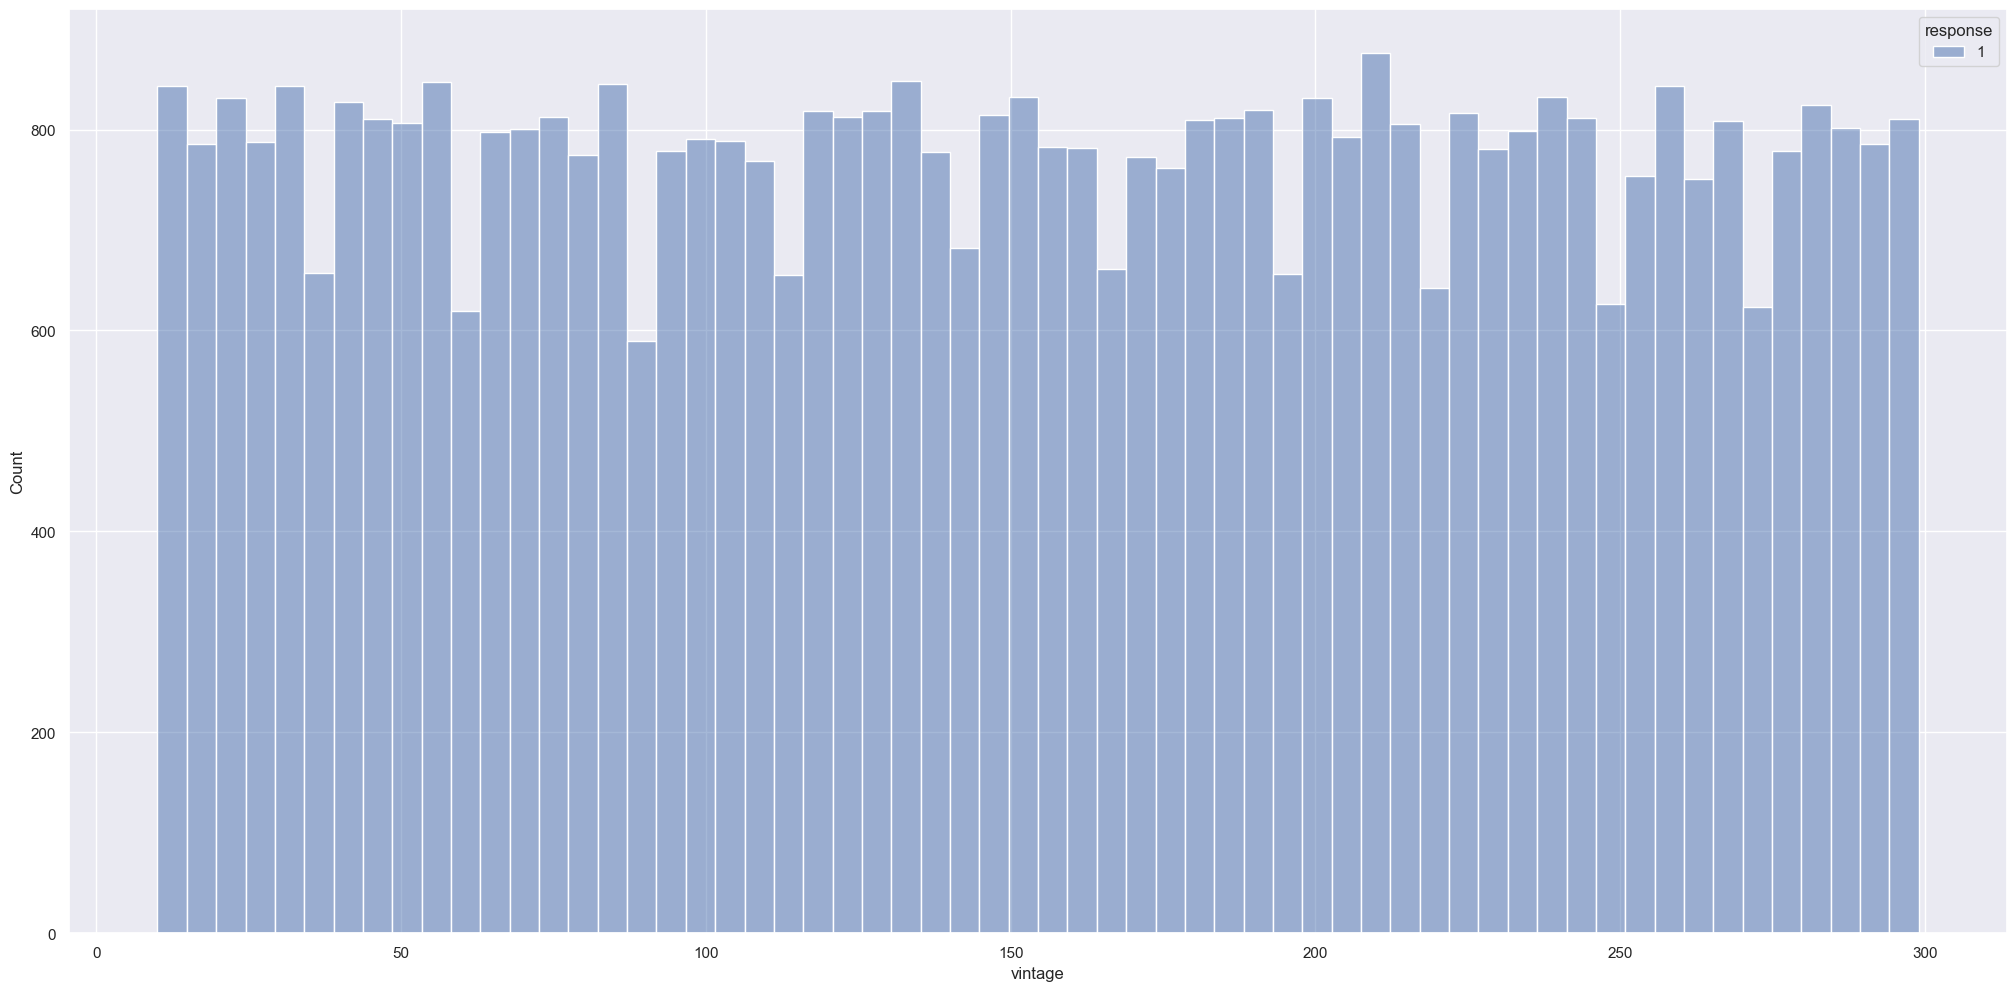

In [56]:
df_h8 = df4[['vintage', 'response']][df4['response'] == 1]

sns.histplot(data=df_h8, x='vintage', hue='response', bins=60);

**H9.** Clientes com idade acima de 40 anos aceitam mais o seguro veicular

**RESPOSTA:** Essa afirmação é verdadeira. Melhor ainda, clientes que estão na faixa de idade de 40 a 50 anos aceitam mais o seguro veicular.

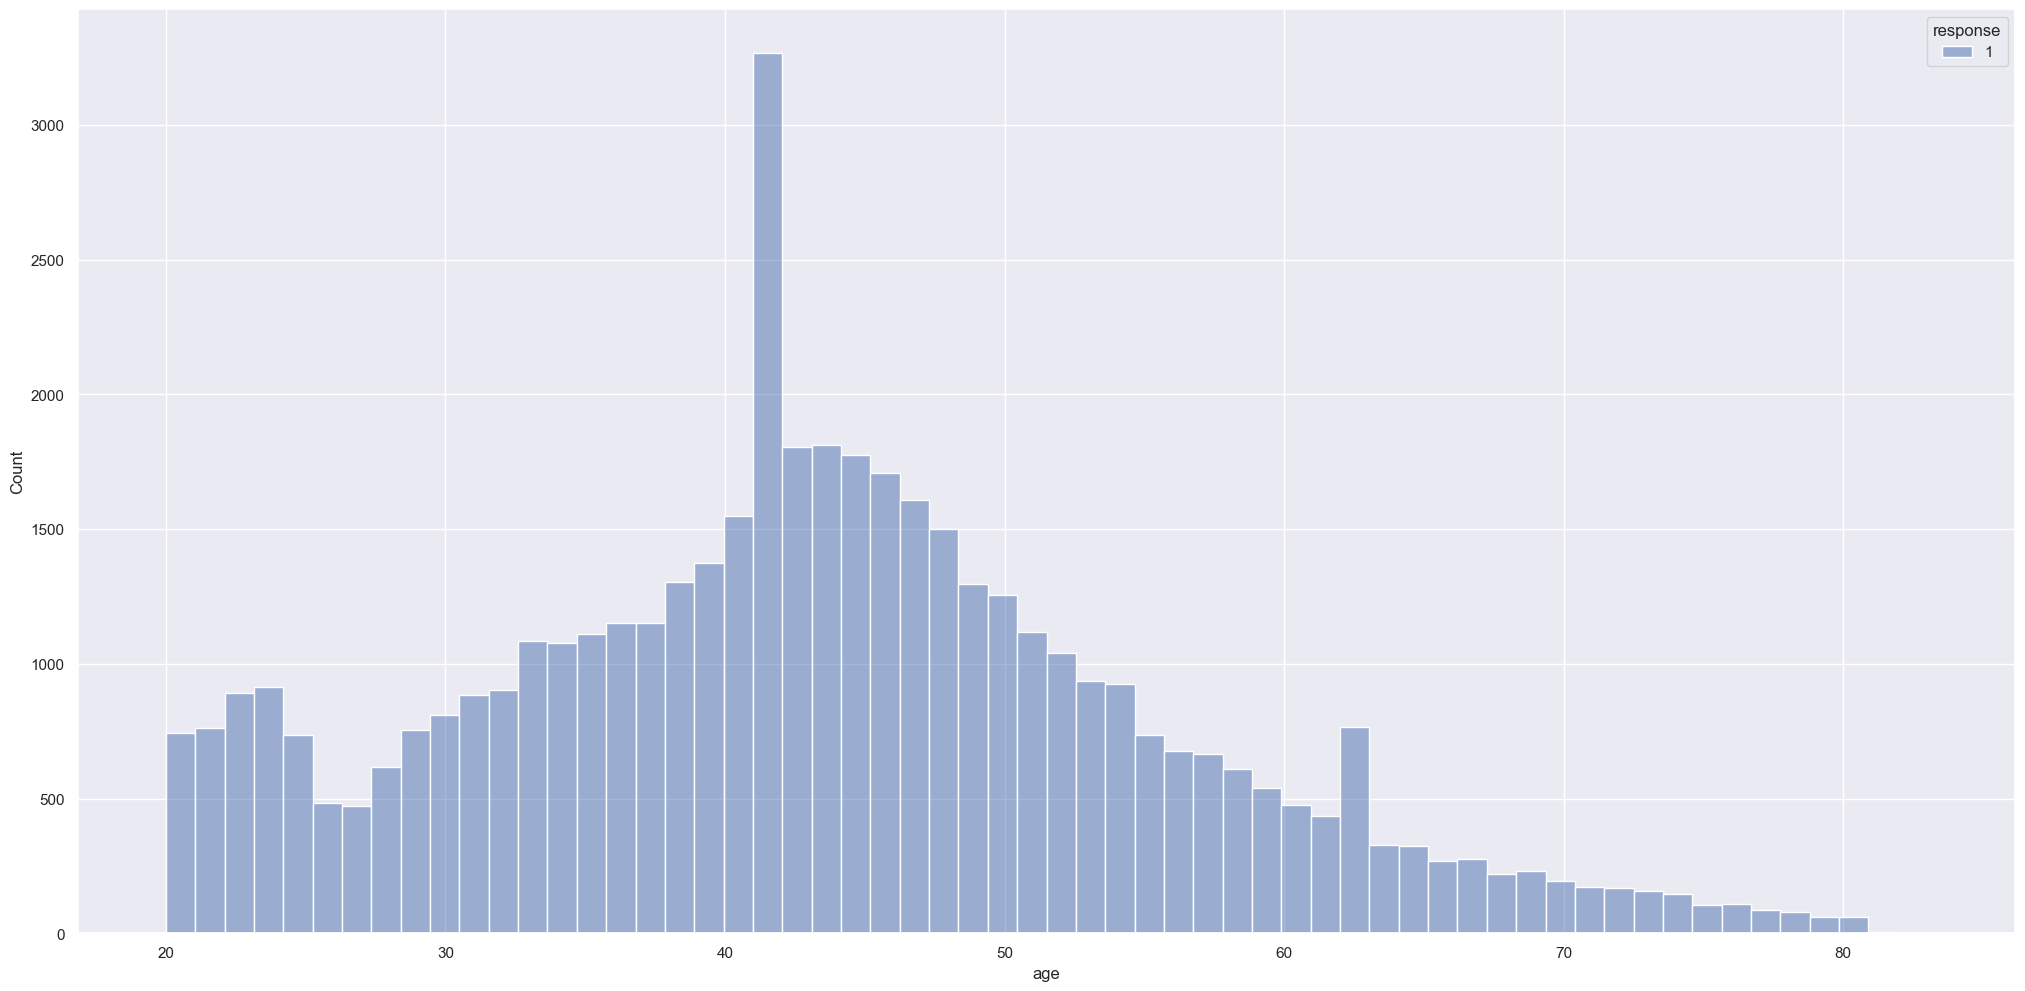

In [57]:
df_h8 = df4[['age', 'response']][df4['response'] == 1]

sns.histplot(data=df_h8, x='age', hue='response', bins=60);

## 4.4 Resumo das Hipóteses

In [58]:
tab = [['Variável', 'Relevancia'], 
       ['annual_premium', 'Alta'],
       ['vintage', 'Alta'],
       ['age', 'Alta'],
       ['policy_sales_channel', 'Alta'],
       ['region_code', 'Alta'],
       ['previously_insured', 'Media'],
       ['driving_license', 'Baixa'],]

print(tabulate(tab, headers='firstrow'))

Variável              Relevancia
--------------------  ------------
annual_premium        Alta
vintage               Alta
age                   Alta
policy_sales_channel  Alta
region_code           Alta
previously_insured    Media
driving_license       Baixa


# 5.0 - Preparação dos Dados

In [59]:
df5 = df4.copy()

## 5.1 Standarlazing

In [60]:
# annual_premium

# método utlizado para padronização
ss = pp.StandardScaler()

# variável annual_premium padronizada
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

# salvar o modelo
pickle.dump(ss, open('/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/src/features/annual_premium_scaler.pkl', 'wb'))

## 5.2 Rescaling

In [61]:
# variável 'age' - MinMaxScaler
mms_age = pp.MinMaxScaler()
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/src/features/age_scaler.pkl', 'wb'))

# variável 'vintage' - MinMaxScaler
mms_vintage = pp.MinMaxScaler()
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/src/features/vintage_scaler.pkl', 'wb'))

## 5.2 Encoder


In [62]:
#'region_code' - Frequencily Enconding
fe_encode_region_code = df5.groupby('region_code').size()/len(df5)
df5.loc[ : , 'region_code'] = df5['region_code'].map(fe_encode_region_code)

# Salvando o modelo
pickle.dump(fe_encode_region_code, open('/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/src/features/region_code_encoder.pkl', 'wb'))


#'vehicle_age' - Order Enconding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])


#'policy_sales_channel' - Target Enconding/ Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5)
df5.loc[ : , 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# Salvando o modelo
pickle.dump(fe_policy_sales_channel, open('/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/src/features/policy_sales_channel_encoder.pkl', 'wb'))


#'gender' - Frequencily Encoding
fe_encode_gender = df5.groupby('gender').size()/len(df5)
df5.loc[ : , 'gender'] = df5['gender'].map(fe_encode_gender)

# Salvando o modelo
pickle.dump(fe_policy_sales_channel, open('/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/src/features/gender_encoder.pkl', 'wb'))

C:\Users\Xcell\AppData\Local\Temp\ipykernel_10596\2562254843.py:23: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[ : , 'gender'] = df5['gender'].map(fe_encode_gender)


# 6.0 - Seleção das Features 

In [63]:
df6 = df5.copy()

## 6.1 - Datasets de treino, validação e teste

In [64]:
# ---------------------------- Construção dos dataframes de treino e teste ----------------------------------
# Separação dos sets
X = df5.drop('response', axis=1)
Y = df5['response'].copy()

# Dataframes treino e teste
x_train, x_test, y_train, y_test = ms.train_test_split(X, Y, test_size=0.2)

# dataset train
df_train = pd.concat([x_train, y_train], axis=1).copy()


# --------------------------- Construção dos dataframes de treino e validação -------------------------------

# Separação dso Dataset
X_train = df_train.drop('response', axis=1)
Y_train = df_train['response'].copy()

# Dataset de treino e validação
x_train, x_val, y_train, y_val = ms.train_test_split(X_train, Y_train, test_size=0.2)

# conjunto principal
df6 = pd.concat([x_train, y_train], axis=1).copy()

## 6.2 Feature Selections

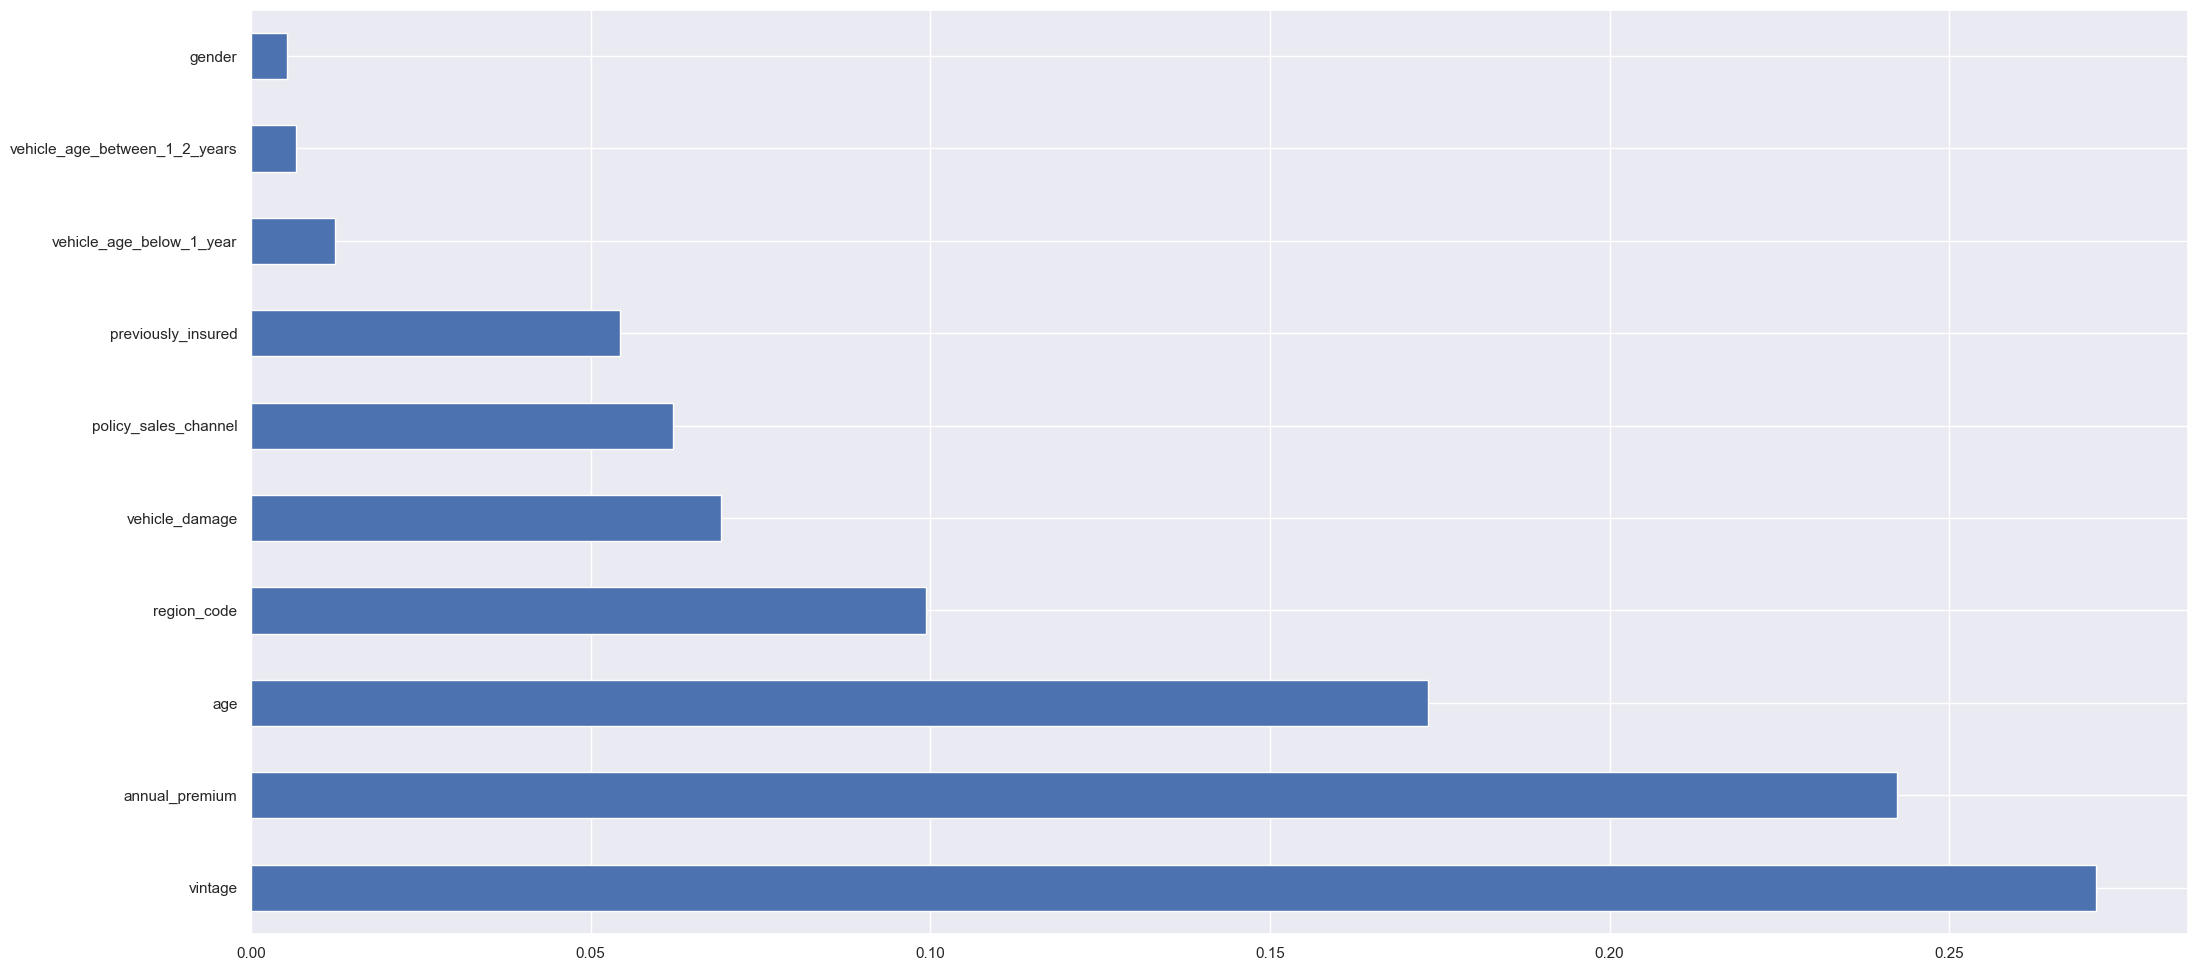

In [62]:
# Preparação do Classificador
forest = en.ExtraTreesClassifier(n_estimators=500, random_state=42, n_jobs=-1)

# Preparação do dataset_train
x_train_n = df6.drop(columns=['id', 'response'], axis=1)
y_train_n = df6['response'].values

# Seleção das Features Relevantes
selection_features = forest.fit(x_train_n, y_train_n)

# Exibição em gráfico das features selecionadas.
feat_importances = pd.Series(selection_features.feature_importances_, index=x_train_n.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [63]:
feat_importances.sort_values(ascending=False)

vintage                          0.271613
annual_premium                   0.242353
age                              0.173350
region_code                      0.099348
vehicle_damage                   0.069167
policy_sales_channel             0.062168
previously_insured               0.054410
vehicle_age_below_1_year         0.012401
vehicle_age_between_1_2_years    0.006613
gender                           0.005295
vehicle_age_over_2_years         0.002763
driving_license                  0.000519
dtype: float64

In [65]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 
                      'policy_sales_channel', 'previously_insured']

cols_selected_full = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 
                      'policy_sales_channel', 'previously_insured', 'response']

# 7.0 - Machine Learning Models

In [66]:
# Seleção dos Dataframes para validação e testes;

# Conjunto de treino 
x_train = x_train[cols_selected].copy()
data_training = df6[cols_selected_full].copy()

# Conjuntos de Validação
x_val = x_val[cols_selected].copy()

data_validation = pd.concat([x_val, y_val], axis=1).reset_index().copy()
data_validation = data_validation.rename(columns={'index':'id'})

# Conjuntos de teste
x_test = x_test[cols_selected].copy()
df_test = pd.concat([x_test, y_test], axis=1).reset_index().copy()
df_test = df_test.rename(columns={'index':'id'})

## 7.1 KNN 

A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo KNN,
nos teremos 80% dos clientes interessados em adquirir o seguro veicular.

A curva Lift nos diz que se considerarmos 40% da nossa amostra, a lista ordenada pelo modelo KNN é 2 vezes melhor
que uma lista aleatória.


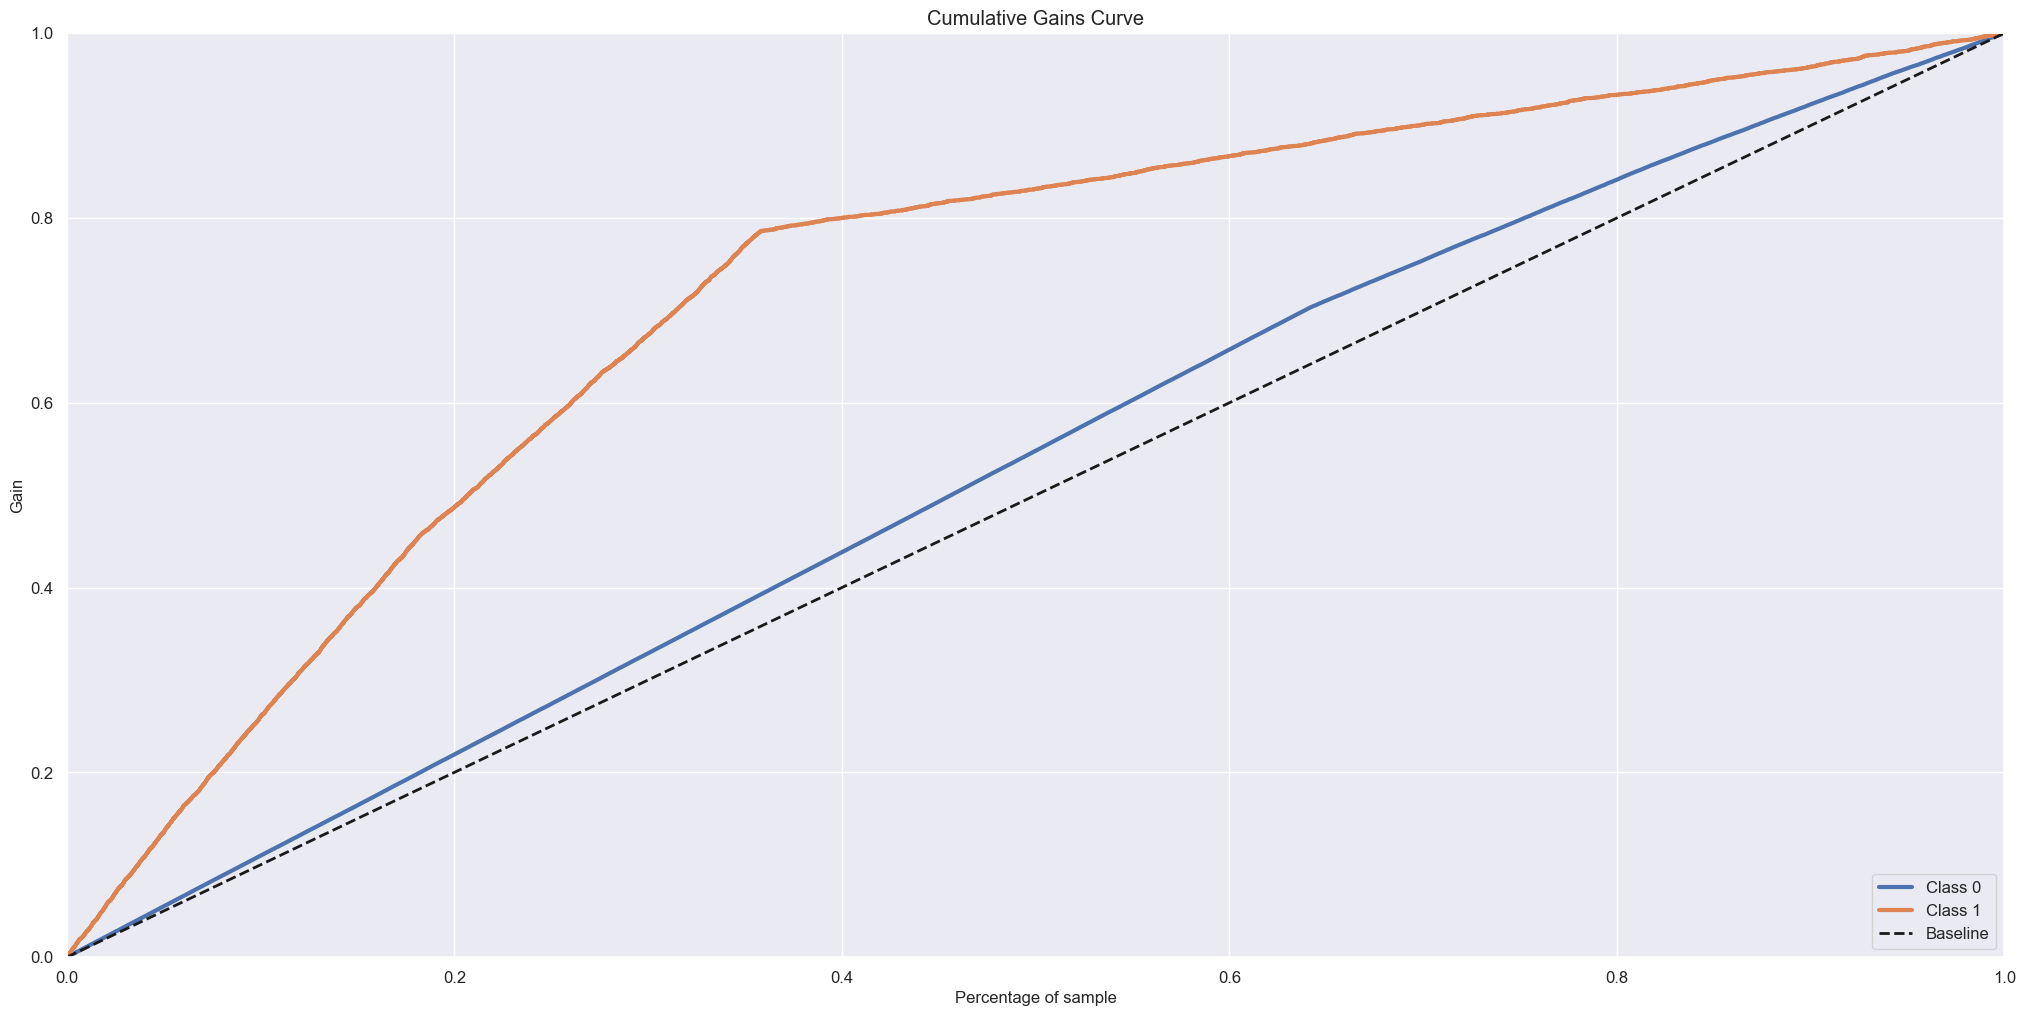

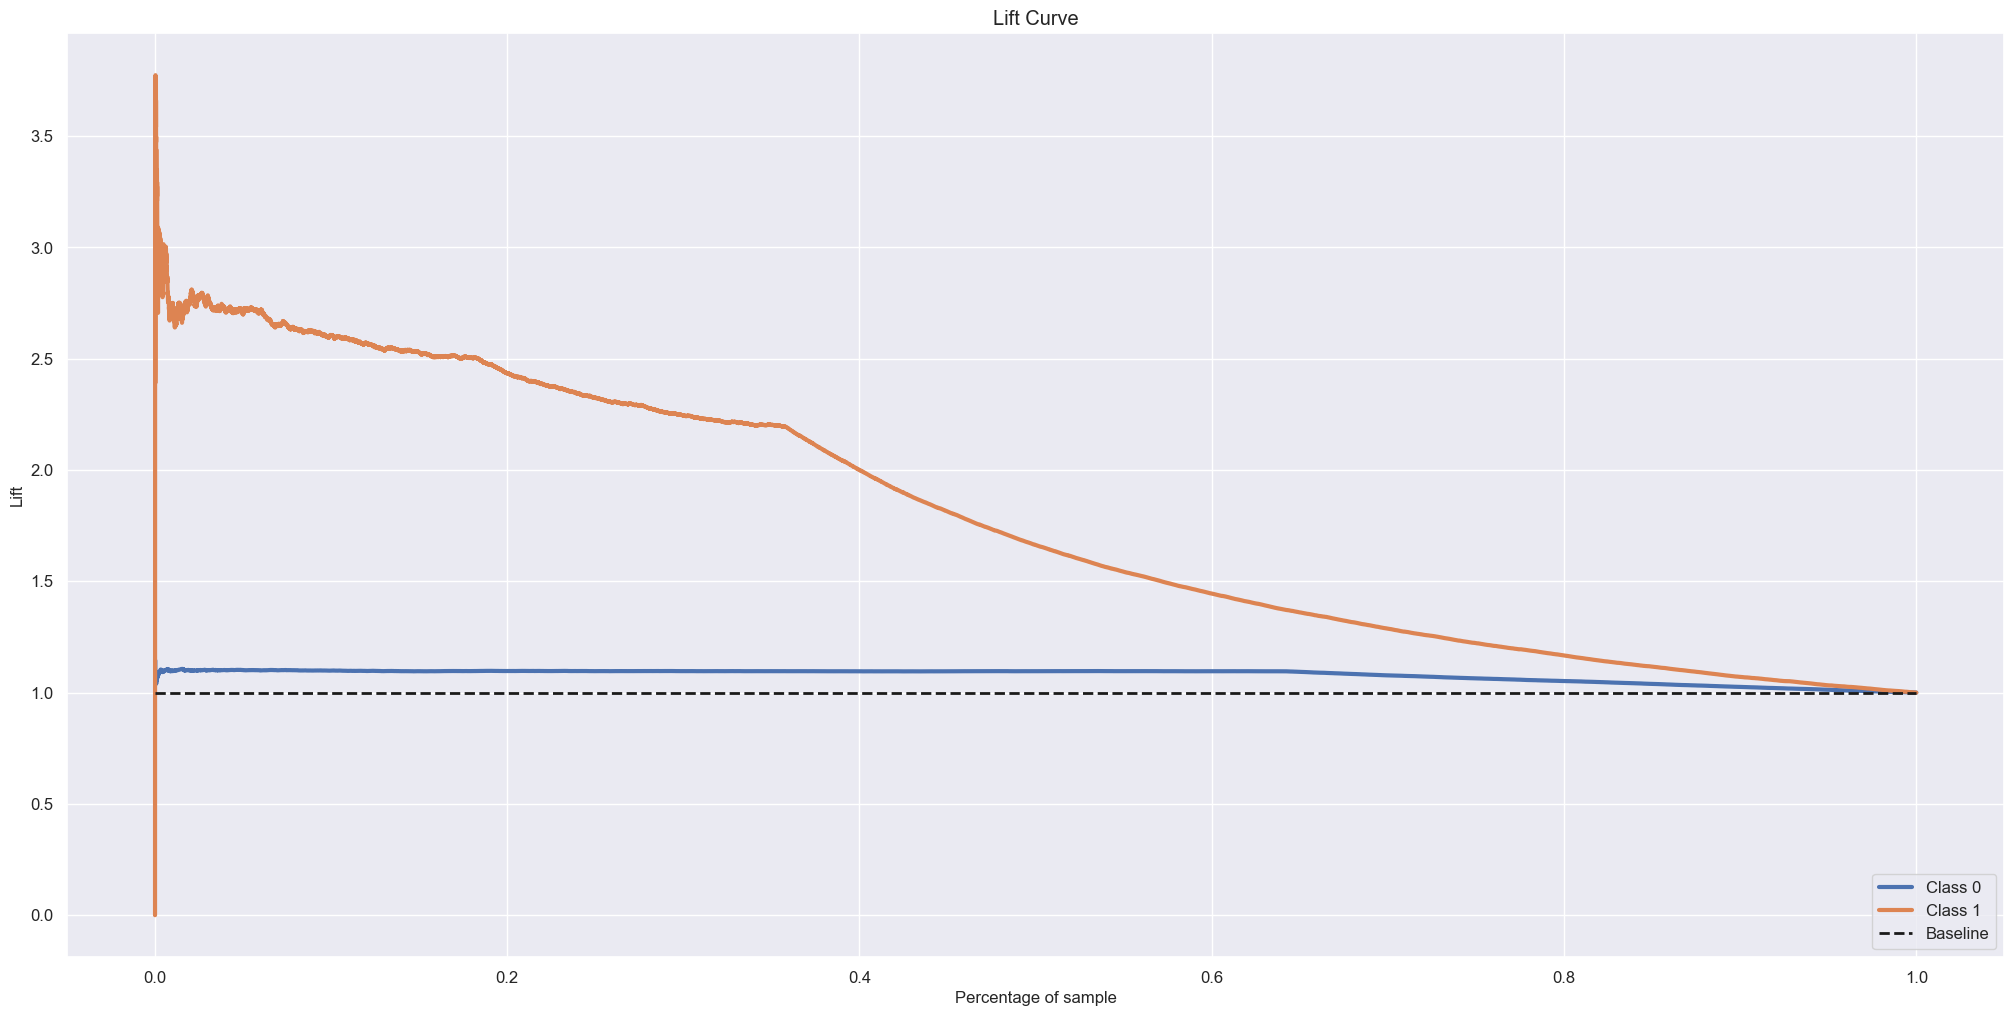

In [66]:
# Model with 7 neighbours
knn_model = nb.KNeighborsClassifier(n_jobs=-1)

# Treino
knn_model.fit(x_train, y_train)

# Predição para a construção do cumulative gains
yhat_knn_proba = knn_model.predict_proba(x_val)

# Gráfico
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn_proba);

# Curva Lift
skplt.metrics.plot_lift_curve(y_val, yhat_knn_proba);

print('A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo KNN,') 
print('nos teremos 80% dos clientes interessados em adquirir o seguro veicular.\n')

print('A curva Lift nos diz que se considerarmos 40% da nossa amostra, a lista ordenada pelo modelo KNN é 2 vezes melhor')  
print('que uma lista aleatória.')

### 7.1.1 KNN CrossValidation

In [67]:
# Cross_validation
knn_model_cv = pd.DataFrame(cross_validation(data_training, 'KNN Model', knn_model, 5), index=[0])
knn_model_cv

,model_name,precision_at_k_40000,recall_at_k_40000
0,KNN Model,0.14,0.94


## 7.2 XGBClassifier

A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo XGBClassifier,
nos teremos aproximadamente 90% dos clientes interessados em adquirir o seguro veicular.

A curva Lift nos diz que se considerarmos 40% da nossa amostra, 
a lista organizada pelo modelo XGBClassifier é 2,3 vezes melhor que uma lista organizada de forma aleatória.


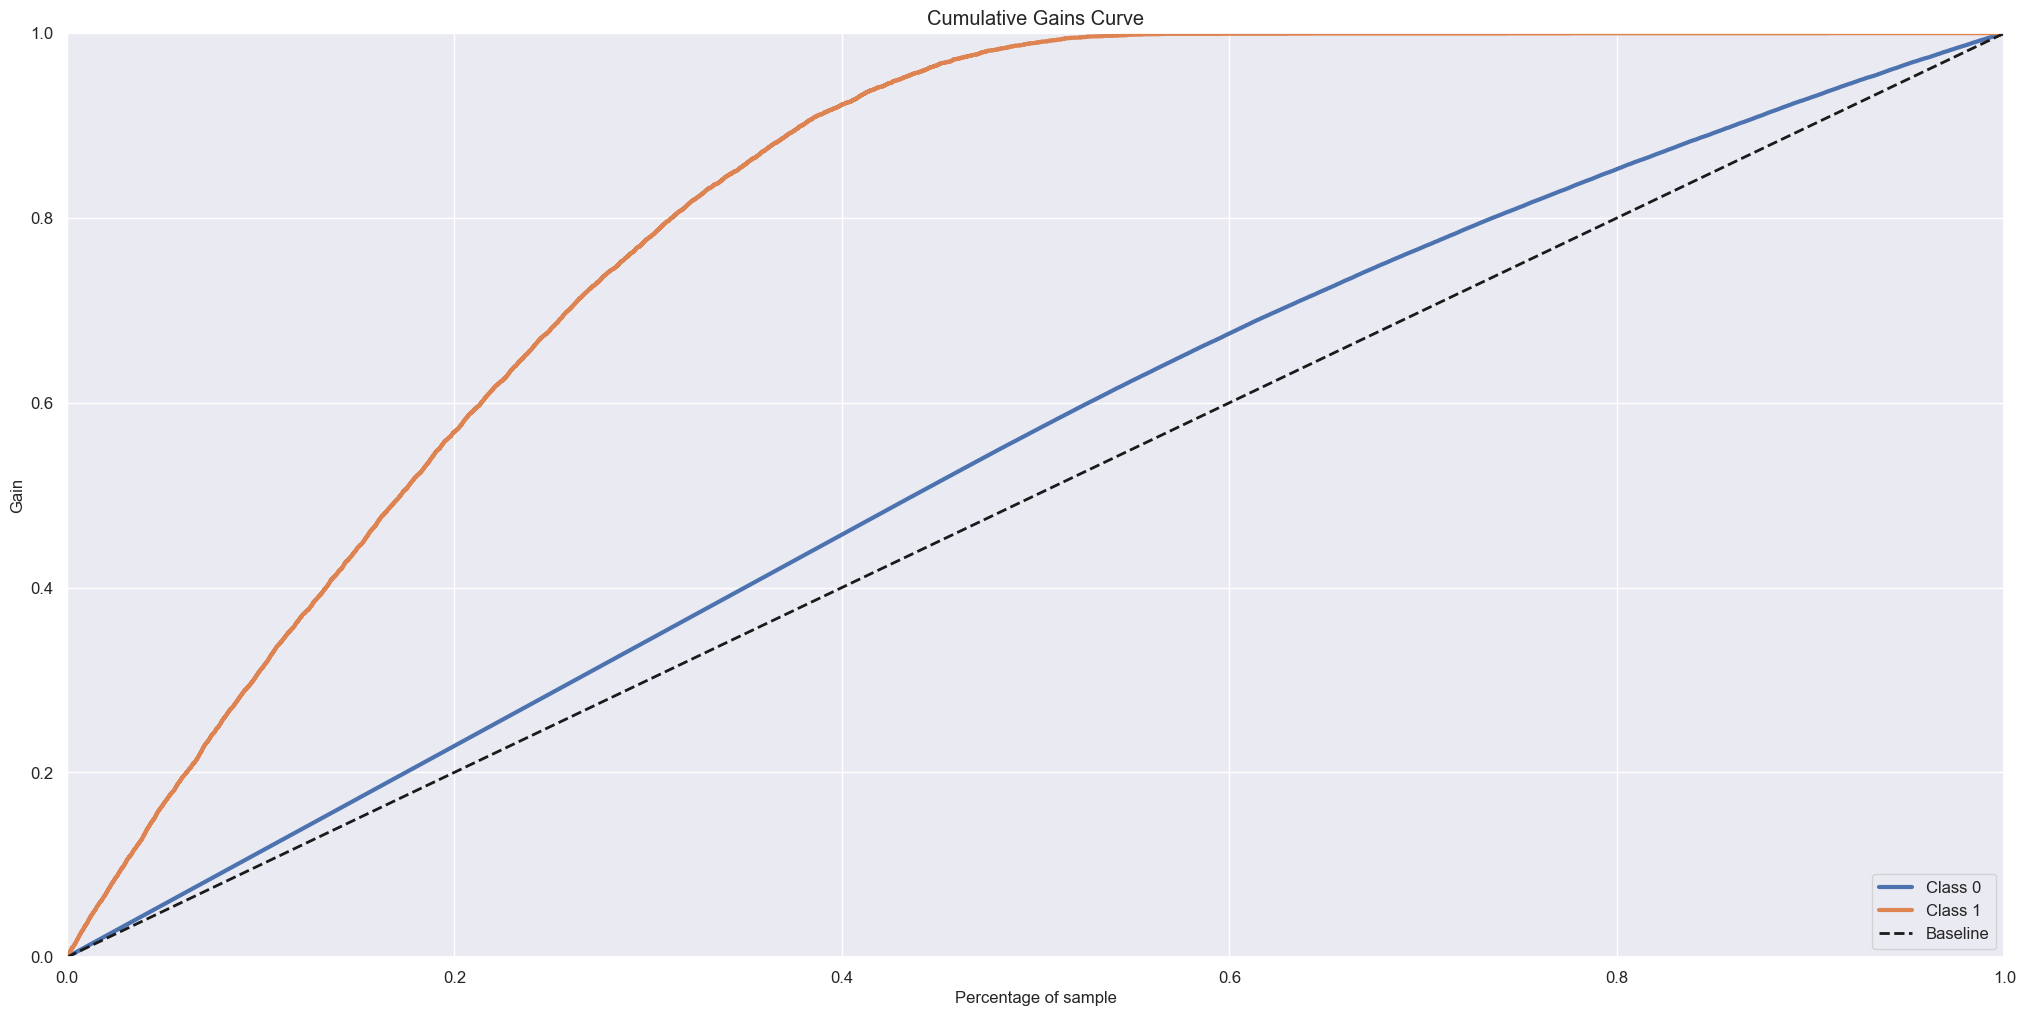

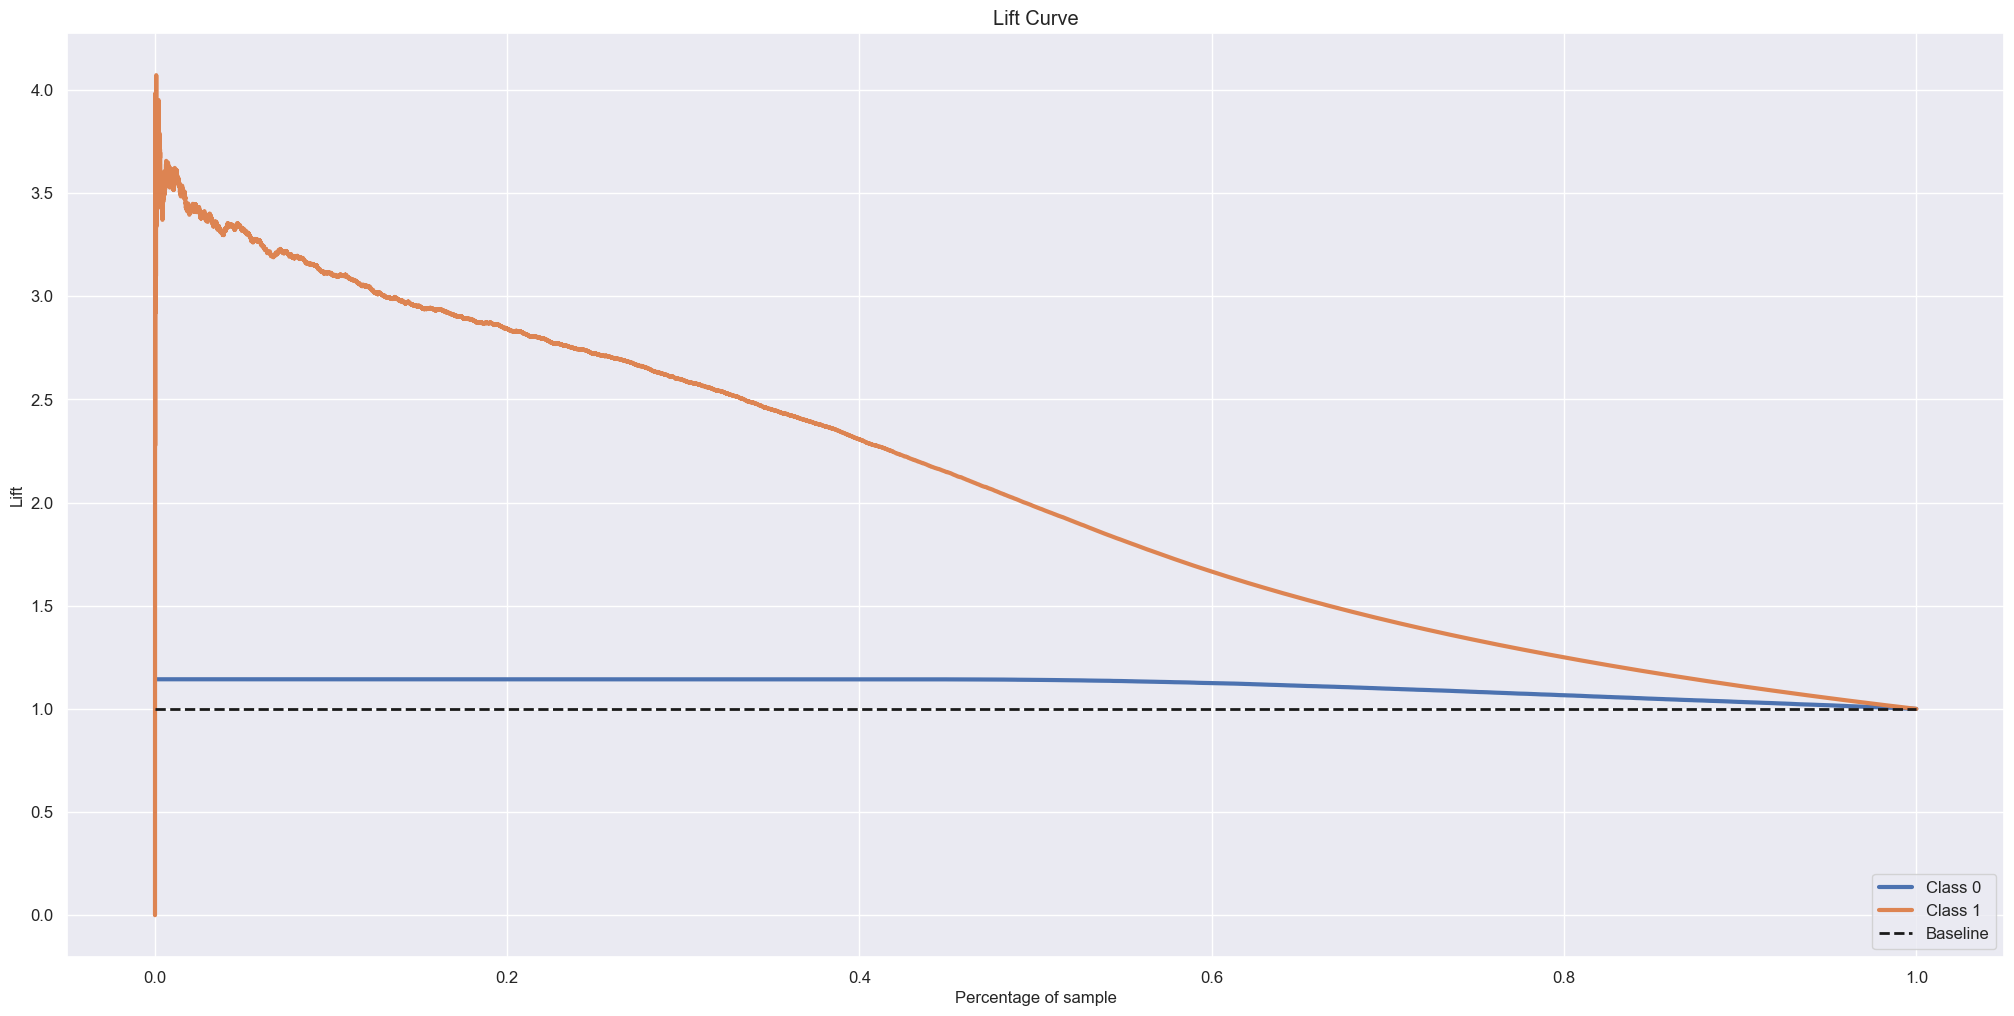

In [68]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1)
# Treino
xgb_model.fit(x_train, y_train)

# Predição para a construção do cumulative gains
yhat_xgb_proba = xgb_model.predict_proba(x_val)

# Gráfico
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb_proba);

# Curva Lift
skplt.metrics.plot_lift_curve(y_val, yhat_xgb_proba);

print('A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo XGBClassifier,') 
print('nos teremos aproximadamente 90% dos clientes interessados em adquirir o seguro veicular.\n') 

print('A curva Lift nos diz que se considerarmos 40% da nossa amostra, ')
print('a lista organizada pelo modelo XGBClassifier é 2,3 vezes melhor que uma lista organizada de forma aleatória.')

### 7.2.1 XGB CrossValidation

In [69]:
# Cross_validation
xgb_model_cv = pd.DataFrame(cross_validation(data_training, 'XGBClassifier Model', xgb_model, 5), index=[0])
xgb_model_cv

,model_name,precision_at_k_40000,recall_at_k_40000
0,XGBClassifier Model,0.149,1.0


## 7.3 ExtraTreesClassifier

A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo ExtraTreesClassifier,
nos teremos aproximadamente 85% dos clientes interessados em adquirir o seguro veicular.

A curva Lift nos diz que se considerarmos 40% da nossa amostra, a lista organizada pelo modelo ExtraTreesClassifier
é 2,3 vezes melhor que uma lista aleatória.


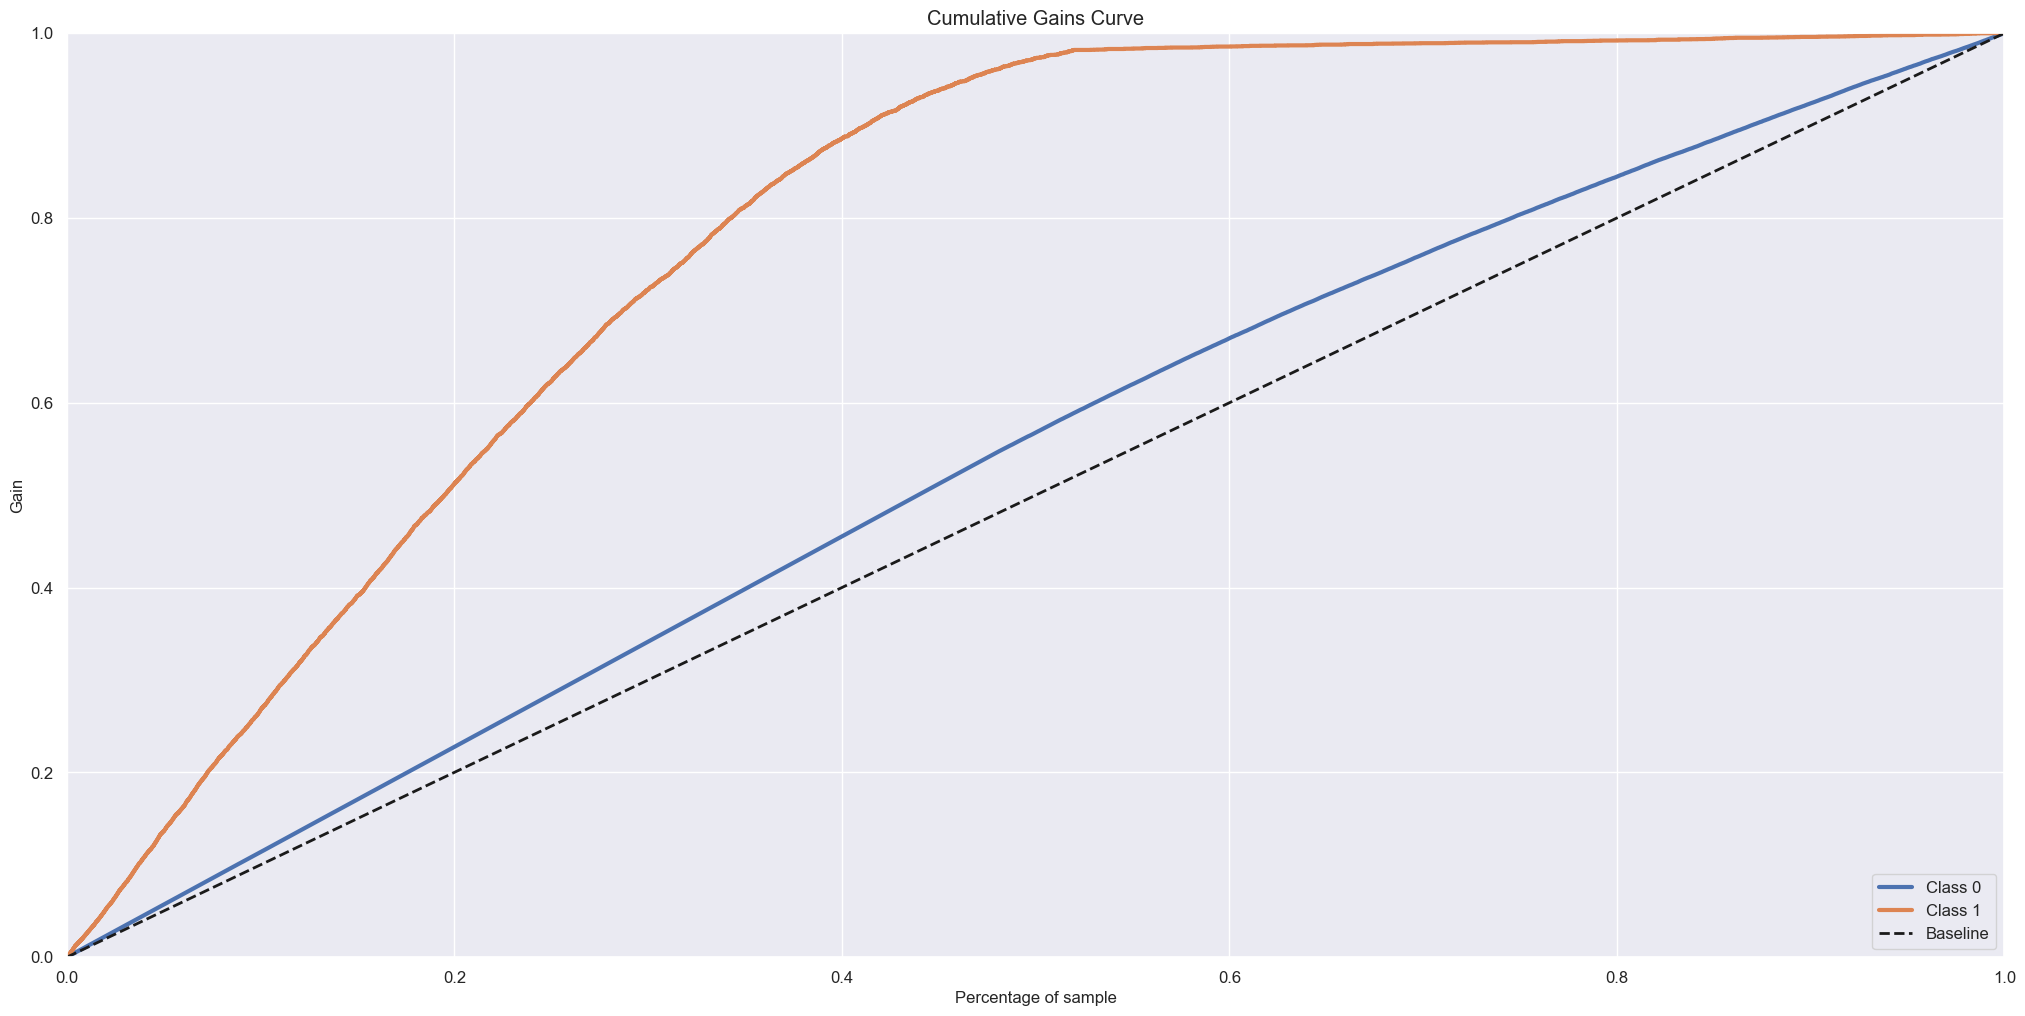

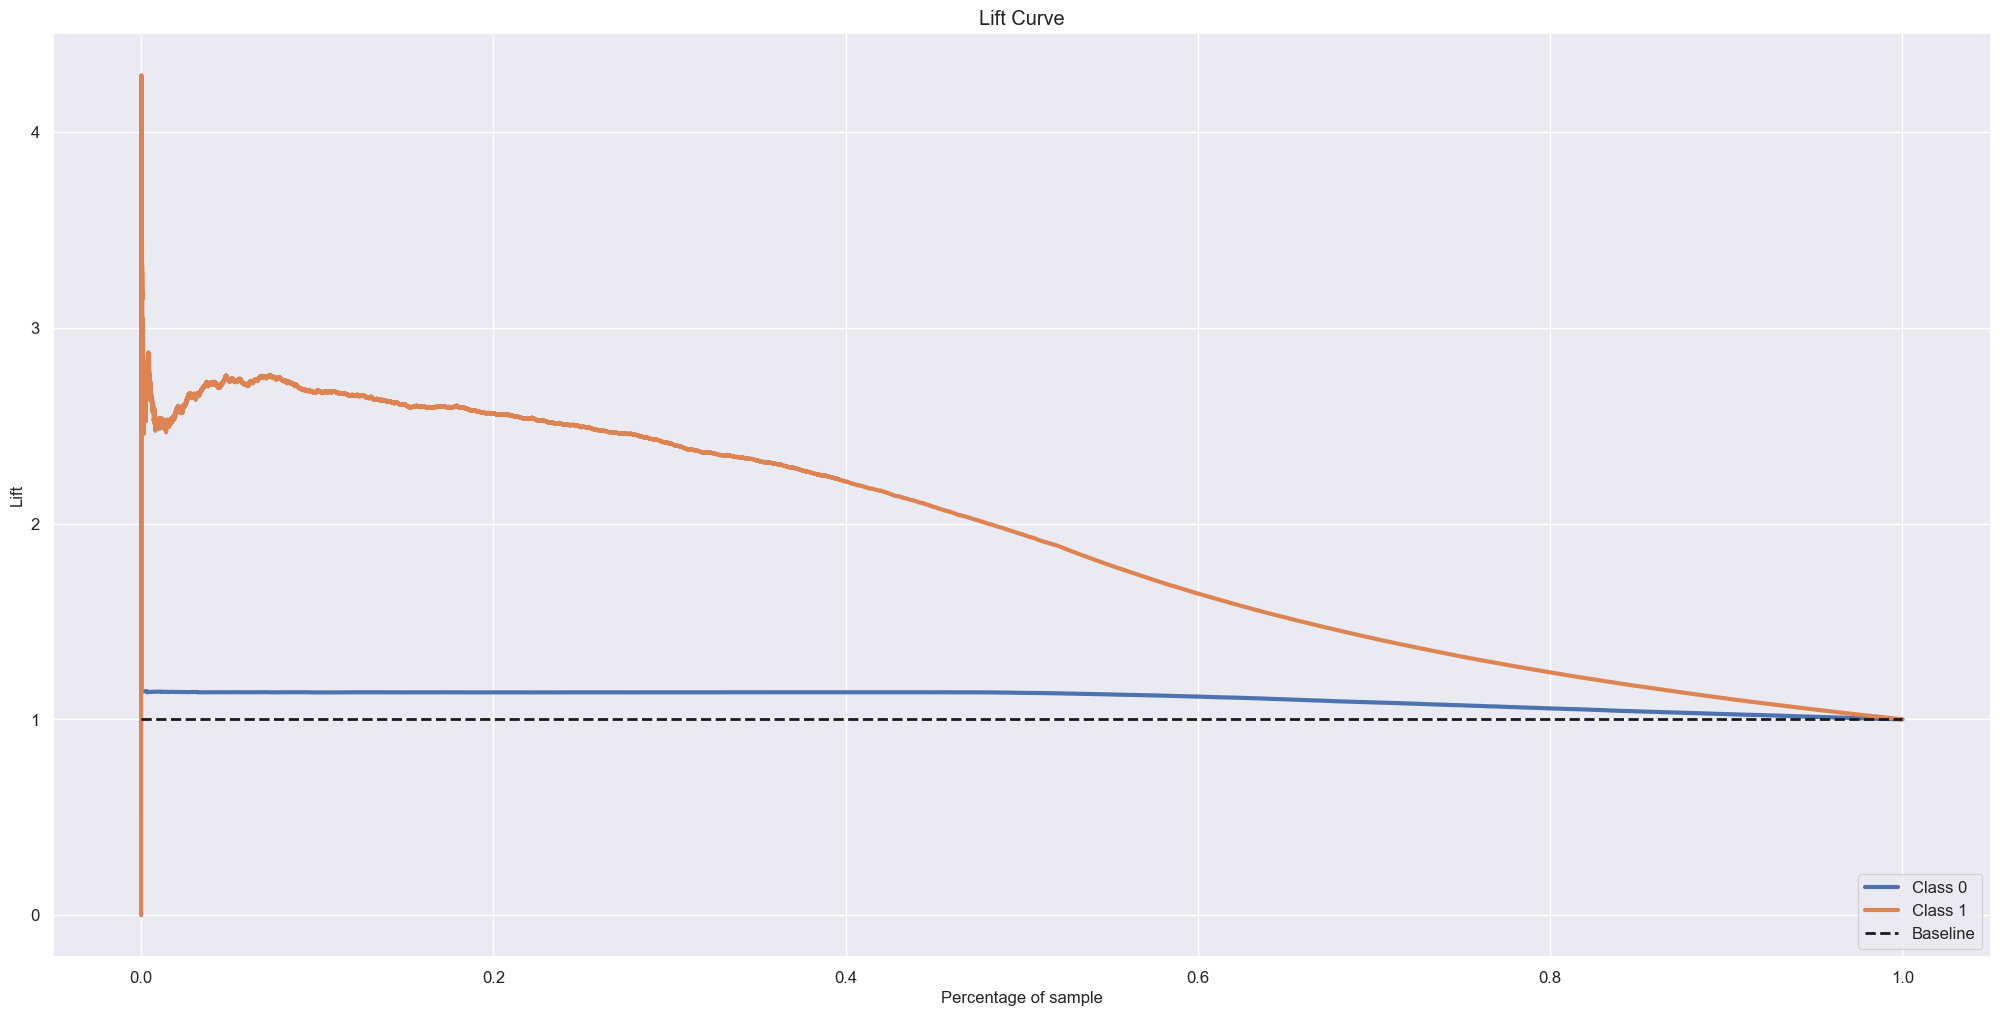

In [70]:
# model
et_model = en.ExtraTreesClassifier(n_jobs=-1)

# Treino
et_model.fit(x_train, y_train)

# Predição para a cumuative gains curve
yhat_et_proba = et_model.predict_proba(x_val)

# Predição para o precision e recall
yhat_et = et_model.predict(x_val)

# Cumulative Gains Curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_et_proba);

# Curve Lift
skplt.metrics.plot_lift_curve(y_val, yhat_et_proba);

print('A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo ExtraTreesClassifier,') 
print('nos teremos aproximadamente 85% dos clientes interessados em adquirir o seguro veicular.\n') 

print('A curva Lift nos diz que se considerarmos 40% da nossa amostra, a lista organizada pelo modelo ExtraTreesClassifier')
print('é 2,3 vezes melhor que uma lista aleatória.')

### 7.3.1 ExtraTreesClassifier CrossValidation

In [71]:
# Cross_validation
et_model_cv = pd.DataFrame(cross_validation(data_training, 'ExtraTreesClassifier Model', et_model, 5), index=[0])
et_model_cv

,model_name,precision_at_k_40000,recall_at_k_40000
0,ExtraTreesClassifier Model,0.148,0.994


## 7.4 LogisticRegressor

A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo Logistic Regression,
nos teremos aproximadamente 85% dos clientes interessados em adquirir o seguro veicular.

A curva Lift nos diz que se considerarmos 40% da nossa amostra, a lsita organizada pelo modelo Logistic Regression,
é 2,3 vezes melhor que uma lista organizada de forma randômica.


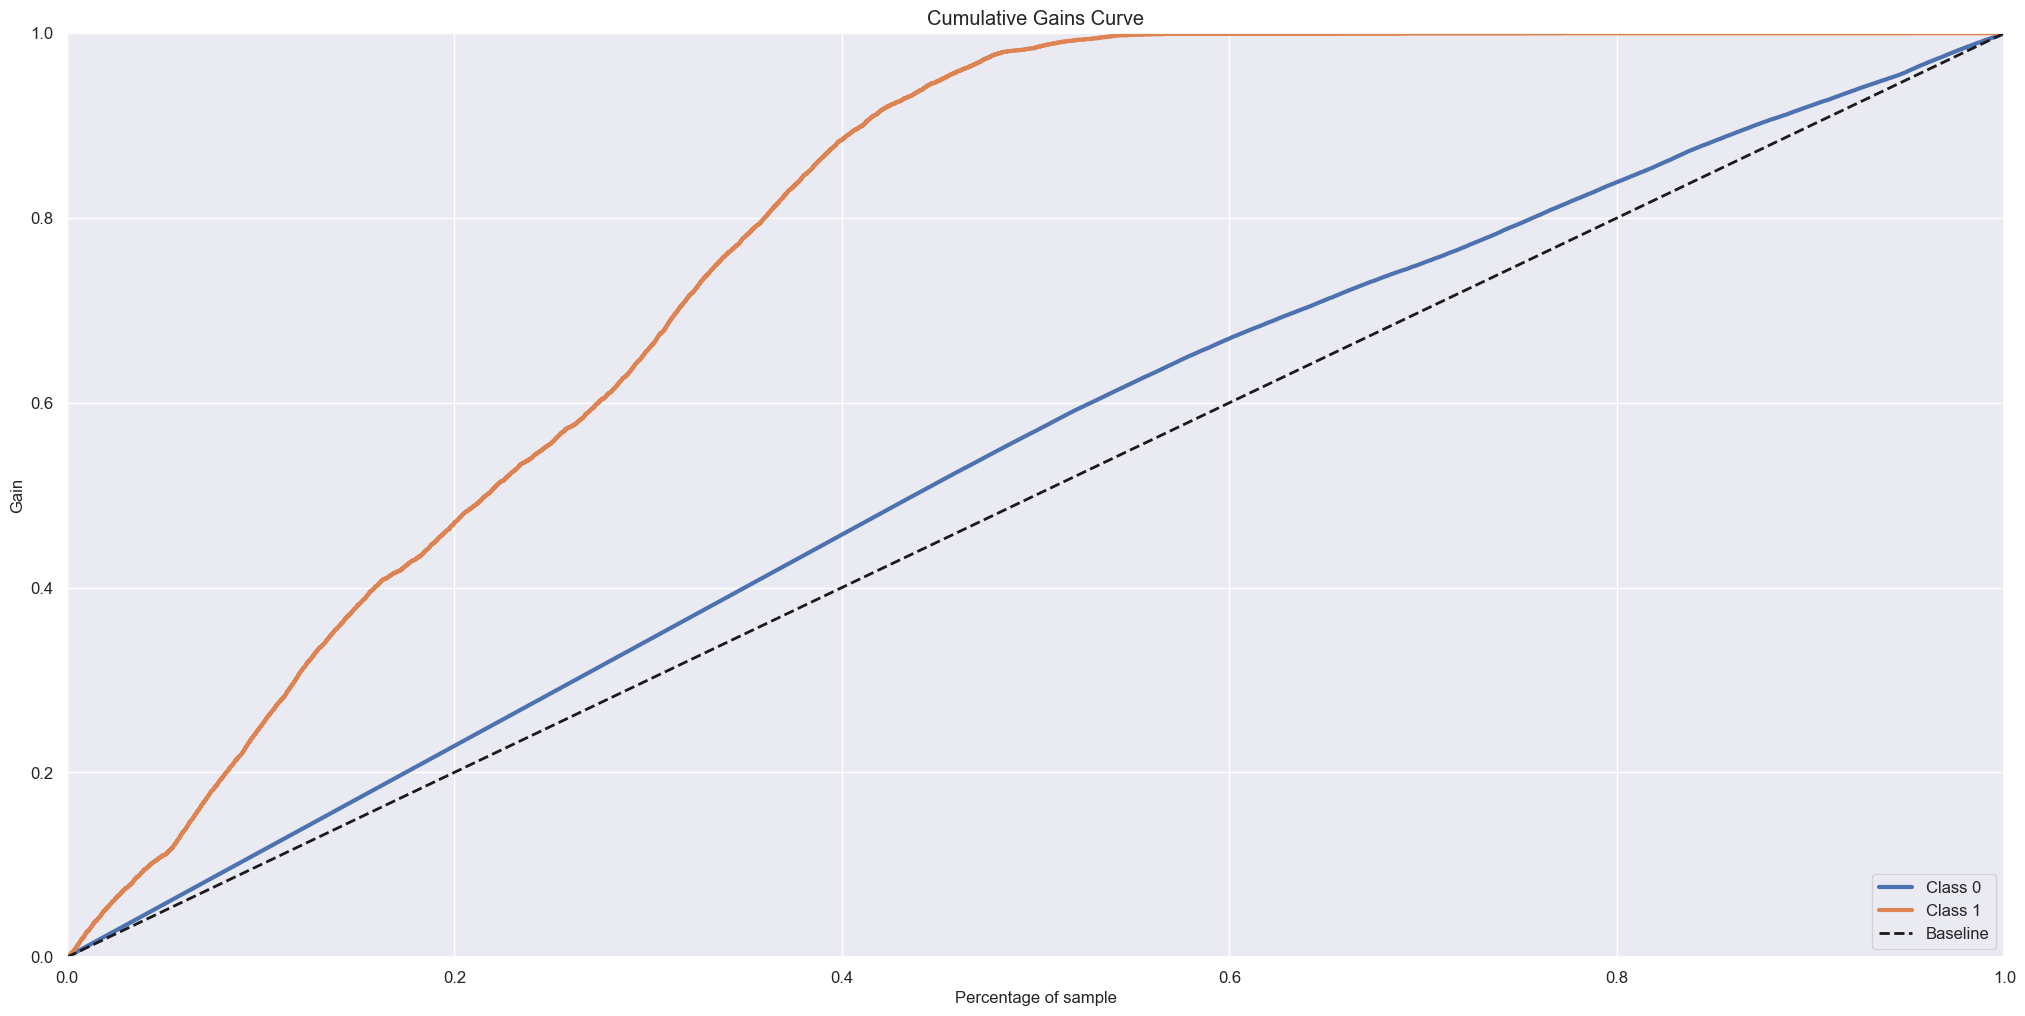

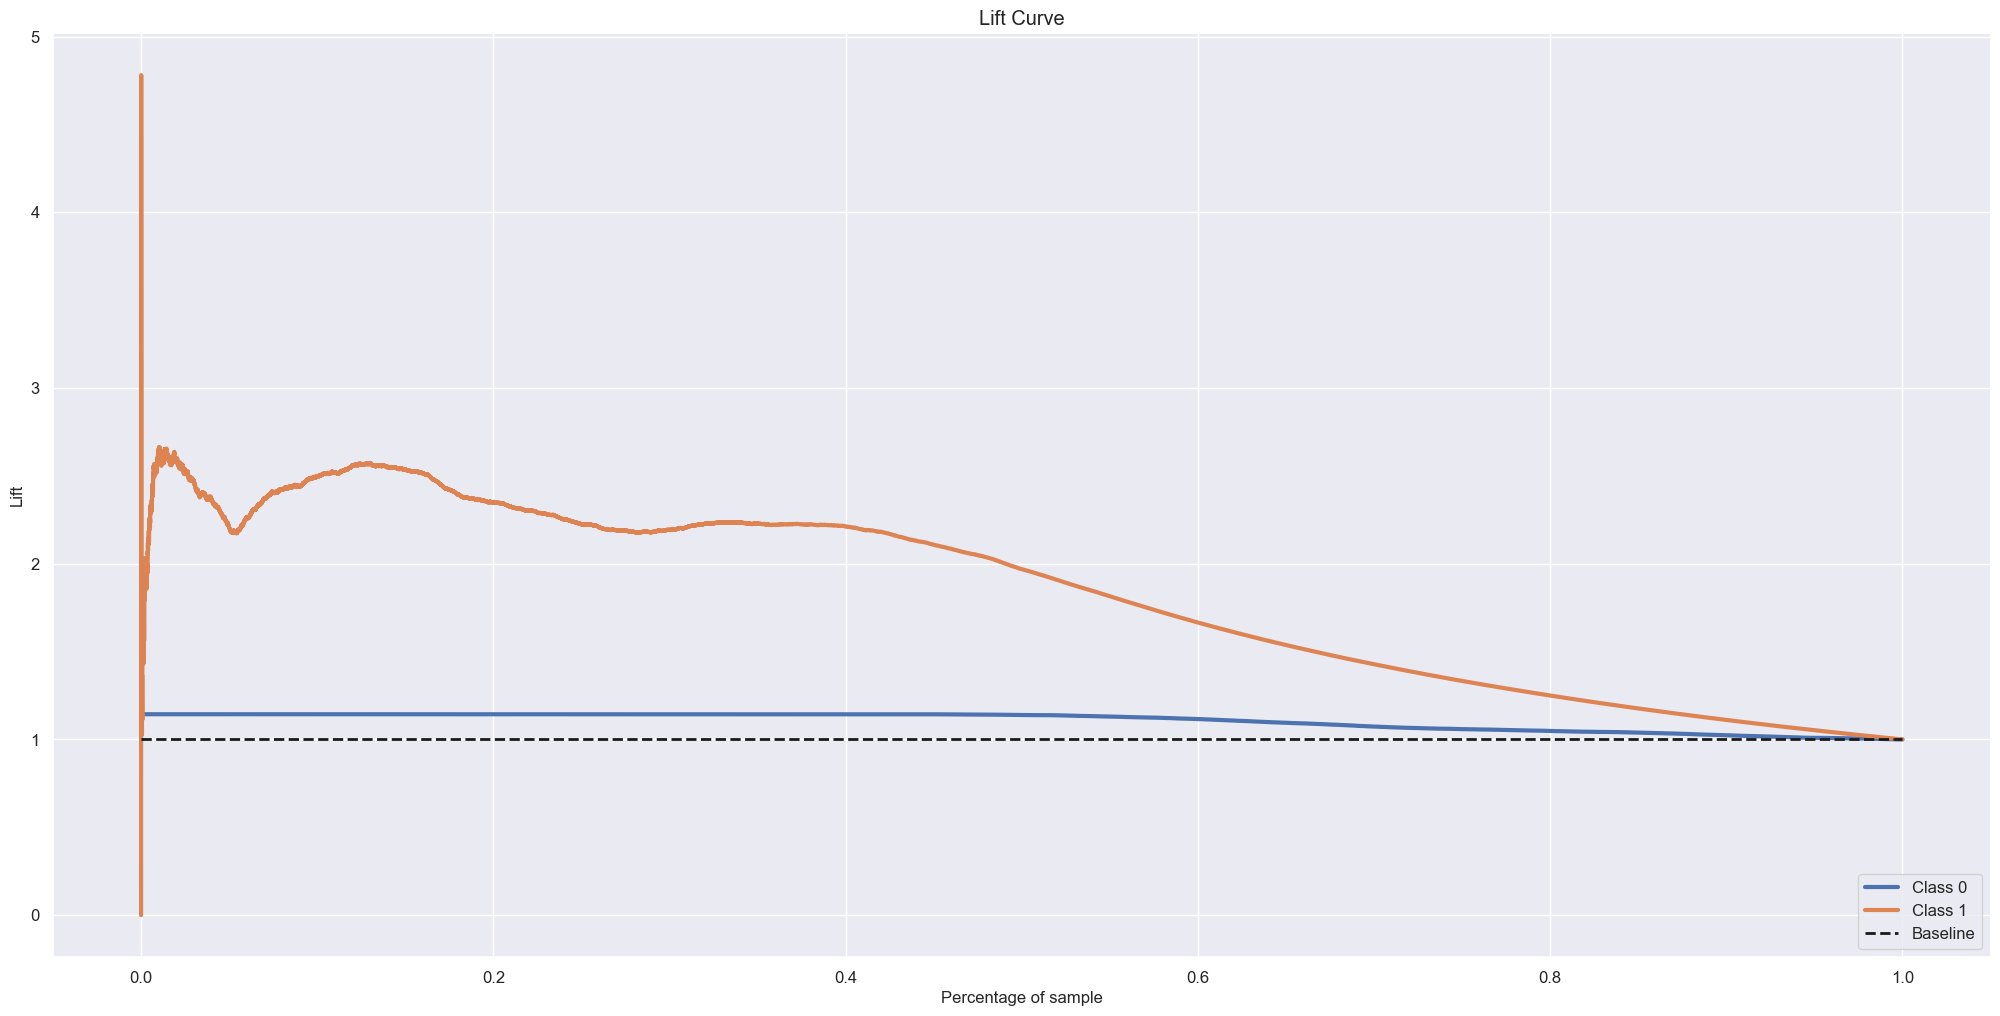

In [72]:
# Modelo
logreg = lm.LogisticRegression()

# Treino
logreg.fit(x_train, y_train)

# Predicao para a cumulative gains
yhat_logreg_proba = logreg.predict_proba(x_val)

# cumulativa gains curve
skplt.metrics.plot_cumulative_gain(y_val, yhat_logreg_proba);

# Curve Lift
skplt.metrics.plot_lift_curve(y_val, yhat_logreg_proba);

print('A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo Logistic Regression,') 
print('nos teremos aproximadamente 85% dos clientes interessados em adquirir o seguro veicular.\n') 

print('A curva Lift nos diz que se considerarmos 40% da nossa amostra, a lsita organizada pelo modelo Logistic Regression,')
print('é 2,3 vezes melhor que uma lista organizada de forma randômica.')

### 7.4.1 LogisticRegression CrossValidation

In [73]:
# Cross_validation
logreg_model_cv = pd.DataFrame(cross_validation(data_training, 'LogisticRegressor Model', logreg, 5), index=[0])
logreg_model_cv

,model_name,precision_at_k_40000,recall_at_k_40000
0,LogisticRegressor Model,0.149,1.0


## 7.5 Random Forest Classifier

A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo RandomForestClassifier,
nos teremos aproximadamente 85% dos clientes interessados em adquirir o seguro veicular.

A curva Lift nos diz que se considerarmos 40% da nossa amostra, a lista organizada pelo modelo RandomForestClassifier,
é 2,3 vezes melhor que uma lista organizada de forma randômica.


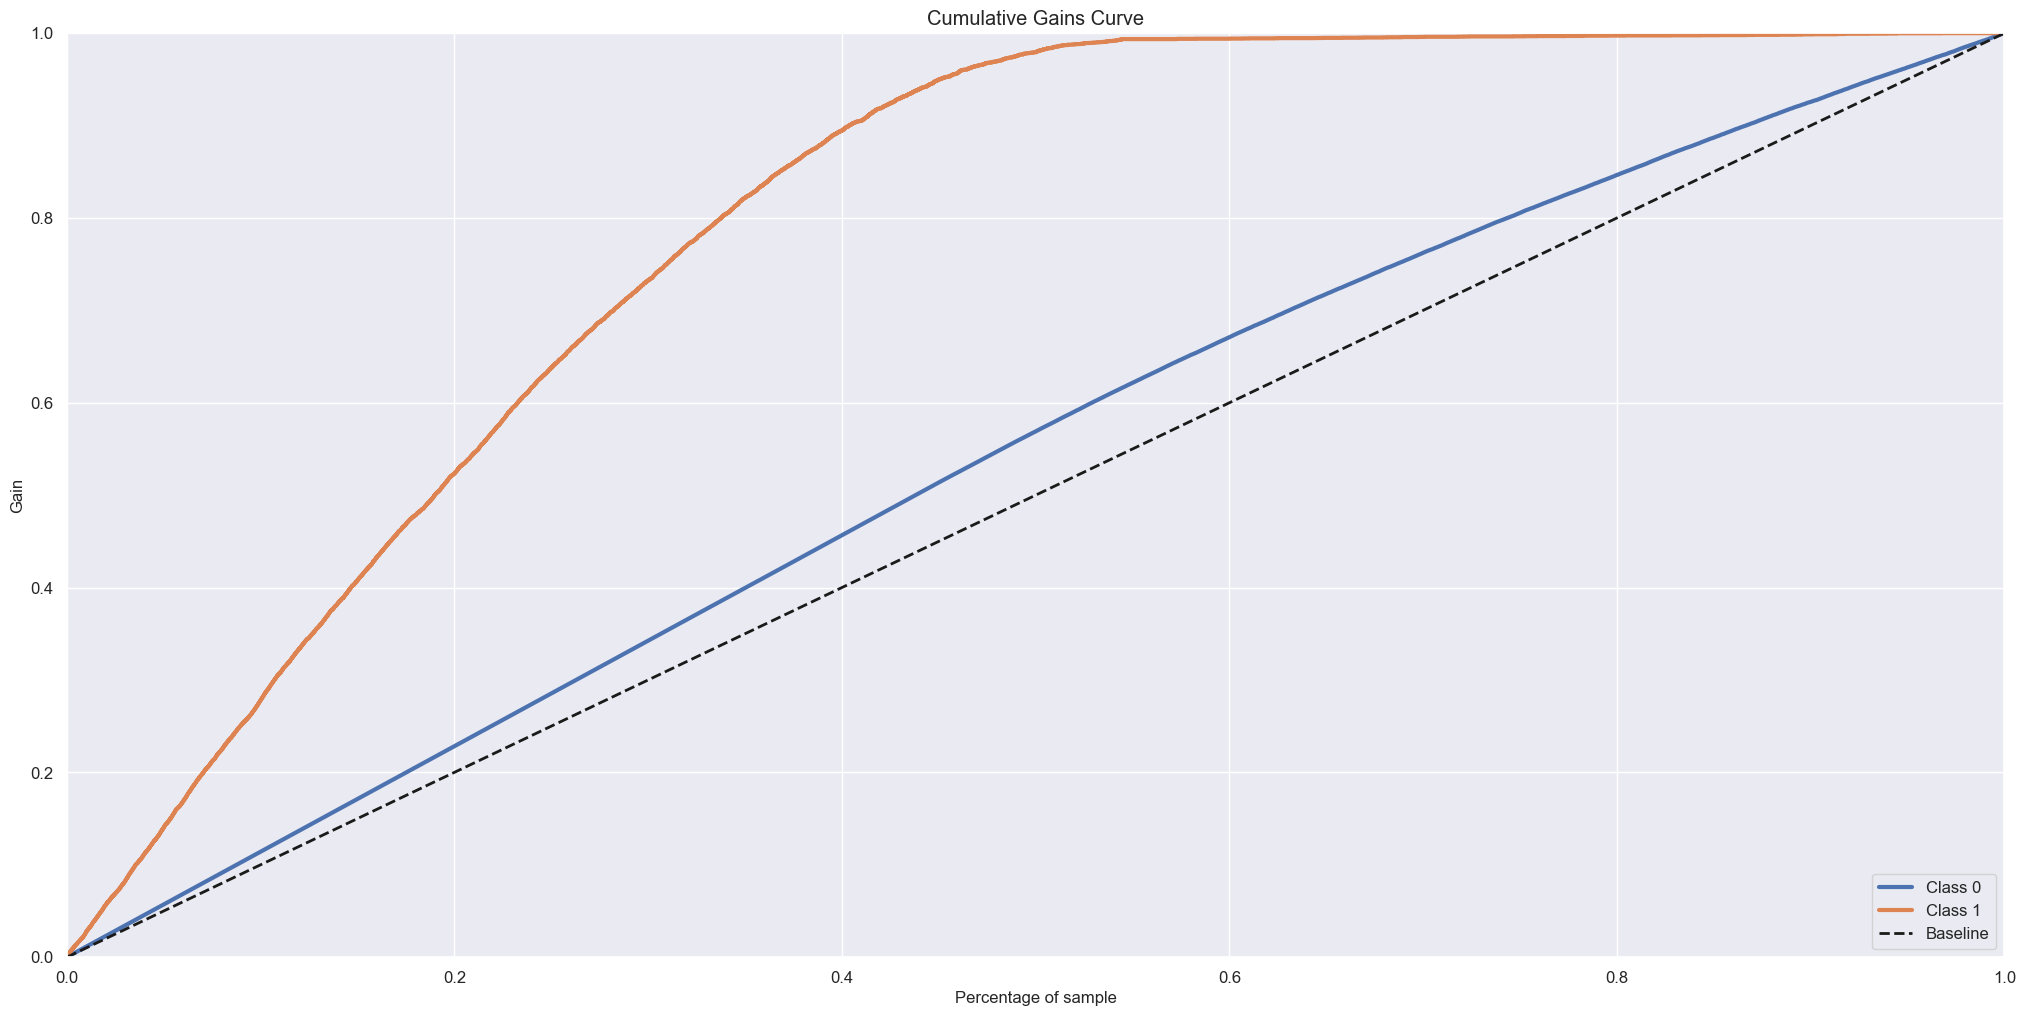

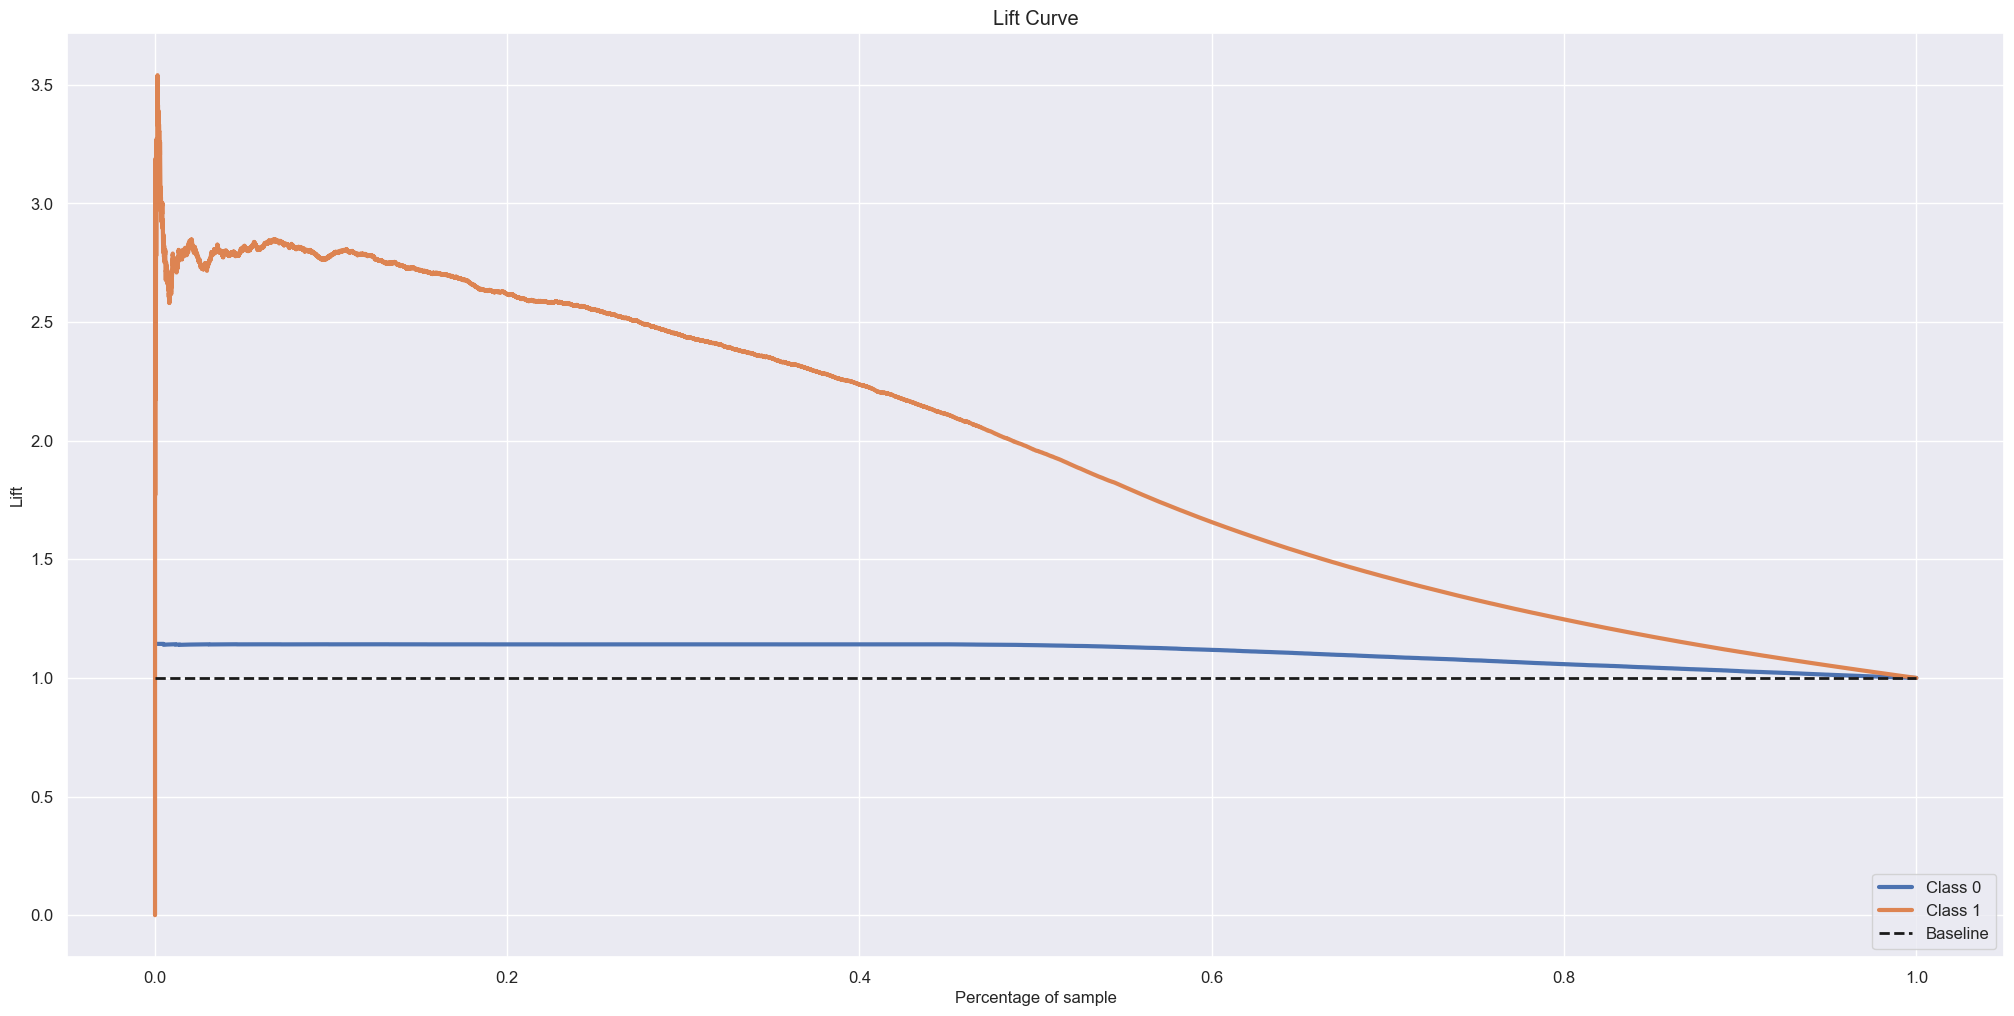

In [74]:
# Model
rf_model = en.RandomForestClassifier(n_jobs=-1)

# Treino
rf_model.fit(x_train, y_train)

# Predição para a cumulative gains curve
yhat_rf_proba = rf_model.predict_proba(x_val)

# Cumulative Curve Gains
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf_proba);

# Curve Lift
skplt.metrics.plot_lift_curve(y_val, yhat_rf_proba);

print('A curva Cumulative Gains nos diz que se tomarmos 40% da amostra, organizada pelo modelo RandomForestClassifier,') 
print('nos teremos aproximadamente 85% dos clientes interessados em adquirir o seguro veicular.\n') 

print('A curva Lift nos diz que se considerarmos 40% da nossa amostra, a lista organizada pelo modelo RandomForestClassifier,')
print('é 2,3 vezes melhor que uma lista organizada de forma randômica.')



### 7.5.1 RandomForestClassifier CrossValidation

In [75]:
# Cross_validation
rf_model_cv = pd.DataFrame(cross_validation(data_training, 'RandomForestClassifier Model', rf_model, 5), index=[0])
rf_model_cv

,model_name,precision_at_k_40000,recall_at_k_40000
0,RandomForestClassifier Model,0.149,0.997


## 7.6 - Performance dos Modelos

In [76]:
pd.concat([knn_model_cv, xgb_model_cv, et_model_cv, logreg_model_cv, rf_model_cv], axis=0)

,model_name,precision_at_k_40000,recall_at_k_40000
0,KNN Model,0.140,0.940
0,XGBClassifier Model,0.149,1.000
0,ExtraTreesClassifier Model,0.148,0.994
0,LogisticRegressor Model,0.149,1.000
0,RandomForestClassifier Model,0.149,0.997


- Realizada a análise das métricas recall e precision at k dos modelos selecionados e feito, também, o estudo de cada curva lift e de cumulative gains desses modelos, chegamos a conclusão que o melhor modelo a ser escolhido é o XGBClassifier.

# 8.0 - Hyperparamater Fine Tunning 

## 8.1 Random Search

In [109]:
#param = {'n_estimators': [200, 300, 400], 'max_depth': [2, 4, 6], 'subsample': [0.1, 0.3],  'colsample_bytree': [0.3, 0.7]} 

#MAX_EVAL = 3

#final_result = pd.DataFrame()
#for i in range(MAX_EVAL):

#    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#    print(hp)

    # model
#    xgbclassifier_model = xgb.XGBClassifier(objective='binary:logistic', 
#                                            n_estimators = hp['n_estimators'], 
#                                            n_jobs=-1,
#                                            max_depth=hp['max_depth'], 
#                                            subsample=hp['subsample'], 
#                                            colsample_bytree = hp['colsample_bytree'])

    # performance
#    result = pd.DataFrame(cross_validation(data_training, 'XGBClassifier Model', xgbclassifier_model, 5), index=[0])
#    final_result = pd.concat([final_result, result], axis=0)
#final_result

{'n_estimators': 400, 'max_depth': 2, 'subsample': 0.3, 'colsample_bytree': 0.7}
{'n_estimators': 300, 'max_depth': 4, 'subsample': 0.1, 'colsample_bytree': 0.7}
{'n_estimators': 300, 'max_depth': 6, 'subsample': 0.3, 'colsample_bytree': 0.3}


,model_name,precision_at_k_40000,recall_at_k_40000
0,XGBClassifier Model,0.15,0.999
0,XGBClassifier Model,0.15,1.000
0,XGBClassifier Model,0.15,0.999


## 8.2 Final Model

In [77]:
# Concatenação dos conjuntos x_train e x_val
x_treino_final = pd.concat([x_train, x_val])
y_treino_final = pd.concat([y_train, y_val])


# parametros
param_tuned = {'n_estimators': 300, 
               'max_depth': 4, 
               'subsample': 0.1, 
               'colsample_bytree': 0.7} 

# model
xgb_tuned = xgb.XGBClassifier(objective='binary:logistic', 
                              n_estimators = param_tuned['n_estimators'], 
                              n_jobs=-1,
                              max_depth=param_tuned['max_depth'], 
                              subsample=param_tuned['subsample'], 
                              colsample_bytree = param_tuned['colsample_bytree'])



# treino
xgb_tuned.fit(x_treino_final, y_treino_final);

# Salvando o modelo treinado.
pickle.dump(xgb_tuned, open('/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/src/features/model_xgb.pkl', 'wb'))

# 9.0 - Tradução e Interpretação dos Resultados

## 9.1 Machine Learning Performance

- Aqui nós vamos analisar a performance do nosso modelo com dados nunca antes vistos, mas que estão no conjunto de treino. Assim, veremos a capacidade de generalização do modelo escolhido, dessa maneira, verificando se não houve o overfitting do modelo.

In [67]:
xgb_tuned = pickle.load(open('/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/src/features/model_xgb.pkl', 'rb'))

# Predições
yhat_xgb_tuned_proba = xgb_tuned.predict_proba(x_test)
yhat_xgb_tuned = xgb_tuned.predict(x_test)

# precision and recall
precision = round(precision_at_k(df_test, yhat_xgb_tuned_proba), 3)
recall    = round(recall_at_k(df_test, yhat_xgb_tuned_proba), 3)

# Tabela de Métricas 
metricas = {'precision_top_k_40000': precision, 'recall_top_k_40000': recall}

# Tabela com as métricas de performance
performance = pd.DataFrame(metricas, index=['performance_teste'])

performance

,precision_top_k_40000,recall_top_k_40000
performance_teste,0.234,0.992


**Análise da Performance do Modelo**

**1.** O modelo acima nos diz que para os 40.000 clientes da nossa lista ordenada, nós temos 99,4% dos interessados. 

**2.** O modelo acima nos diz que para os 40.000 clientes da nossa lista ordenada, o modelo tem capacidade de acertar 23% em relação ao modelo perfeito.

**Conclusão:** Nosso modelo tem uma boa capacidade de generalização, uma vez que para dados nunca vistos, o modelo teve um bom desempenho ao feito no treino.

## 9.2 Business Performance

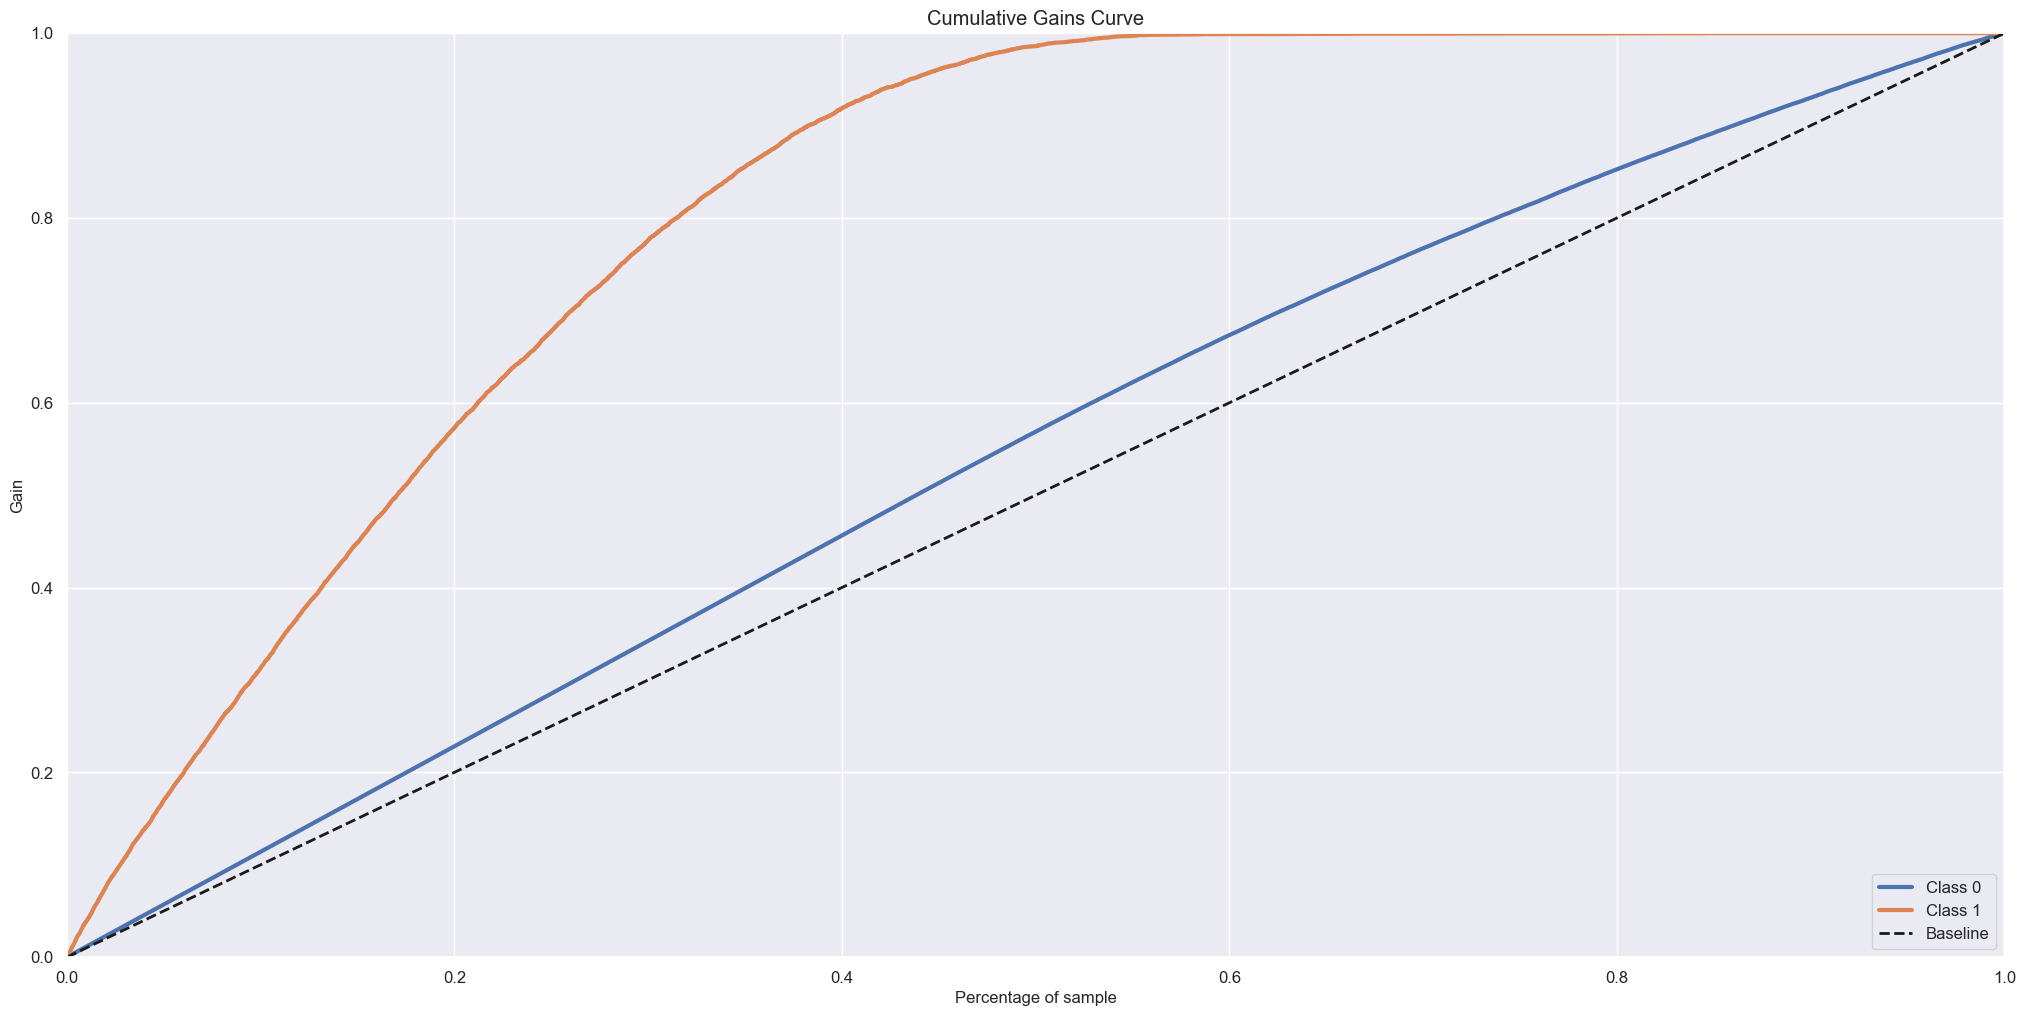

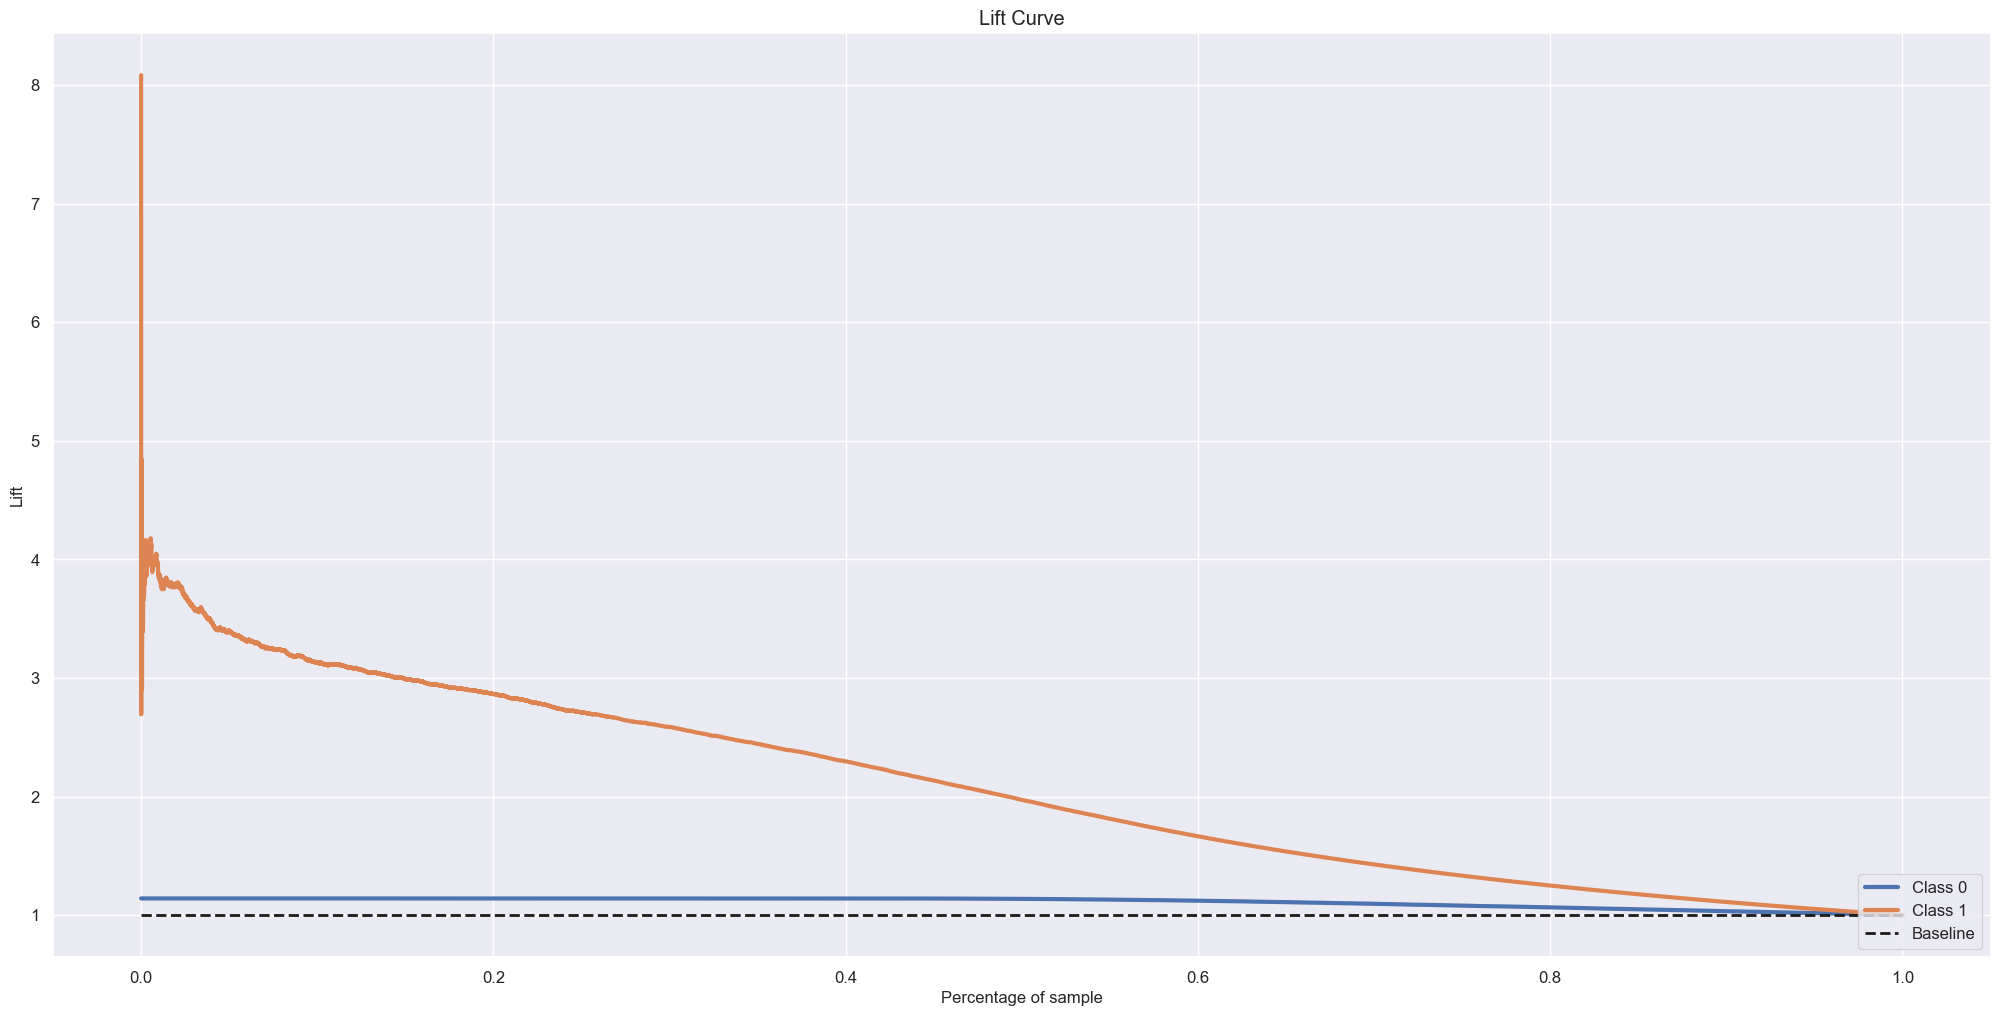

In [69]:
# Gráfico da cumulative curve
skplt.metrics.plot_cumulative_gain(y_test, yhat_xgb_tuned_proba);

# Gráfico da lift curve
skplt.metrics.plot_lift_curve(y_test, yhat_xgb_tuned_proba);

**Análise de Performance de Negócio**

**1.** Tomando 40% da minha lista organizada pelo modelo, teremos 95% dos clientes interessados em adquirir o novo produto.

**2.** Tomando 40% da minha lista organizada pelo model, em relação a uma lista organizada de forma aleatória, ela é 2,3 vezes melhor.

# 10.0 - Deploy do Modelo para Produção

## 10.1 Classe HealthInsurance

In [6]:
import pandas as pd
import pickle
import inflection


class HealthInsurance(object):
    
    def __init__(self):
        
        self.home_path = '/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/'
        self.annual_premium_scaler = pickle.load( open( self.home_path + 'src/features/annual_premium_scaler.pkl', 'rb' ) )
        self.age_scaler            = pickle.load( open( self.home_path + 'src/features/age_scaler.pkl', 'rb' ) )
        self.vintage_scaler        = pickle.load( open( self.home_path + 'src/features/vintage_scaler.pkl', 'rb' ) )

        
    def data_cleaning(self, df1):
        
        snakecase = lambda x: inflection.underscore(x)
        
        # Limpeza dos nomes das colunas
        df1.columns = [snakecase(element) for element in df1.columns.to_list()]
        
        # retorno do dataframe com as keys da coluna organizadas.
        return df1
    
    
    def feature_engineering(self, df2):    
    
        # gender
        df2['gender'] = df2['gender'].apply(lambda x: x.lower())

        # vehicle_damage
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        # vehicle_age
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' 
                                                      if x == '1-2 Year' else 'below_1_year')
    
        # retorno do dataframe com as variáveis limpas
        return df2
    
    
    def data_preparation(self, df5):
        
        
        #### ----------------------------- RESCALING ----------------------------------------------------- ####
        
        
        # padronização da variável annual_premium
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)
        
        # reescala variável age
        df5['age'] = self.age_scaler.transform(df5[['age']].values)
        
        # reescala variável vintage
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)
        
        
        #### ----------------------------- ENCODING ----------------------------------------------------- ####

        
        # Frequencily Enconding - region code
        fe_encode_region_code = df5.groupby('region_code').size()/len(df5)
        df5.loc[ : , 'region_code'] = df5['region_code'].map(fe_encode_region_code)
        
        # Order Enconding - vehicle age
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])
        
        # Frequency Encoding - policy_sales_channel
        fe_policy_sales_channel = df5.groupby('policy_sales_channel').size()/len(df5)
        df5.loc[ : , 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
        
        # Frequencily Encoding - gender
        fe_encode_gender = df5.groupby('gender').size()/len(df5)
        df5.loc[ : , 'gender'] = df5['gender'].map(fe_encode_gender)
        
        # colunas com maiores relevâncias
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 
                         'vehicle_damage', 'policy_sales_channel', 'previously_insured']
        
        # retorno com os dados totalmente preparados 
        return df5[cols_selected]

        
    def prediction(self, model, dataframe_preparation, dataframe_original):
            
        # Lista com as predições realizadas.
        propensity_score = model.prediction_proba(dataframe_preparation)
            
        # Criando a coluna propensity_score
        dataframe_original['propensity_score'] = propensity_score[:, 1].tolist()
            
        # Rankeamento
        dataframe_original = dataframe_original.sort_values(by=['propensity_score'], 
                                                                ascending=False).reset_index(drop=True)

        # Criar a coluna ranking
        dataframe_original['ranking'] = dataframe_original.index + 1
            
        # retorno da lista
        return dataframe_original.to_json(orient='records')

## 10.2 API Handler

In [ ]:
import pandas as pd
import pickle
from flask import Flask, request
from healthinsurance.HealthInsurance import HealthInsurance

app = Flask(__name__)

# Carregamento do modelo de predição
model = pickle.load( open( '/Users/Xcell/repositorio/projects/project_health_insurance_cross_sell/health_insurance_cross_sell/src/features/model_xgb.pkl', 'rb') )

@app.route('/predict', methods=['POST'])

def health_insurance_classification():
    
    # recebimento da requisição
    test_json = request.get_json()
    
    # verificação para saber se houve recebimento de dados na requisição
    if test_json:
        
        # Unique Example
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        # Multiple Example
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
    
        # Instanciando a classe Health_Insurance
        pipeline = HealthInsurance()

        # Limpeza dos Dados
        df_cleaned = pipeline.data_cleaning(test_raw)

        # feature Engineering
        df_feature_engineering = pipeline.feature_engineering(df_cleaned)

        # Preparação dos Dados
        df_preparation = pipeline.data_preparation(df_feature_engineering)

        # Predicao
        df_response = pipeline.prediction(model, df_preparation, df_cleaned)
        
        return df_response
    
    else:
        
        return Response('{}', status=200, mimetype='application/json')
    
    
if __name__ == '__main__':
    app.run('192.168.1.7')    

## 10.3 API Tester

In [74]:
# Carregamento dos dados de teste
df_10 = pd.read_csv('../data/raw/test.csv')

In [75]:
# Conversão dos dados em JSON para requisição
data = json.dumps(df_10.to_dict(orient='records') )

In [76]:
import requests
# API Call

url = 'https://classification-insurance-all.herokuapp.com/predict'
#url = 'http://192.168.1.7:5000/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code: {}'.format(r.status_code))

df_heroku = pd.DataFrame(r.json(), columns=r.json()[0].keys())

Status Code: 200


# 11.0 - Respondendo as Perguntas do CEO

**Observações**

**1.** Assumiremos que clientes que possuem interesse em adquirir o produto tem propensão de compra acima de 50%. Da mesma forma, assumiremos que clientes que não possuem interesse em adquirir o produto

**2.** O valor anual do seguro veicular é Rs 5000.

## 11.1 - Questões 

**2.** Qual a porcentagem de clientes interessados em adquirir um seguro de automóvel? O time de vendas conseguirá contatar todos esses clientes fazendo 20.000 ligações?

In [94]:
# Clientes Interessados
customer_interesting = df_heroku[df_heroku['propensity_score'] > 0.5]['propensity_score'].count()

# Quantidade de Clientes dos dados de teste
num_customers = df_heroku.shape[0]

# Porcentagem de Clientes Interessados
percentual = round((customer_interesting/num_customers) * 100, 2)

print(f'Quantidade de clientes no conjunto: {num_customers}.')
print(f'Clientes interessados: {customer_interesting}.')
print(f'Representação percentual dos clientes que tem interesse: {percentual}%.')

Quantidade de clientes no conjunto: 127037.
Clientes interessados: 2250.
Representação percentual dos clientes que tem interesse: 1.77%.


- Em nosso conjunto de teste nós temos aproximadamente 1.77% de clientes interessados em adquirir o seguro de automóvel, ou seja, 2250 clientes de um conjunto de teste possui 127037 clientes.

- Observe que ao realizar 20.000 ligações para os clientes que estão na lista organizada pelo nosso modelo, nós estamos tomando 15% do nosso conjunto de dados. A curva de cumulative gains do nosso modelo diz que se tomarmos 15% do nossos dados, temos em torno de 40% dos clientes interessados. Ou seja, em 20.000 ligações nós vamos conseguir atingir 900 clientes interessados.

- Logo, com a campanha tem a capacidade de 20.000 ligações, teremos um faturamento estimado em Rs 4.500.000

**3.** E se a capacidade do time de vendas aumentar para 40.000 ligações, qual a porcentagem de clientes interessados em adquirir um seguro de automóvel o time de vendas conseguirá contatar?

- Realizando 40.000 ligações para os clientes que estão na lista organizada pelo nosso modelo, nós estamos tomando 31% do nosso conjunto de dados. A curva de cumulative gains do nosso modelo diz que se tomarmos 32% do nossos dados, temos em torno de 80% dos clientes interessados. Ou seja, em 40.000 ligações nós vamos conseguir atingir 1800 clientes interessados.


- Assim, se a campanha da empresa trabalhar com a capacidade de 40.000 ligações, o faturamento estimado será em torno de Rs 9.000.000

**4.** Quantas ligações o time de vendas precisa fazer para contatar 80% dos clientes interessados em adquirir um seguro de automóvel?

- Segundo a curva de ganho cumulativo, nós temos que tomar em torno 32% da nossa lista ordenanda para atingir 80% do clientes
interessados, ou seja, temos que realizar em torno de 40652 ligações.